In [1]:
# ===================================================================
# CELL 0: DRIVE MOUNT & ENVIRONMENT SETUP
# ===================================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# --- 1. SETUP KAGGLE ENVIRONMENT ---
# --- Install Dependencies ---
# GIET-Net requires torch-geometric for GNN layers and scikit-image for the V2G module.
!pip uninstall -y monai torch torchvision torchaudio
!pip install "monai[nibabel,tqdm]>=1.3.0" --upgrade -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch-geometric scikit-image einops -q
!pip install torchio
!pip install kornia -q
print("Environment setup complete. Please RESTART THE SESSION now from the 'Run' menu.")

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2.5D Tensor Densenet Single input

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler

# --- Configuration & Hyperparameters ---
# Data and Model paths
DATA_FILE_PATH = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt"
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100 # Reduced for a 2.5D test run, can be increased later
INITIAL_LR = 0.0004
BATCH_SIZE = 16 # Can be increased significantly for 2D processing
NUM_WORKERS = 0

# --- FINAL OPTIMIZATION: 2.5D Slice-based processing ---
# Model and Data Dimensions
# We take 3 slices (current, prev, next) and stack them in the channel dimension.
# Input channels = 5 (T1, T1c, T2, FLAIR, Grad) * 3 slices = 15
IN_CHANNELS = 15
OUT_CHANNELS = 5
CROP_SIZE = (96, 96) # Crop size is now 2D

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation Functions (2D) ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]

    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

# --- FINAL OPTIMIZATION: 2.5D Slice-based Dataset ---
class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print("Loading 3D volumes into memory for slicing...")
        for path in file_paths:
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float() # C, D, H, W
            label_vol = data['label'].long()  # D, H, W

            self.scans.append(image_vol)
            self.labels.append(label_vol)

            # Create a map from a flat index to a (scan_index, slice_index) tuple
            for slice_idx in range(image_vol.shape[1]): # Iterate over depth
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        image_vol = self.scans[scan_idx]
        label_vol = self.labels[scan_idx]

        # Get the target slice and its label
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        # Get the previous slice, padding if it's the first slice
        prev_slice_idx = max(0, slice_idx - 1)
        prev_slice = image_vol[:, prev_slice_idx, :, :]

        # Get the next slice, padding if it's the last slice
        next_slice_idx = min(image_vol.shape[1] - 1, slice_idx + 1)
        next_slice = image_vol[:, next_slice_idx, :, :]

        # Stack the slices along the channel dimension
        # Input shape becomes (num_channels * 3, height, width)
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)

        return stacked_slices, target_label

# --- FINAL OPTIMIZATION: 2D Model Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.norm = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            return self.conv(x_input)

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128] # Reduced depth for 2D

        self.down = nn.MaxPool2d(2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])

        self.up10 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.x01 = UNetPlusPlusNode2D(filters[0] + filters[0], filters[0])

        self.up20 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.x11 = UNetPlusPlusNode2D(filters[1] + filters[1], filters[1])

        self.up11 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.x02 = UNetPlusPlusNode2D(filters[0] + filters[0] + filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def forward(self, x):
        x00_out = self.x00(x)
        x10_out = self.x10(self.down(x00_out))
        x01_out = self.x01(self.up10(x10_out), skip_features=[x00_out])

        x20_out = self.x20(self.down(x10_out))
        x11_out = self.x11(self.up20(x20_out), skip_features=[x10_out])

        x02_out = self.x02(self.up11(x11_out), skip_features=[x00_out, x01_out])

        output = self.final(x02_out)

        if self.deep_supervision:
            return [output]
        else:
            return output

# --- Loss Function & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        return torch.cat(tensor_list, dim=1)

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes

        dice = 0
        for i in range(self.n_classes):
            dice += self._dice_loss(inputs[:, i], target[:, i]) * weight[i]
        return dice / self.n_classes

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    if isinstance(outputs, list):
        for output in outputs:
            ce = ce_loss_fn(output, targets)
            dice = dice_loss_fn(output, targets, softmax=True)
            total_loss += ce + dice
        total_loss /= len(outputs)
    else:
        ce = ce_loss_fn(outputs, targets)
        dice = dice_loss_fn(outputs, targets, softmax=True)
        total_loss = ce + dice
    return total_loss

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training Initialized ---")
    print(f"Device: {DEVICE}")

    if not os.path.exists(DATA_FILE_PATH):
        print(f"ERROR: Data file not found at {DATA_FILE_PATH}")
        return

    file_paths = [DATA_FILE_PATH]

    dataset = BraTSSliceDataset(file_paths=file_paths, transform=True)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data loaded: {len(dataset)} total slices for training and validation.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        start_time = time.time()
        model.train()
        train_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s | Train Loss: {avg_train_loss:.3f}')

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training Initialized ---
Device: cpu
Loading 3D volumes into memory for slicing...
Dataset initialized. Total slices: 155
Data loaded: 155 total slices for training and validation.
Model initialized with 0.03M parameters.
Epoch: 01 | Time: 0m 13s | Train Loss: 2.148
Epoch: 02 | Time: 0m 12s | Train Loss: 2.073
Epoch: 03 | Time: 0m 12s | Train Loss: 2.004
Epoch: 04 | Time: 0m 12s | Train Loss: 1.943
Epoch: 05 | Time: 0m 12s | Train Loss: 1.898
Epoch: 06 | Time: 0m 12s | Train Loss: 1.841
Epoch: 07 | Time: 0m 12s | Train Loss: 1.793
Epoch: 08 | Time: 0m 12s | Train Loss: 1.751
Epoch: 09 | Time: 0m 12s | Train Loss: 1.701
Epoch: 10 | Time: 0m 12s | Train Loss: 1.657
Epoch: 11 | Time: 0m 12s | Train Loss: 1.618
Epoch: 12 | Time: 0m 12s | Train Loss: 1.582
Epoch: 13 | Time: 0m 12s | Train Loss: 1.532
Epoch: 14 | Time: 0m 24s | Train Loss: 1.501
Epoch: 15 | Time: 0m 12s | Train Loss: 1.470
Epoch: 16 | Time: 0m 13s | Train Loss: 1.448
Epoch: 17 | Time: 0m 12s | Train Loss:

## Code with introducing deep supervision, swine transformer and Unet++ in 2d(dueto memory constraints)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
# --- UPDATE: List of 4 files for 3-train, 1-val split ---
# NOTE: Please ensure these files exist in your Drive.
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00004-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128) # Increased crop size slightly for the more powerful model

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).permute(2, 0, 1) # (H*W, B, C)
        x_norm = self.norm(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        return x.permute(1, 2, 0).view(B, C, H, W)

class UNetPlusPlusNode2D(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)
    def forward(self, x, skip_features=None):
        if skip_features:
            x = torch.cat([*skip_features, x], dim=1)
        x = self.conv(x)
        if self.use_swin:
            x = self.swin(x)
        return x

class DenseTrans2D(nn.Module):
    # FIX: Standardize parameter names
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        # FIX: Standardize parameter names in lambda
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    # Calculate 95th percentile Hausdorff distance
    h95 = 0
    for i in range(1, OUT_CHANNELS): # Exclude background
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Re-Architected Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                # Use final output for metrics
                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Re-Architected Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.57M parameters.


# Without swine transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00004-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128)

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        return stacked_slices, target_label

# --- Super-Lightweight 2.5D DenseTrans Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # FIX: Removed Swin Transformer for minimum memory usage
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )

    def forward(self, x, skip_features=None):
        # FIX: Use checkpointing to save memory on activations
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            return self.conv(x_input)

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        # use_reentrant=False is modern and more efficient
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        # FIX: Drastically reduced filter width for minimum memory usage
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0])

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1])

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2])

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0])

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1])

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0])

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Super-Lightweight Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Super-Lightweight Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.12M parameters.
Epoch: 01 | LR: 0.000400 | Train Loss: 2.4573 | Val Loss: 2.4434 | Val Dice: 0.0067 | Val HD95: 42.19
Epoch: 02 | LR: 0.000400 | Train Loss: 2.2723 | Val Loss: 2.3443 | Val Dice: 0.0073 | Val HD95: 38.48


KeyboardInterrupt: 

# with swine transformer - tried with 3 samples, overfits

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff

# --- Configuration & Hyperparameters ---
# Data and Model paths
ALL_FILES = [
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00006-000.pt",
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00005-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00008-000.pt", # Placeholder
    "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/BraTS-PED-00009-000.pt"  # Placeholder for validation
]
MODEL_SAVE_PATH = "./"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 0

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (128, 128)

# Class Imbalance Weights
CLASS_WEIGHTS = torch.tensor([1.4288, 48.6196, 41.1231, 49.6298, 48.6472], dtype=torch.float32).to(DEVICE)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.scans = []
        self.labels = []
        self.slice_map = []

        print(f"Loading {len(file_paths)} 3D volume(s) for slicing...")
        for path in file_paths:
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()
            self.scans.append(image_vol)
            self.labels.append(label_vol)
            for slice_idx in range(image_vol.shape[1]):
                self.slice_map.append((len(self.scans) - 1, slice_idx))
        print(f"Dataset initialized. Total slices: {len(self.slice_map)}")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        image_vol, label_vol = self.scans[scan_idx], self.labels[scan_idx]
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]
        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            # --- FIX: Ensure validation data has the correct, consistent size ---
            # Resize image to CROP_SIZE
            stacked_slices = nn.functional.interpolate(
                stacked_slices.unsqueeze(0), # Add batch dim for interpolate
                size=CROP_SIZE,
                mode='bilinear',
                align_corners=False
            ).squeeze(0) # Remove batch dim
            # Resize label to CROP_SIZE
            target_label = nn.functional.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(), # Add batch and channel dims
                size=CROP_SIZE,
                mode='nearest' # Use nearest neighbor for labels to avoid new values
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    """ A lightweight Swin Transformer block for 2D feature maps. """
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1) # B, H, W, C

        # Pad to make dimensions divisible by window size
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        padded_H, padded_W = H + pad_h, W + pad_w

        # Create windows
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)

        # Self-attention
        attn_windows, _ = self.attn(windows, windows, windows)

        # Merge windows
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c',
                      h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)

        # Remove padding and reshape back
        x = x[:, :H, :W, :].permute(0, 3, 1, 2) # B, C, H, W
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                # Add a residual connection around the Swin block
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)

        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)

        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)

        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)

        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)

        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss & Metrics ---
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
    def _one_hot(self, t, n_c):
        return nn.functional.one_hot(t, n_c).permute(0, 3, 1, 2)
    def _dice(self, score, target):
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target)
        z_sum = torch.sum(score)
        return (2 * intersect + smooth) / (y_sum + z_sum + smooth)
    def forward(self, inputs, target, softmax=True):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot(target, self.n_classes)
        dice_per_class = torch.zeros(self.n_classes-1).to(inputs.device)
        for i in range(1, self.n_classes): # Exclude background
            dice_per_class[i-1] = self._dice(inputs[:, i], target[:, i])
        return 1 - dice_per_class.mean()

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_loss(outputs, targets, class_weights):
    ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    dice_loss_fn = DiceLoss(n_classes=OUT_CHANNELS)
    total_loss = 0
    for o in outputs:
        o = nn.functional.interpolate(o, size=targets.shape[-2:], mode='bilinear', align_corners=False)
        total_loss += ce_loss_fn(o, targets) + dice_loss_fn(o, targets)
    return total_loss / len(outputs)

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Re-Architected Training ---")

    train_files = ALL_FILES[:3]
    val_files = ALL_FILES[3:]

    train_dataset = BraTSSliceDataset(file_paths=train_files, transform=True)
    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data: {len(train_dataset)} train slices, {len(val_dataset)} val slices.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = get_loss(outputs, targets, CLASS_WEIGHTS)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = get_loss(outputs, targets, CLASS_WEIGHTS)
                val_loss += loss.item()

                preds = torch.softmax(outputs[-1], dim=1)
                dice_loss_metric = DiceLoss(n_classes=OUT_CHANNELS)
                val_dice += (1 - dice_loss_metric(preds, targets, softmax=False)).item()

                preds_np = torch.argmax(preds, dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Re-Architected Training ---
Loading 3 3D volume(s) for slicing...
Dataset initialized. Total slices: 465
Loading 1 3D volume(s) for slicing...
Dataset initialized. Total slices: 155
Data: 465 train slices, 155 val slices.
Model initialized with 0.15M parameters.
Epoch: 01 | LR: 0.000400 | Train Loss: 2.5515 | Val Loss: 2.4144 | Val Dice: 0.0062 | Val HD95: 25.04
Epoch: 02 | LR: 0.000400 | Train Loss: 2.2313 | Val Loss: 2.1446 | Val Dice: 0.0073 | Val HD95: 20.69
Epoch: 03 | LR: 0.000399 | Train Loss: 1.9636 | Val Loss: 1.8923 | Val Dice: 0.0095 | Val HD95: 15.46
Epoch: 04 | LR: 0.000398 | Train Loss: 1.7050 | Val Loss: 1.6997 | Val Dice: 0.0091 | Val HD95: 6.73
Epoch: 05 | LR: 0.000398 | Train Loss: 1.4998 | Val Loss: 1.6855 | Val Dice: 0.0063 | Val HD95: 4.45
Epoch: 06 | LR: 0.000396 | Train Loss: 1.3614 | Val Loss: 1.7068 | Val Dice: 0.0094 | Val HD95: 2.48
Epoch: 07 | LR: 0.000395 | Train Loss: 1.2536 | Val Loss: 1.7756 | Val Dice: 0.0108 | Val HD95: 1.40
Epoch: 

KeyboardInterrupt: 

# model with train-val split - same arch - 5 samples per epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Configuration & Hyperparameters ---
# --- UPDATE: Use a directory of scans ---
DATA_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/"
MODEL_SAVE_PATH = "./best_model.pt"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 200
INITIAL_LR = 0.0004
BATCH_SIZE = 16
# --- UPDATE: Re-enabling num_workers with the new efficient dataset ---
NUM_WORKERS = 2
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 7
SCANS_PER_EPOCH = 15 # Increased for more data variety per epoch
VAL_SCANS_PER_EPOCH = 20 # Increased for more data variety per epoch

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5
CROP_SIZE = (96, 96)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    """
    --- OPTIMIZATION: Hybrid Lazy/Cached Loading Dataset ---
    This dataset loads one entire 3D scan into a cache, serves all slices
    from it quickly from RAM, and only loads from disk when the scan changes.
    This provides a massive speedup over pure lazy loading.
    """
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []

        # --- UPDATE: Caching mechanism ---
        self.cache = {}
        self.cached_scan_idx = -1

        print(f"Building slice map for {len(file_paths)} scans (without loading data)...")
        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                print(f"WARNING: File not found {path}. Skipping.")
                continue
            # Temporarily load to get shape, then discard
            data = torch.load(path, map_location='cpu', weights_only=True)
            num_slices = data['image'].shape[1]
            for j in range(num_slices):
                self.slice_map.append((i, j)) # -> (scan_index_in_list, slice_index_in_scan)

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # --- UPDATE: Smart Caching Logic ---
        if scan_idx != self.cached_scan_idx:
            # If the requested scan is not in cache, load it from disk
            path = self.file_paths[scan_idx]
            self.cache = torch.load(path, map_location='cpu', weights_only=True)
            self.cached_scan_idx = scan_idx

        # Now, get the data from the cache (fast, in-memory operation)
        image_vol = self.cache['image'].float()
        label_vol = self.cache['label'].long()

        # Extract slices
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            stacked_slices = nn.functional.interpolate(stacked_slices.unsqueeze(0), size=CROP_SIZE, mode='bilinear', align_corners=False).squeeze(0)
            target_label = nn.functional.interpolate(target_label.unsqueeze(0).unsqueeze(0).float(), size=CROP_SIZE, mode='nearest').squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Re-architected 2.5D DenseTrans with Swin Transformers ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False):
        super().__init__()
        self.use_swin = use_swin
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]
            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)
            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv
        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [16, 32, 64, 128]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])
        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True)
        self.up20 = self.up(filters[2], filters[1])
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True)
        self.up30 = self.up(filters[3], filters[2])
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True)
        self.up11 = self.up(filters[1], filters[0])
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True)
        self.up21 = self.up(filters[2], filters[1])
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True)
        self.up12 = self.up(filters[1], filters[0])
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True)
        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])
        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])
        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])
        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- UPDATE: Asymmetric Focal Tversky Loss ---
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)

        loss = 0
        for i in range(1, OUT_CHANNELS): # Iterate over each class (excluding background)
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]

            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()

            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky

        return loss / (OUT_CHANNELS - 1)

def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_dice_score(pred, target):
    smooth = 1e-5
    dice = 0
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i)
        target_i = (target == i)
        intersection = (pred_i & target_i).sum().float()
        union = pred_i.sum().float() + target_i.sum().float()
        dice += (2. * intersection + smooth) / (union + smooth)
    return (dice / (OUT_CHANNELS - 1)).item()

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training ---")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"ERROR: No .pt files found in {DATA_DIR}. Please check the path.")
        return

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    val_dataset = BraTSSliceDataset(file_paths=val_files, transform=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    print(f"Data Split: {len(train_files)} training scans, {len(val_files)} validation scans.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    # --- UPDATE: Early Stopping Initialization ---
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        # --- UPDATE: Per-epoch random sub-sampling of training data ---
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = BraTSSliceDataset(file_paths=epoch_train_files, transform=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        print(f"\nEpoch {epoch+1}/{EPOCHS}: Training on {len(epoch_train_files)} scans ({len(train_dataset)} slices)...")

        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=True)
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = BraTSSliceDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=True)
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                val_loss += loss.item()
                val_dice += get_dice_score(outputs[-1], targets)
                preds_np = torch.argmax(outputs[-1], dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset)

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        # --- UPDATE: Early Stopping Logic ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"-> Val loss improved. Model saved to {MODEL_SAVE_PATH}")
        else:
            patience_counter += 1
            print(f"-> Val loss did not improve. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("-> Early stopping triggered. Training finished.")
            break

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training ---
Building slice map for 53 scans (without loading data)...
Data Split: 208 training scans, 53 validation scans.
Model initialized with 0.15M parameters.
Building slice map for 15 scans (without loading data)...

Epoch 1/200: Training on 15 scans (2325 slices)...


Epoch 1 Training:  53%|█████▎    | 77/146 [06:55<06:12,  5.40s/it, loss=0.968]


KeyboardInterrupt: 

# added attention gates, boundary loss with AFTL and increased depth to L4 UNet++

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kornia.filters as K

# --- Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/InputScans/"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Training Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 200
INITIAL_LR = 0.0004
BATCH_SIZE = 16
NUM_WORKERS = 2
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 10 # Increased patience for the more complex model
SCANS_PER_EPOCH = 5
VAL_SCANS_PER_EPOCH = 2

# 2.5D Slice-based processing
IN_CHANNELS = 15 # 5 modalities * 3 slices
OUT_CHANNELS = 5 # 4 labels + 1 background
CROP_SIZE = (128, 128)

# --- Data Augmentation & Dataset ---
def random_crop_2d(img, label, crop_size):
    h, w = img.shape[1:]
    ch, cw = crop_size
    if h < ch or w < cw:
        pad_h = max(0, ch - h)
        pad_w = max(0, cw - w)
        img = nn.functional.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        label = nn.functional.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
        h, w = img.shape[1:]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

class BraTSSliceDataset(Dataset):
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.cache = {}
        self.cached_scan_idx = -1

        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                continue
            data = torch.load(path, map_location='cpu', weights_only=True)
            num_slices = data['image'].shape[1]
            for j in range(num_slices):
                self.slice_map.append((i, j))

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        if scan_idx != self.cached_scan_idx:
            path = self.file_paths[scan_idx]
            self.cache = torch.load(path, map_location='cpu', weights_only=True)
            self.cached_scan_idx = scan_idx

        image_vol = self.cache['image'].float()
        label_vol = self.cache['label'].long()

        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]
        prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
        next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        if self.transform:
            stacked_slices, target_label = random_crop_2d(stacked_slices, target_label, CROP_SIZE)
        else:
            stacked_slices = nn.functional.interpolate(stacked_slices.unsqueeze(0), size=CROP_SIZE, mode='bilinear', align_corners=False).squeeze(0)
            target_label = nn.functional.interpolate(target_label.unsqueeze(0).unsqueeze(0).float(), size=CROP_SIZE, mode='nearest').squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

# --- Final Enhanced 2.5D DenseTrans Architecture ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.InstanceNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.InstanceNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.InstanceNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]

            if self.attention_gate and len(skip_inputs) > 0:
                g = x_input
                x_skip = skip_inputs[0]
                attended_skip = self.attention_gate(g=g, x=x_skip)
                skip_inputs = [attended_skip] + list(skip_inputs[1:])

            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        # --- FIX: Use the more robust re-entrant version of checkpointing ---
        return checkpoint(custom_forward, *all_inputs, use_reentrant=True)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        ag10 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = AttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Composite Loss Function for Boundaries and Shapes ---
class BoundaryLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        spatial_grad = K.spatial_gradient(targets_one_hot)
        grad_y = spatial_grad[:, :, 0, :, :]
        grad_x = spatial_grad[:, :, 1, :, :]
        boundary_magnitude = torch.sqrt(grad_x**2 + grad_y**2)

        boundary_target_mask = (boundary_magnitude.sum(dim=1, keepdim=True) > 0).float()

        inputs_on_boundary = inputs * boundary_target_mask
        targets_on_boundary = targets_one_hot * boundary_target_mask

        dims = (1, 2, 3)
        intersection = torch.sum(inputs_on_boundary * targets_on_boundary, dims)
        cardinality = torch.sum(inputs_on_boundary + targets_on_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1. - dice_score.mean()

class CompositeLoss(nn.Module):
    def __init__(self, boundary_weight=0.1):
        super().__init__()
        self.aftl = AsymmetricFocalTverskyLoss()
        self.boundary_loss = BoundaryLoss()
        self.boundary_weight = boundary_weight
    def forward(self, inputs, targets):
        aftl_loss = self.aftl(inputs, targets)
        b_loss = self.boundary_loss(inputs, targets)
        return aftl_loss + self.boundary_weight * b_loss

class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)
        loss = 0
        for i in range(1, OUT_CHANNELS):
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]
            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()
            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky
        return loss / (OUT_CHANNELS - 1)

# --- Metrics ---
def get_hausdorff_score(pred_np, target_np):
    h95 = 0
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)
        if len(pred_coords) > 0 and len(target_coords) > 0:
            h1 = directed_hausdorff(pred_coords, target_coords)[0]
            h2 = directed_hausdorff(target_coords, pred_coords)[0]
            h95 += max(h1, h2)
    return h95 / (OUT_CHANNELS - 1) if (OUT_CHANNELS - 1) > 0 else 0

def get_dice_score(pred, target):
    smooth = 1e-5
    dice = 0
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i)
        target_i = (target == i)
        intersection = (pred_i & target_i).sum().float()
        union = pred_i.sum().float() + target_i.sum().float()
        dice += (2. * intersection + smooth) / (union + smooth)
    return (dice / (OUT_CHANNELS - 1)).item() if (OUT_CHANNELS - 1) > 0 else 0

# --- Main Training and Validation Loop ---
def main():
    print("--- DenseTrans 2.5D Training ---")

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"ERROR: No .pt files found in {DATA_DIR}. Please check the path.")
        return

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    print(f"Data Split: {len(train_files)} training scans, {len(val_files)} validation scans.")

    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, deep_supervision=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    loss_fn = CompositeLoss().to(DEVICE)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = BraTSSliceDataset(file_paths=epoch_train_files, transform=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", leave=True)
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        # Validation
        model.eval()
        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = BraTSSliceDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        val_loss, val_dice, val_hd95 = 0.0, 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation", leave=True)
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                val_loss += loss.item()
                val_dice += get_dice_score(outputs[-1], targets)
                preds_np = torch.argmax(outputs[-1], dim=1).cpu().numpy()
                targets_np = targets.cpu().numpy()
                for i in range(preds_np.shape[0]):
                    val_hd95 += get_hausdorff_score(preds_np[i], targets_np[i])

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_hd95 = val_hd95 / len(val_dataset) if len(val_dataset) > 0 else 0

        print(f'Epoch: {epoch+1:02} | LR: {scheduler.get_last_lr()[0]:.6f} | Train Loss: {avg_train_loss:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | Val HD95: {avg_val_hd95:.2f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"-> Val loss improved. Model saved to {MODEL_SAVE_PATH}")
        else:
            patience_counter += 1
            print(f"-> Val loss did not improve. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("-> Early stopping triggered. Training finished.")
            break

        gc.collect()

    print("--- Training Finished ---")

if __name__ == '__main__':
    main()


--- DenseTrans 2.5D Training ---
Data Split: 208 training scans, 53 validation scans.
Model initialized with 0.60M parameters.


KeyboardInterrupt: 

# Testing 4 processed scans

🔍 BRAIN TUMOR SEGMENTATION DATA VALIDATION
📂 Scan directory: /content/drive/MyDrive/InputScans_Final
🖥️  Device: cuda
📊 Found 4 scan files
=== SCAN INTEGRITY VALIDATION ===


Validating scan integrity: 100%|██████████| 4/4 [00:24<00:00,  6.23s/it]


Valid scans: 4
Corrupted scans: 0
Missing scans: 0

=== SCAN VISUALIZATION ===


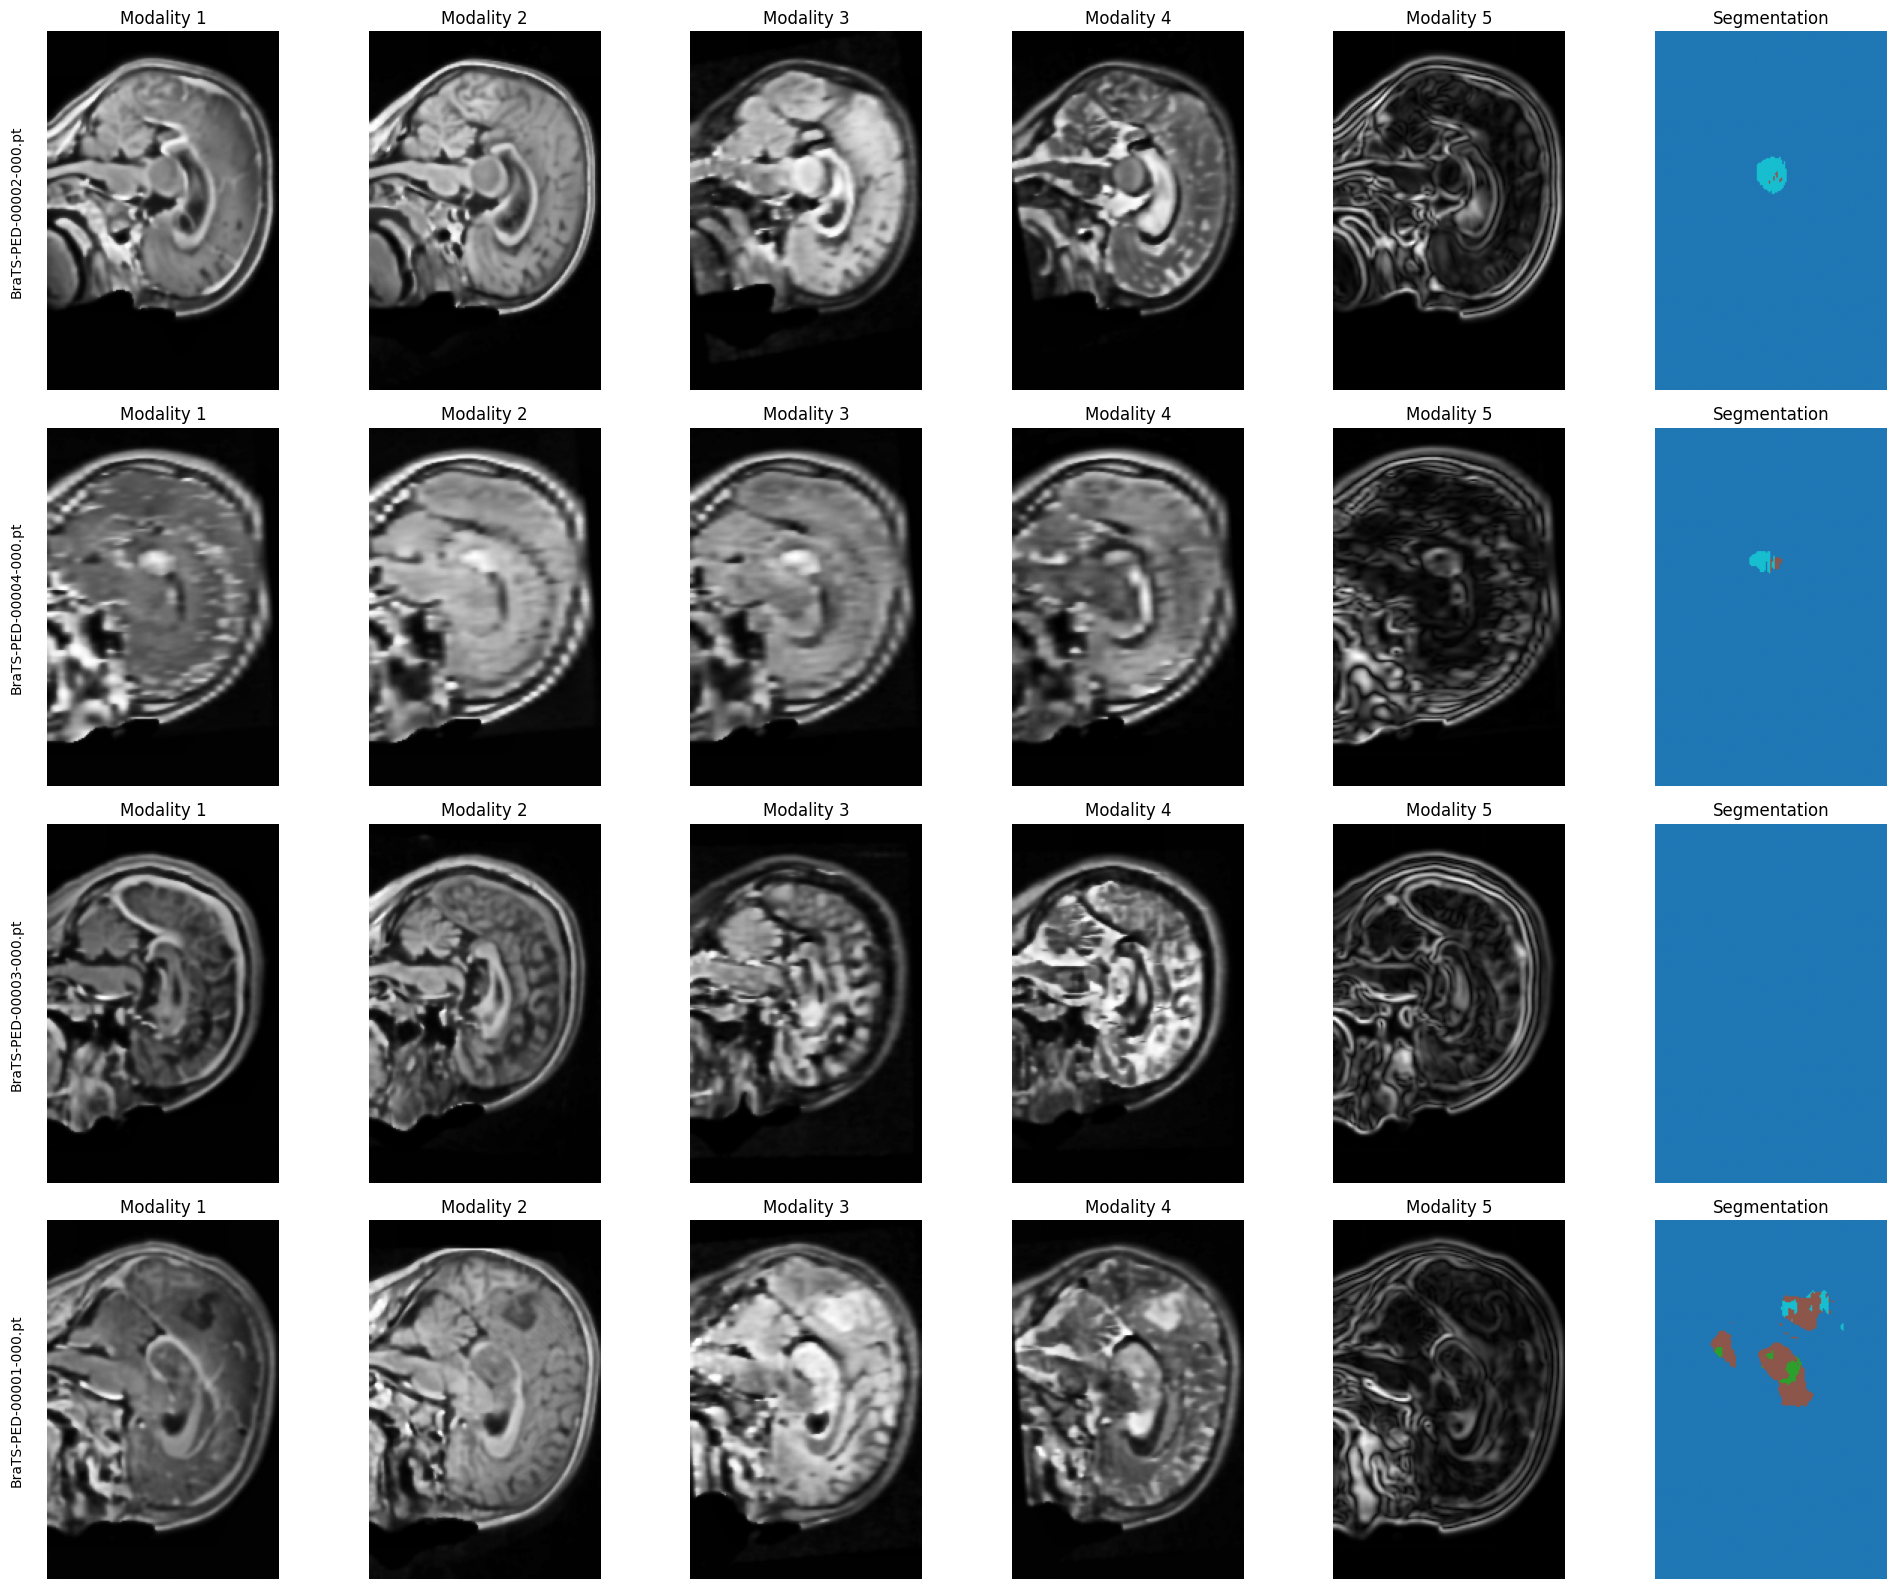


🧠 Initializing DenseTrans model...
Model parameters: 0.60M

=== MODEL LEARNING TEST ===


Learning Test Epoch 1: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=1, dice=0.5]


Epoch 1: Loss=0.9421, Dice=0.2895, Grad Norm=8394.0971


Learning Test Epoch 2: 100%|██████████| 240/240 [02:36<00:00,  1.54it/s, loss=0.533, dice=1]


Epoch 2: Loss=0.8691, Dice=0.4679, Grad Norm=nan


Learning Test Epoch 3: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=nan, dice=1]


Epoch 3: Loss=nan, Dice=0.3895, Grad Norm=nan


Learning Test Epoch 4: 100%|██████████| 240/240 [02:35<00:00,  1.54it/s, loss=nan, dice=2.53e-6]


Epoch 4: Loss=nan, Dice=0.5198, Grad Norm=nan


Learning Test Epoch 5: 100%|██████████| 240/240 [02:36<00:00,  1.53it/s, loss=nan, dice=7.88e-7]


Epoch 5: Loss=nan, Dice=0.5188, Grad Norm=nan

=== MODEL PREDICTION VISUALIZATION ===


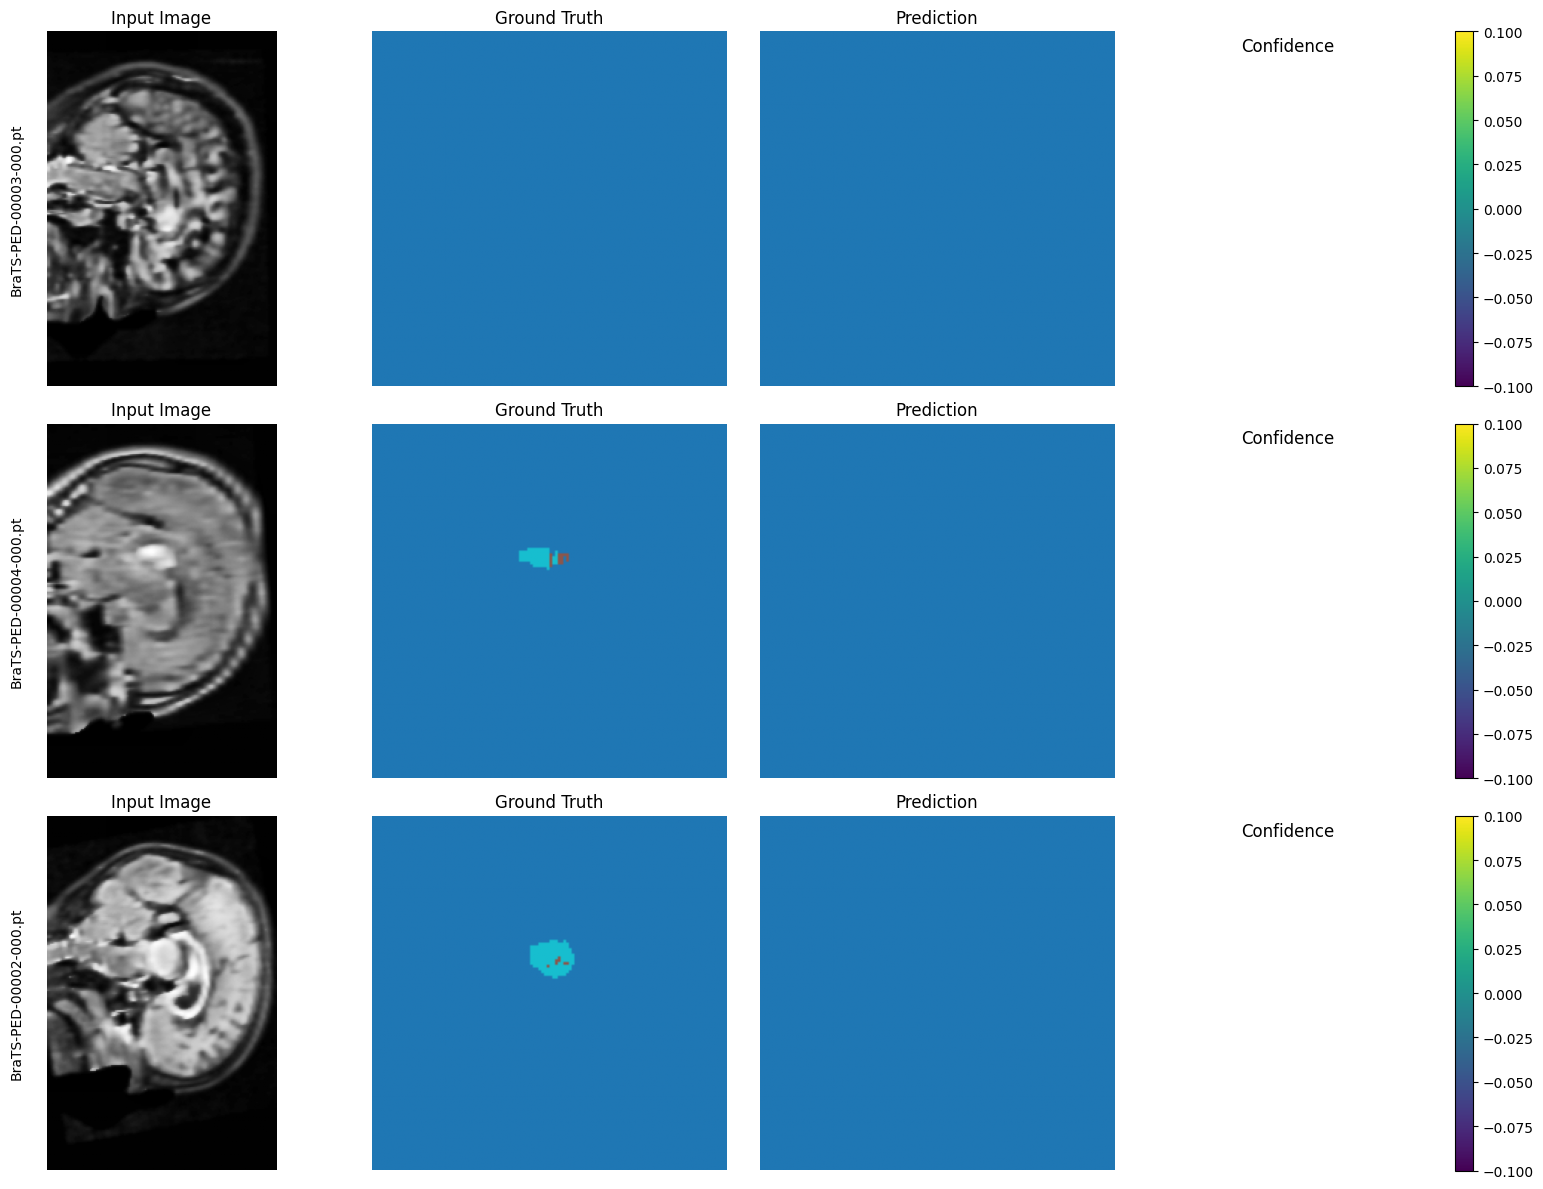


=== LEARNING METRICS VISUALIZATION ===


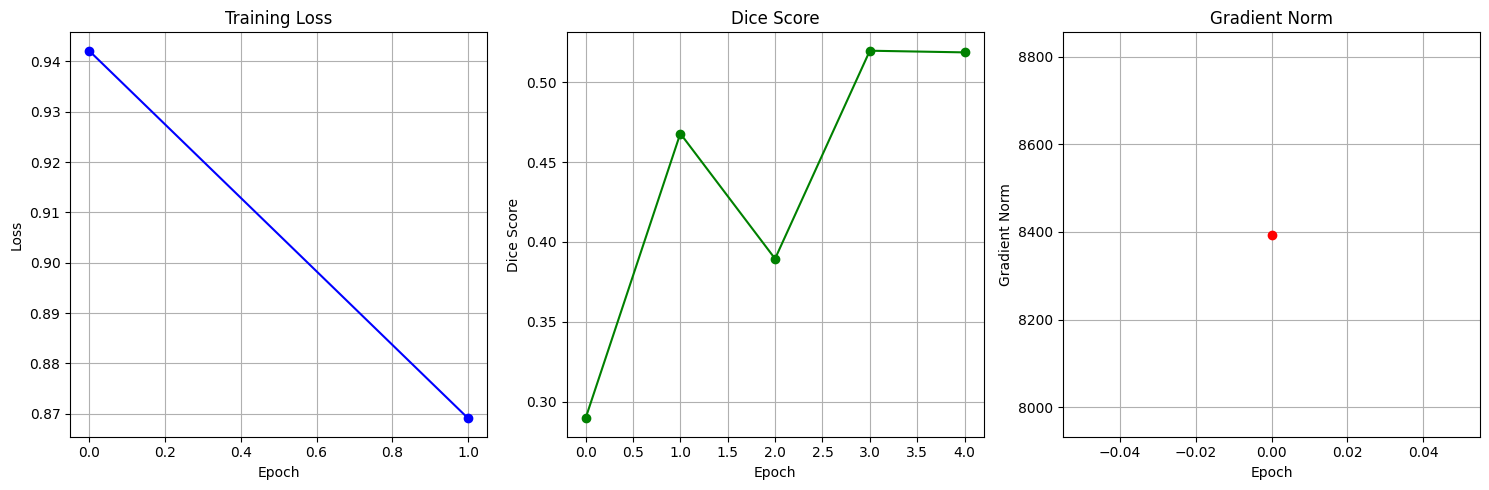


FINAL VALIDATION REPORT

📊 SCAN STATISTICS:
   Total scans processed: 4
   Valid scans: 4 (100.0%)
   Corrupted scans: 0 (0.0%)
   Missing scans: 0 (0.0%)

📏 PREPROCESSING QUALITY:
   Unique image shapes: [(5, 240, 240, 155), (5, 237, 240, 155)]
   Intensity ranges: min=0.00 to max=255.00
   Label classes found: [0, 1, 2, 3, 4]

🧠 MODEL LEARNING ASSESSMENT:
   Initial loss: 0.9421
   Final loss: nan
   Loss reduction: nan%
   Initial Dice: 0.2895
   Final Dice: 0.5188
   Dice improvement: 0.2293

✅ LEARNING QUALITY INDICATORS:
   Model is learning: ✗
   Gradients are stable: ✗
   Loss is decreasing: ✗
   Dice is improving: ✓

🎯 RECOMMENDATIONS:
   ✅ Excellent preprocessing quality - proceed with full training
   ⚠️  Model learning is suboptimal - check data quality

📁 CORRUPTED SCANS:


🔍 ADDITIONAL DATA QUALITY CHECKS:
Checking for potential data leakage...

💾 GPU Memory Usage:
   Allocated: 0.02 GB
   Reserved: 0.51 GB

✅ Validation completed! Check the generated visualizations:
   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import kornia.filters as K
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
SCAN_DIR = "/content/drive/MyDrive/InputScans_Final"
SOURCE_DIR = "/content/drive/MyDrive/BraTS Challenge 2025 - Task 6/BraTS2024-PED-Challenge-TrainingData/BraTS-PEDs2024_Training"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4  # Smaller batch size for validation
NUM_WORKERS = 2
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (128, 128)

# --- Model Architecture (Same as provided) ---
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.InstanceNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.InstanceNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.InstanceNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class SwinTransformerBlock2D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=8):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))
        padded_H, padded_W = H + pad_h, W + pad_w
        windows = rearrange(x, 'b (h p1) (w p2) c -> (b h w) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        attn_windows, _ = self.attn(windows, windows, windows)
        x = rearrange(attn_windows, '(b h w) (p1 p2) c -> b (h p1) (w p2) c', h=padded_H//self.window_size, w=padded_W//self.window_size, p1=self.window_size, p2=self.window_size)
        x = x[:, :H, :W, :].permute(0, 3, 1, 2)
        return x

class UNetPlusPlusNode2D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.conv = nn.Sequential(
            DepthwiseSeparableConv2d(in_channels, out_channels),
            DepthwiseSeparableConv2d(out_channels, out_channels)
        )
        if self.use_swin:
            self.swin = SwinTransformerBlock2D(dim=out_channels)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = inputs[1:]

            if self.attention_gate and len(skip_inputs) > 0:
                g = x_input
                x_skip = skip_inputs[0]
                attended_skip = self.attention_gate(g=g, x=x_skip)
                skip_inputs = [attended_skip] + list(skip_inputs[1:])

            if skip_inputs:
                x_input = torch.cat([*skip_inputs, x_input], dim=1)

            x_conv = self.conv(x_input)
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)
            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)
        return checkpoint(custom_forward, *all_inputs, use_reentrant=True)

class DenseTrans2D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256]
        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

        self.x00 = UNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode2D(filters[2], filters[3])

        self.up10 = self.up(filters[1], filters[0])
        ag10 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = UNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = UNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = AttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = UNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = UNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = AttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = UNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = AttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = UNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03)]
        return self.final3(x03)

# --- Loss Function ---
class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2)
        loss = 0
        for i in range(1, OUT_CHANNELS):
            y_true = targets_one_hot[:, i, :, :]
            y_pred = inputs[:, i, :, :]
            tp = (y_true * y_pred).sum()
            fp = ((1 - y_true) * y_pred).sum()
            fn = (y_true * (1 - y_pred)).sum()
            tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
            focal_tversky = (1 - tversky_index)**self.gamma
            loss += focal_tversky
        return loss / (OUT_CHANNELS - 1)

# --- Dataset for Validation ---
class ValidationDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.slice_map = []

        for i, path in enumerate(file_paths):
            if not os.path.exists(path):
                continue
            try:
                data = torch.load(path, map_location='cpu', weights_only=True)
                num_slices = data['image'].shape[1]
                for j in range(num_slices):
                    self.slice_map.append((i, j))
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]
        path = self.file_paths[scan_idx]

        try:
            data = torch.load(path, map_location='cpu', weights_only=True)
            image_vol = data['image'].float()
            label_vol = data['label'].long()

            target_slice = image_vol[:, slice_idx, :, :]
            target_label = label_vol[slice_idx, :, :]
            prev_slice = image_vol[:, max(0, slice_idx - 1), :, :]
            next_slice = image_vol[:, min(image_vol.shape[1] - 1, slice_idx + 1), :, :]

            stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

            # Resize to expected dimensions
            stacked_slices = nn.functional.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = nn.functional.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

            return stacked_slices, target_label, path, slice_idx

        except Exception as e:
            print(f"Error processing slice {slice_idx} from {path}: {e}")
            # Return dummy data
            return torch.zeros(IN_CHANNELS, *CROP_SIZE), torch.zeros(*CROP_SIZE, dtype=torch.long), path, slice_idx

# --- Validation Functions ---
def validate_scan_integrity(scan_paths):
    """Check basic integrity of preprocessed scans"""
    print("=== SCAN INTEGRITY VALIDATION ===")

    integrity_results = {
        'valid_scans': [],
        'corrupted_scans': [],
        'missing_scans': [],
        'scan_statistics': {}
    }

    for scan_path in tqdm(scan_paths, desc="Validating scan integrity"):
        if not os.path.exists(scan_path):
            integrity_results['missing_scans'].append(scan_path)
            continue

        try:
            data = torch.load(scan_path, map_location='cpu', weights_only=True)

            # Check required keys
            if 'image' not in data or 'label' not in data:
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            image_vol = data['image']
            label_vol = data['label']

            # Check shapes
            if len(image_vol.shape) != 4 or len(label_vol.shape) != 3:
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            # Check for NaN/Inf values
            if torch.isnan(image_vol).any() or torch.isinf(image_vol).any():
                integrity_results['corrupted_scans'].append(scan_path)
                continue

            # Collect statistics
            scan_name = os.path.basename(scan_path)
            integrity_results['scan_statistics'][scan_name] = {
                'image_shape': tuple(image_vol.shape),
                'label_shape': tuple(label_vol.shape),
                'image_range': (float(image_vol.min()), float(image_vol.max())),
                'label_classes': torch.unique(label_vol).tolist(),
                'num_slices': image_vol.shape[1]
            }

            integrity_results['valid_scans'].append(scan_path)

        except Exception as e:
            print(f"Error validating {scan_path}: {e}")
            integrity_results['corrupted_scans'].append(scan_path)

    print(f"Valid scans: {len(integrity_results['valid_scans'])}")
    print(f"Corrupted scans: {len(integrity_results['corrupted_scans'])}")
    print(f"Missing scans: {len(integrity_results['missing_scans'])}")

    return integrity_results

def visualize_scans(scan_paths, num_samples=5):
    """Visualize sample scans to check preprocessing quality"""
    print("\n=== SCAN VISUALIZATION ===")

    sample_paths = random.sample(scan_paths, min(num_samples, len(scan_paths)))

    fig, axes = plt.subplots(len(sample_paths), 6, figsize=(20, 4*len(sample_paths)))
    if len(sample_paths) == 1:
        axes = axes.reshape(1, -1)

    for row, scan_path in enumerate(sample_paths):
        try:
            data = torch.load(scan_path, map_location='cpu', weights_only=True)
            image_vol = data['image'].numpy()
            label_vol = data['label'].numpy()

            # Select middle slice
            mid_slice = image_vol.shape[1] // 2

            # Show different modalities
            for col in range(5):  # 5 modalities
                if col < image_vol.shape[0]:
                    axes[row, col].imshow(image_vol[col, mid_slice], cmap='gray')
                    axes[row, col].set_title(f'Modality {col+1}')
                    axes[row, col].axis('off')

            # Show segmentation
            axes[row, 5].imshow(label_vol[mid_slice], cmap='tab10')
            axes[row, 5].set_title('Segmentation')
            axes[row, 5].axis('off')

            # Add scan name as row label
            scan_name = os.path.basename(scan_path)
            axes[row, 0].text(-0.1, 0.5, scan_name, rotation=90,
                            transform=axes[row, 0].transAxes, ha='right', va='center')

        except Exception as e:
            print(f"Error visualizing {scan_path}: {e}")
            for col in range(6):
                axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:30]}...',
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('scan_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

def test_model_learning(model, scan_paths, num_epochs=5):
    """Test if model can learn from the preprocessed scans"""
    print("\n=== MODEL LEARNING TEST ===")

    # Create dataset and dataloader
    dataset = ValidationDataset(scan_paths[:10])  # Use subset for quick test
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # Initialize optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)
    scaler = GradScaler(enabled=(DEVICE.type != 'cpu'))

    learning_metrics = {
        'epoch_losses': [],
        'epoch_dice_scores': [],
        'gradient_norms': []
    }

    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_dice = 0.0
        gradient_norms = []

        pbar = tqdm(dataloader, desc=f"Learning Test Epoch {epoch+1}")
        for batch_idx, (inputs, targets, paths, slice_ids) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type != 'cpu')):
                outputs = model(inputs)
                if isinstance(outputs, list):
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                    main_output = outputs[-1]
                else:
                    loss = loss_fn(outputs, targets)
                    main_output = outputs

            scaler.scale(loss).backward()

            # Calculate gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
            gradient_norms.append(total_norm)

            scaler.step(optimizer)
            scaler.update()

            # Calculate Dice score
            with torch.no_grad():
                pred_probs = torch.softmax(main_output, dim=1)
                pred_labels = torch.argmax(pred_probs, dim=1)
                dice = calculate_dice_score(pred_labels, targets)
                epoch_dice += dice

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item(), 'dice': dice})

        avg_loss = epoch_loss / len(dataloader)
        avg_dice = epoch_dice / len(dataloader)
        avg_grad_norm = np.mean(gradient_norms)

        learning_metrics['epoch_losses'].append(avg_loss)
        learning_metrics['epoch_dice_scores'].append(avg_dice)
        learning_metrics['gradient_norms'].append(avg_grad_norm)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Dice={avg_dice:.4f}, Grad Norm={avg_grad_norm:.4f}")

    return learning_metrics

def calculate_dice_score(pred, target, smooth=1e-5):
    """Calculate Dice score for segmentation"""
    dice_scores = []
    for class_idx in range(1, OUT_CHANNELS):  # Skip background
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

def visualize_model_predictions(model, scan_paths, num_samples=3):
    """Visualize model predictions on sample data"""
    print("\n=== MODEL PREDICTION VISUALIZATION ===")

    model.eval()
    sample_paths = random.sample(scan_paths, min(num_samples, len(scan_paths)))

    fig, axes = plt.subplots(len(sample_paths), 4, figsize=(16, 4*len(sample_paths)))
    if len(sample_paths) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for row, scan_path in enumerate(sample_paths):
            try:
                # Load and process one slice
                data = torch.load(scan_path, map_location='cpu', weights_only=True)
                image_vol = data['image'].float()
                label_vol = data['label'].long()

                mid_slice = image_vol.shape[1] // 2

                # Create 2.5D input
                target_slice = image_vol[:, mid_slice, :, :]
                prev_slice = image_vol[:, max(0, mid_slice - 1), :, :]
                next_slice = image_vol[:, min(image_vol.shape[1] - 1, mid_slice + 1), :, :]

                stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)
                stacked_slices = nn.functional.interpolate(
                    stacked_slices.unsqueeze(0), size=CROP_SIZE,
                    mode='bilinear', align_corners=False
                )

                target_label = nn.functional.interpolate(
                    label_vol[mid_slice:mid_slice+1].unsqueeze(0).float(),
                    size=CROP_SIZE, mode='nearest'
                ).squeeze().long()

                # Get model prediction
                input_tensor = stacked_slices.to(DEVICE)
                outputs = model(input_tensor)
                if isinstance(outputs, list):
                    prediction = outputs[-1]
                else:
                    prediction = outputs

                pred_probs = torch.softmax(prediction, dim=1)
                pred_labels = torch.argmax(pred_probs, dim=1).cpu().numpy()[0]

                # Visualize
                # Original image (middle modality)
                axes[row, 0].imshow(target_slice[2].numpy(), cmap='gray')
                axes[row, 0].set_title('Input Image')
                axes[row, 0].axis('off')

                # Ground truth
                axes[row, 1].imshow(target_label.numpy(), cmap='tab10')
                axes[row, 1].set_title('Ground Truth')
                axes[row, 1].axis('off')

                # Prediction
                axes[row, 2].imshow(pred_labels, cmap='tab10')
                axes[row, 2].set_title('Prediction')
                axes[row, 2].axis('off')

                # Confidence map (max probability across classes)
                confidence = torch.max(pred_probs, dim=1)[0].cpu().numpy()[0]
                im = axes[row, 3].imshow(confidence, cmap='viridis')
                axes[row, 3].set_title('Confidence')
                axes[row, 3].axis('off')
                plt.colorbar(im, ax=axes[row, 3])

                scan_name = os.path.basename(scan_path)
                axes[row, 0].text(-0.1, 0.5, scan_name, rotation=90,
                                transform=axes[row, 0].transAxes, ha='right', va='center')

            except Exception as e:
                print(f"Error in prediction visualization for {scan_path}: {e}")
                for col in range(4):
                    axes[row, col].text(0.5, 0.5, f'Error: {str(e)[:20]}...',
                                      ha='center', va='center', transform=axes[row, col].transAxes)
                    axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_learning_metrics(learning_metrics):
    """Plot learning curves"""
    print("\n=== LEARNING METRICS VISUALIZATION ===")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loss curve
    axes[0].plot(learning_metrics['epoch_losses'], 'b-o')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)

    # Dice score curve
    axes[1].plot(learning_metrics['epoch_dice_scores'], 'g-o')
    axes[1].set_title('Dice Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].grid(True)

    # Gradient norm curve
    axes[2].plot(learning_metrics['gradient_norms'], 'r-o')
    axes[2].set_title('Gradient Norm')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Gradient Norm')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('learning_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

def generate_final_report(integrity_results, learning_metrics, scan_paths):
    """Generate comprehensive validation report"""
    print("\n" + "="*50)
    print("FINAL VALIDATION REPORT")
    print("="*50)

    total_scans = len(scan_paths)
    valid_scans = len(integrity_results['valid_scans'])
    corrupted_scans = len(integrity_results['corrupted_scans'])
    missing_scans = len(integrity_results['missing_scans'])

    print(f"\n📊 SCAN STATISTICS:")
    print(f"   Total scans processed: {total_scans}")
    print(f"   Valid scans: {valid_scans} ({valid_scans/total_scans*100:.1f}%)")
    print(f"   Corrupted scans: {corrupted_scans} ({corrupted_scans/total_scans*100:.1f}%)")
    print(f"   Missing scans: {missing_scans} ({missing_scans/total_scans*100:.1f}%)")

    if integrity_results['scan_statistics']:
        print(f"\n📏 PREPROCESSING QUALITY:")
        shapes = [stats['image_shape'] for stats in integrity_results['scan_statistics'].values()]
        unique_shapes = list(set(shapes))
        print(f"   Unique image shapes: {unique_shapes}")

        ranges = [stats['image_range'] for stats in integrity_results['scan_statistics'].values()]
        min_values = [r[0] for r in ranges]
        max_values = [r[1] for r in ranges]
        print(f"   Intensity ranges: min={min(min_values):.2f} to max={max(max_values):.2f}")

        all_classes = set()
        for stats in integrity_results['scan_statistics'].values():
            all_classes.update(stats['label_classes'])
        print(f"   Label classes found: {sorted(list(all_classes))}")

    if learning_metrics:
        print(f"\n🧠 MODEL LEARNING ASSESSMENT:")
        initial_loss = learning_metrics['epoch_losses'][0]
        final_loss = learning_metrics['epoch_losses'][-1]
        loss_reduction = (initial_loss - final_loss) / initial_loss * 100

        initial_dice = learning_metrics['epoch_dice_scores'][0]
        final_dice = learning_metrics['epoch_dice_scores'][-1]
        dice_improvement = final_dice - initial_dice

        print(f"   Initial loss: {initial_loss:.4f}")
        print(f"   Final loss: {final_loss:.4f}")
        print(f"   Loss reduction: {loss_reduction:.1f}%")
        print(f"   Initial Dice: {initial_dice:.4f}")
        print(f"   Final Dice: {final_dice:.4f}")
        print(f"   Dice improvement: {dice_improvement:.4f}")

        # Learning assessment
        is_learning = loss_reduction > 10 and dice_improvement > 0.01
        gradient_stable = np.std(learning_metrics['gradient_norms']) < np.mean(learning_metrics['gradient_norms'])

        print(f"\n✅ LEARNING QUALITY INDICATORS:")
        print(f"   Model is learning: {'✓' if is_learning else '✗'}")
        print(f"   Gradients are stable: {'✓' if gradient_stable else '✗'}")
        print(f"   Loss is decreasing: {'✓' if loss_reduction > 0 else '✗'}")
        print(f"   Dice is improving: {'✓' if dice_improvement > 0 else '✗'}")

    print(f"\n🎯 RECOMMENDATIONS:")
    if valid_scans / total_scans >= 0.95:
        print("   ✅ Excellent preprocessing quality - proceed with full training")
    elif valid_scans / total_scans >= 0.90:
        print("   ⚠️  Good preprocessing quality - minor issues detected")
    else:
        print("   ❌ Poor preprocessing quality - investigate corrupted scans")

    if learning_metrics and is_learning:
        print("   ✅ Model shows good learning capacity on preprocessed data")
    elif learning_metrics:
        print("   ⚠️  Model learning is suboptimal - check data quality")

    print(f"\n📁 CORRUPTED SCANS:")
    for scan in integrity_results['corrupted_scans'][:10]:  # Show first 10
        print(f"   - {os.path.basename(scan)}")
    if len(integrity_results['corrupted_scans']) > 10:
        print(f"   ... and {len(integrity_results['corrupted_scans']) - 10} more")

    print("\n" + "="*50)

def main():
    """Main validation pipeline"""
    print("🔍 BRAIN TUMOR SEGMENTATION DATA VALIDATION")
    print(f"📂 Scan directory: {SCAN_DIR}")
    print(f"🖥️  Device: {DEVICE}")

    # Find all .pt files
    scan_pattern = os.path.join(SCAN_DIR, "*.pt")
    all_scan_paths = glob.glob(scan_pattern)

    if not all_scan_paths:
        print(f"❌ No .pt files found in {SCAN_DIR}")
        print("Please check the path and ensure preprocessed files are available.")
        return

    print(f"📊 Found {len(all_scan_paths)} scan files")

    # Step 1: Validate scan integrity
    integrity_results = validate_scan_integrity(all_scan_paths)

    if not integrity_results['valid_scans']:
        print("❌ No valid scans found. Cannot proceed with model testing.")
        return

    # Step 2: Visualize sample scans
    visualize_scans(integrity_results['valid_scans'][:10])

    # Step 3: Initialize model
    print("\n🧠 Initializing DenseTrans model...")
    model = DenseTrans2D(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params/1e6:.2f}M")

    # Step 4: Test model learning
    learning_metrics = test_model_learning(model, integrity_results['valid_scans'])

    # Step 5: Visualize predictions
    visualize_model_predictions(model, integrity_results['valid_scans'][:5])

    # Step 6: Plot learning metrics
    plot_learning_metrics(learning_metrics)

    # Step 7: Generate final report
    generate_final_report(integrity_results, learning_metrics, all_scan_paths)

    # Additional data quality checks
    print("\n🔍 ADDITIONAL DATA QUALITY CHECKS:")

    # Check for data leakage (similar scans)
    print("Checking for potential data leakage...")
    sample_scans = random.sample(integrity_results['valid_scans'], min(5, len(integrity_results['valid_scans'])))

    for i, scan1 in enumerate(sample_scans):
        try:
            data1 = torch.load(scan1, map_location='cpu', weights_only=True)
            image1 = data1['image']

            for j, scan2 in enumerate(sample_scans[i+1:], i+1):
                data2 = torch.load(scan2, map_location='cpu', weights_only=True)
                image2 = data2['image']

                # Simple similarity check (mean squared difference)
                if image1.shape == image2.shape:
                    mse = torch.mean((image1 - image2) ** 2).item()
                    if mse < 0.01:  # Very similar
                        print(f"⚠️  High similarity between {os.path.basename(scan1)} and {os.path.basename(scan2)}: MSE={mse:.6f}")
        except Exception as e:
            print(f"Error in similarity check: {e}")

    # Memory usage check
    try:
        if torch.cuda.is_available():
            print(f"\n💾 GPU Memory Usage:")
            print(f"   Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
            print(f"   Reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")
    except:
        pass

    print(f"\n✅ Validation completed! Check the generated visualizations:")
    print(f"   - scan_visualization.png: Sample scan quality")
    print(f"   - model_predictions.png: Model prediction examples")
    print(f"   - learning_metrics.png: Learning curve analysis")

    # Save detailed results
    results_summary = {
        'total_scans': len(all_scan_paths),
        'valid_scans': len(integrity_results['valid_scans']),
        'corrupted_scans': len(integrity_results['corrupted_scans']),
        'missing_scans': len(integrity_results['missing_scans']),
        'learning_metrics': learning_metrics,
        'corrupted_files': [os.path.basename(f) for f in integrity_results['corrupted_scans']]
    }

    import json
    with open('validation_results.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"   - validation_results.json: Detailed results summary")

if __name__ == "__main__":
    main()

# Deeper model - 15M parameters

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Memory Management Settings for L4 GPU (22.5GB VRAM, 58GB RAM)
MAX_CACHED_SCANS = 3  # Cache only 3 scans in memory at once
MEMORY_CLEANUP_FREQ = 50  # Clean memory every 50 batches
PREFETCH_FACTOR = 2  # Prefetch factor for DataLoader

# Training Hyperparameters - Optimized for L4 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 300  # Increased for better convergence
INITIAL_LR = 8e-5  # Further reduced for stability
MAX_LR = 3e-4  # For OneCycle scheduler
BATCH_SIZE = 6  # Reduced for L4 GPU memory constraints
NUM_WORKERS = 2  # Reduced to save RAM
WEIGHT_DECAY = 5e-7  # Further reduced
EARLY_STOPPING_PATIENCE = 25
SCANS_PER_EPOCH = 6  # Reduced for memory efficiency
VAL_SCANS_PER_EPOCH = 3

# Enhanced 2.5D processing
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (144, 144)  # Slightly reduced for memory efficiency
DROPOUT_RATE = 0.12
GRADIENT_CLIP_VAL = 0.8  # Reduced for better stability

# --- Enhanced Data Augmentation ---
class AdvancedAugmentation:
    def __init__(self, crop_size=(144, 144)):
        self.crop_size = crop_size

    def random_crop_2d(self, img, label):
        h, w = img.shape[1:]
        ch, cw = self.crop_size

        if h < ch or w < cw:
            pad_h = max(0, ch - h)
            pad_w = max(0, cw - w)
            img = F.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            label = F.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            h, w = img.shape[1:]

        y = random.randint(0, max(0, h - ch))
        x = random.randint(0, max(0, w - cw))
        return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

    def apply_augmentation(self, img, label, is_training=True):
        if not is_training:
            # For validation, just resize
            img = F.interpolate(img.unsqueeze(0), size=self.crop_size,
                              mode='bilinear', align_corners=False).squeeze(0)
            label = F.interpolate(label.unsqueeze(0).unsqueeze(0).float(),
                                size=self.crop_size, mode='nearest').squeeze(0).squeeze(0).long()
            return img, label

        # Random crop
        img, label = self.random_crop_2d(img, label)

        # Random horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, [2])
            label = torch.flip(label, [1])

        # Random rotation (small angles)
        if random.random() > 0.7:
            angle = random.uniform(-15, 15)
            img = self.rotate_tensor(img, angle)
            label = self.rotate_tensor(label.unsqueeze(0).float(), angle, is_label=True).squeeze(0).long()

        # Intensity augmentation
        if random.random() > 0.6:
            # Random gamma correction
            gamma = random.uniform(0.8, 1.2)
            img = torch.pow(img.clamp(min=0) + 1e-7, gamma)

            # Random noise
            if random.random() > 0.8:
                noise = torch.randn_like(img) * 0.05
                img = img + noise

        return img, label

    def rotate_tensor(self, tensor, angle, is_label=False):
        # Simple rotation using grid_sample
        angle_rad = torch.tensor(angle * np.pi / 180.0)
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)

        # Create rotation matrix
        theta = torch.tensor([[cos_a, -sin_a, 0],
                            [sin_a, cos_a, 0]], dtype=torch.float32)

        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            squeeze_back = True
        else:
            squeeze_back = False

        grid = F.affine_grid(theta.unsqueeze(0), tensor.size(), align_corners=False)
        mode = 'nearest' if is_label else 'bilinear'
        rotated = F.grid_sample(tensor, grid, mode=mode, align_corners=False)

        if squeeze_back:
            rotated = rotated.squeeze(0)

        return rotated

class MemoryEfficientBraTSDataset(Dataset):
    """Memory-efficient dataset that streams from Google Drive with LRU cache"""
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.scan_cache = {}  # LRU cache for scans
        self.cache_order = []  # Track access order for LRU
        self.augmenter = AdvancedAugmentation(CROP_SIZE)

        print(f"🔄 Initializing memory-efficient dataset with {len(file_paths)} files...")

        # Build slice map without loading data
        for i, path in enumerate(tqdm(file_paths, desc="Building slice map")):
            if not os.path.exists(path):
                print(f"⚠️ File not found: {path}")
                continue

            try:
                # Quick check of scan dimensions without fully loading
                data = torch.load(path, map_location='cpu', weights_only=True)
                num_slices = data['image'].shape[1]

                # Skip slices with minimal brain content (edges)
                start_slice = max(5, num_slices // 10)
                end_slice = min(num_slices - 5, 9 * num_slices // 10)

                for j in range(start_slice, end_slice):
                    self.slice_map.append((i, j))

                # Immediately free memory
                del data
                gc.collect()

            except Exception as e:
                print(f"⚠️ Error checking {path}: {e}")
                continue

        print(f"✅ Dataset initialized with {len(self.slice_map)} slices from {len(file_paths)} scans")

    def _load_scan_with_cache(self, scan_idx):
        """Load scan with LRU caching to manage memory"""
        if scan_idx in self.scan_cache:
            # Move to end (most recently used)
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        # Load new scan
        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu', weights_only=True)

            # Add to cache
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)

            # Maintain cache size limit
            while len(self.scan_cache) > MAX_CACHED_SCANS:
                oldest_scan = self.cache_order.pop(0)
                if oldest_scan in self.scan_cache:
                    del self.scan_cache[oldest_scan]

            # Periodic memory cleanup
            if len(self.cache_order) % MEMORY_CLEANUP_FREQ == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            return data

        except Exception as e:
            print(f"❌ Error loading {path}: {e}")
            # Return dummy data if loading fails
            return {
                'image': torch.zeros(5, 100, 240, 240),
                'label': torch.zeros(100, 240, 240, dtype=torch.long)
            }

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # Load scan data with caching
        scan_data = self._load_scan_with_cache(scan_idx)

        image_vol = scan_data['image'].float()
        label_vol = scan_data['label'].long()

        # Handle potential dimension mismatches
        if slice_idx >= image_vol.shape[1]:
            slice_idx = min(slice_idx, image_vol.shape[1] - 1)

        # Get 2.5D slice context with bounds checking
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        prev_idx = max(0, slice_idx - 1)
        next_idx = min(image_vol.shape[1] - 1, slice_idx + 1)

        prev_slice = image_vol[:, prev_idx, :, :]
        next_slice = image_vol[:, next_idx, :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        # Enhanced normalization with outlier handling
        stacked_slices = torch.clamp(stacked_slices, 0, 255)

        # Robust normalization per modality
        for i in range(0, stacked_slices.shape[0], 3):  # Every 3 channels (prev, curr, next)
            modality_slices = stacked_slices[i:i+3]
            if modality_slices.max() > 0:
                # Percentile-based normalization for robustness
                p99 = torch.quantile(modality_slices, 0.99)
                p1 = torch.quantile(modality_slices, 0.01)
                modality_slices = torch.clamp(modality_slices, p1, p99)
                modality_slices = (modality_slices - p1) / (p99 - p1 + 1e-8)
                stacked_slices[i:i+3] = modality_slices

        # Apply augmentation
        try:
            stacked_slices, target_label = self.augmenter.apply_augmentation(
                stacked_slices, target_label, self.transform)
        except Exception as e:
            print(f"⚠️ Augmentation error: {e}, using fallback")
            # Fallback: simple resize
            stacked_slices = F.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = F.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

    def cleanup_cache(self):
        """Manual cache cleanup"""
        self.scan_cache.clear()
        self.cache_order.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# --- Enhanced Architecture Components ---
class LayerNorm2d(nn.Module):
    """2D Layer Normalization for better training stability"""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x + self.bias.unsqueeze(-1).unsqueeze(-1)
        return x

class EnhancedDepthwiseSeparableConv2d(nn.Module):
    """Enhanced depthwise separable convolution with better normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                 stride=stride, padding=kernel_size//2 * dilation,
                                 groups=in_channels, dilation=dilation, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm1 = LayerNorm2d(in_channels)
        self.norm2 = LayerNorm2d(out_channels)
        self.act = nn.GELU()  # Better activation than ReLU
        self.dropout = nn.Dropout2d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate(nn.Module):
    """Enhanced attention gate with multi-scale processing"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )

        # Multi-scale processing
        self.conv3x3 = nn.Conv2d(F_int, F_int//2, 3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(F_int, F_int//2, 5, padding=2, bias=False)

        self.psi = nn.Sequential(
            LayerNorm2d(F_int),
            nn.Conv2d(F_int, 1, 1, bias=True),
            nn.Sigmoid()
        )
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Multi-scale attention
        psi_input = self.gelu(g1 + x1)
        psi_3 = self.conv3x3(psi_input)
        psi_5 = self.conv5x5(psi_input)
        psi = torch.cat([psi_3, psi_5], dim=1)

        psi = self.psi(psi)
        return x * psi

class EnhancedSwinTransformerBlock2D(nn.Module):
    """Enhanced Swin Transformer with better stability"""
    def __init__(self, dim, num_heads=8, window_size=8, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm2d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE,
                                        batch_first=True, bias=False)

        self.norm2 = LayerNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, mlp_hidden_dim, 1, bias=False),
            LayerNorm2d(mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(mlp_hidden_dim, dim, 1, bias=False),
            nn.Dropout2d(DROPOUT_RATE)
        )

        # Learnable scale parameters for residual connections
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x

        # Attention branch
        x_norm = self.norm1(x)
        x_windows = self._partition_windows(x_norm)
        attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
        x_attn = self._merge_windows(attn_windows, H, W)
        x = shortcut + self.gamma1 * x_attn

        # MLP branch
        shortcut2 = x
        x_mlp = self.mlp(self.norm2(x))
        x = shortcut2 + self.gamma2 * x_mlp

        return x

    def _partition_windows(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # B, H, W, C

        # Pad if needed
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        H_pad, W_pad = H + pad_h, W + pad_w
        x = x.view(B, H_pad // self.window_size, self.window_size,
                  W_pad // self.window_size, self.window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        windows = windows.view(-1, self.window_size * self.window_size, C)
        return windows

    def _merge_windows(self, windows, H, W):
        B = windows.shape[0] // ((H + self.window_size - 1) // self.window_size *
                                (W + self.window_size - 1) // self.window_size)
        H_pad = ((H + self.window_size - 1) // self.window_size) * self.window_size
        W_pad = ((W + self.window_size - 1) // self.window_size) * self.window_size

        x = windows.view(B, H_pad // self.window_size, W_pad // self.window_size,
                        self.window_size, self.window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(B, H_pad, W_pad, -1)

        # Remove padding
        if H_pad > H or W_pad > W:
            x = x[:, :H, :W, :]

        x = x.permute(0, 3, 1, 2)  # B, C, H, W
        return x

class EnhancedUNetPlusPlusNode2D(nn.Module):
    """Enhanced UNet++ node with better skip connections"""
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None,
                 use_deep_supervision=False):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.use_deep_supervision = use_deep_supervision

        # Enhanced convolution blocks
        self.conv1 = EnhancedDepthwiseSeparableConv2d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv2d(out_channels, out_channels)

        # Residual connection for same channel sizes
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = EnhancedSwinTransformerBlock2D(dim=out_channels)

        # Additional features for deep supervision
        if use_deep_supervision:
            self.aux_conv = nn.Conv2d(out_channels, out_channels//2, 3, padding=1)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = list(inputs[1:]) if len(inputs) > 1 else []

            # Apply attention to skip connections
            if self.attention_gate and skip_inputs:
                attended_skips = []
                for skip in skip_inputs:
                    if skip.shape[1] == x_input.shape[1]:  # Same channel size
                        attended_skip = self.attention_gate(g=x_input, x=skip)
                        attended_skips.append(attended_skip)
                    else:
                        attended_skips.append(skip)
                skip_inputs = attended_skips

            # Concatenate all inputs
            if skip_inputs:
                x_cat = torch.cat(skip_inputs + [x_input], dim=1)
            else:
                x_cat = x_input

            # Apply convolutions with residual connection
            residual = self.residual(x_cat)
            x_conv = self.conv1(x_cat)
            x_conv = self.conv2(x_conv) + residual

            # Apply Swin transformer if enabled
            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)

            return x_conv

        # Prepare inputs for checkpointing
        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class EnhancedDenseTrans2D(nn.Module):
    """Enhanced DenseTrans architecture with deeper network and better stability"""
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision

        # Increased filter sizes for better capacity (optimized for L4)
        filters = [64, 128, 256, 512, 1024]  # Reduced from [48, 96, 192, 384, 768]

        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, bias=False)

        # Encoder path with enhanced nodes
        self.x00 = EnhancedUNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = EnhancedUNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = EnhancedUNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = EnhancedUNetPlusPlusNode2D(filters[2], filters[3])
        self.x40 = EnhancedUNetPlusPlusNode2D(filters[3], filters[4])  # Additional deeper layer

        # Decoder path with attention gates
        self.up10 = self.up(filters[1], filters[0])
        ag10 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = EnhancedUNetPlusPlusNode2D(filters[0]*2, filters[0], use_swin=True, attention_gate=ag10)

        self.up20 = self.up(filters[2], filters[1])
        ag20 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = EnhancedUNetPlusPlusNode2D(filters[1]*2, filters[1], use_swin=True, attention_gate=ag20)

        self.up30 = self.up(filters[3], filters[2])
        ag30 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = EnhancedUNetPlusPlusNode2D(filters[2]*2, filters[2], use_swin=True, attention_gate=ag30)

        self.up40 = self.up(filters[4], filters[3])
        ag40 = MultiScaleAttentionGate(F_g=filters[3], F_l=filters[3], F_int=filters[3]//2)
        self.x31 = EnhancedUNetPlusPlusNode2D(filters[3]*2, filters[3], use_swin=True, attention_gate=ag40)

        # Additional skip connections
        self.up11 = self.up(filters[1], filters[0])
        ag11 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = EnhancedUNetPlusPlusNode2D(filters[0]*3, filters[0], use_swin=True, attention_gate=ag11)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = EnhancedUNetPlusPlusNode2D(filters[1]*3, filters[1], use_swin=True, attention_gate=ag21)

        self.up31 = self.up(filters[3], filters[2])
        ag31 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x22 = EnhancedUNetPlusPlusNode2D(filters[2]*3, filters[2], use_swin=True, attention_gate=ag31)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = EnhancedUNetPlusPlusNode2D(filters[0]*4, filters[0], use_swin=True, attention_gate=ag12)

        self.up22 = self.up(filters[2], filters[1])
        ag22 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x13 = EnhancedUNetPlusPlusNode2D(filters[1]*4, filters[1], use_swin=True, attention_gate=ag22)

        self.up13 = self.up(filters[1], filters[0])
        ag13 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x04 = EnhancedUNetPlusPlusNode2D(filters[0]*5, filters[0], use_swin=True, attention_gate=ag13)

        # Output heads with better final processing
        self.final1 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final2 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final3 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )
        self.final4 = nn.Sequential(
            nn.Conv2d(filters[0], filters[0]//2, 3, padding=1, bias=False),
            LayerNorm2d(filters[0]//2),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(filters[0]//2, out_channels, 1)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Proper weight initialization for training stability"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Use 'relu' for kaiming initialization (compatible with GELU)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, LayerNorm2d)):
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder path
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x20 = self.x20(self.down(x10))
        x30 = self.x30(self.down(x20))
        x40 = self.x40(self.down(x30))

        # First level decoder
        x31 = self.x31(self.up40(x40), [x30])
        x21 = self.x21(self.up30(x31), [x20])
        x11 = self.x11(self.up20(x21), [x10])
        x01 = self.x01(self.up10(x11), [x00])

        # Second level decoder
        x22 = self.x22(self.up31(x31), [x20, x21])
        x12 = self.x12(self.up21(x22), [x10, x11])
        x02 = self.x02(self.up11(x12), [x00, x01])

        # Third level decoder
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x03 = self.x03(self.up12(x13), [x00, x01, x02])

        # Fourth level decoder
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- Enhanced Loss Functions ---
class StableBoundaryLoss(nn.Module):
    """Numerically stable boundary loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Ensure numerical stability
        inputs = torch.softmax(inputs, dim=1)
        inputs = torch.clamp(inputs, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        # Use Sobel filters for more stable gradient computation
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(targets.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(targets.device)

        boundary_maps = []
        for i in range(OUT_CHANNELS):
            target_class = targets_one_hot[:, i:i+1, :, :]
            grad_x = F.conv2d(target_class, sobel_x, padding=1)
            grad_y = F.conv2d(target_class, sobel_y, padding=1)
            boundary = torch.sqrt(grad_x**2 + grad_y**2 + self.smooth)
            boundary_maps.append(boundary)

        boundary_mask = torch.cat(boundary_maps, dim=1)
        boundary_mask = (boundary_mask > 0.1).float()

        # Focus on boundary regions
        inputs_boundary = inputs * boundary_mask
        targets_boundary = targets_one_hot * boundary_mask

        # Compute Dice loss on boundaries
        dims = (2, 3)
        intersection = torch.sum(inputs_boundary * targets_boundary, dims)
        union = torch.sum(inputs_boundary + targets_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        boundary_loss = 1. - dice_score.mean()

        return boundary_loss

class EnhancedCompositeLoss(nn.Module):
    """Enhanced composite loss with numerical stability"""
    def __init__(self, focal_weight=0.6, dice_weight=0.3, boundary_weight=0.1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight

        self.focal_loss = StableFocalLoss()
        self.dice_loss = StableDiceLoss()
        self.boundary_loss = StableBoundaryLoss()

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        boundary = self.boundary_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.boundary_weight * boundary)

        return total_loss

class StableFocalLoss(nn.Module):
    """Numerically stable focal loss"""
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-8):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply softmax and ensure numerical stability
        pred = F.softmax(inputs, dim=1)
        pred = torch.clamp(pred, min=self.smooth, max=1.0-self.smooth)

        # Convert targets to one-hot
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        # Compute focal loss
        ce_loss = -targets_one_hot * torch.log(pred)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        return focal_loss.mean()

class StableDiceLoss(nn.Module):
    """Numerically stable dice loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        dice_losses = []
        for i in range(1, OUT_CHANNELS):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_losses.append(1 - dice)

        return torch.stack(dice_losses).mean()

# --- Enhanced Metrics ---
def get_stable_hausdorff_score(pred_np, target_np):
    """Numerically stable Hausdorff distance computation"""
    h95_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)

        if len(pred_coords) > 0 and len(target_coords) > 0:
            try:
                h1 = directed_hausdorff(pred_coords, target_coords)[0]
                h2 = directed_hausdorff(target_coords, pred_coords)[0]
                h95_scores.append(max(h1, h2))
            except:
                h95_scores.append(0.0)
        else:
            h95_scores.append(0.0)

    return np.mean(h95_scores) if h95_scores else 0.0

def get_enhanced_dice_score(pred, target):
    """Enhanced dice score computation with numerical stability"""
    smooth = 1e-6
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    dice_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

# --- Training Utilities ---
class ModelEMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# --- Memory Management Utilities ---
def get_memory_info():
    """Get current memory usage information"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        return f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB"
    return "GPU not available"

def cleanup_memory():
    """Comprehensive memory cleanup"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# --- Enhanced Training Loop with Memory Management ---
def main():
    print("🚀 Enhanced DenseTrans 2.5D Training with Memory Management")
    print(f"💾 {get_memory_info()}")

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    # Enable optimizations for L4 GPU
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        # Set memory allocation strategy
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    # Check data availability
    if not os.path.exists(DATA_DIR):
        print(f"❌ ERROR: Data directory not found: {DATA_DIR}")
        print("Please ensure your Google Drive is mounted and the path is correct.")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"❌ ERROR: No .pt files found in {DATA_DIR}")
        return

    print(f"📁 Found {len(all_files)} scan files")

    # Memory-aware data split
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"📊 Data Split: {len(train_files)} training scans, {len(val_files)} validation scans")

    # Initialize enhanced model with memory considerations
    print("🏗️ Initializing model...")
    model = EnhancedDenseTrans2D(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        deep_supervision=True
    ).to(DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model: {trainable_params/1e6:.2f}M trainable parameters ({total_params/1e6:.2f}M total)")
    print(f"💾 {get_memory_info()}")

    # Enhanced optimizer with conservative settings for L4
    optimizer = optim.AdamW(
        model.parameters(),
        lr=INITIAL_LR,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Conservative learning rate schedule for L4
    total_steps = EPOCHS * SCANS_PER_EPOCH * 50  # Approximate steps
    scheduler = OneCycleLR(
        optimizer,
        max_lr=MAX_LR,
        total_steps=total_steps,
        pct_start=0.15,  # Longer warmup
        anneal_strategy='cos',
        div_factor=10.0,
        final_div_factor=100.0
    )

    # Enhanced loss function
    loss_fn = EnhancedCompositeLoss().to(DEVICE)

    # Mixed precision scaler with conservative settings
    scaler = GradScaler(enabled=(DEVICE.type == 'cuda'), init_scale=2**10)

    # Model EMA for better stability
    ema = ModelEMA(model, decay=0.9998)

    # Training state
    best_val_dice = 0.0
    patience_counter = 0

    print(f"🔧 Training Configuration (L4 Optimized):")
    print(f"   Device: {DEVICE}")
    print(f"   Batch Size: {BATCH_SIZE}")
    print(f"   Initial LR: {INITIAL_LR}")
    print(f"   Max LR: {MAX_LR}")
    print(f"   Gradient Clipping: {GRADIENT_CLIP_VAL}")
    print(f"   Max Cached Scans: {MAX_CACHED_SCANS}")
    print(f"   Crop Size: {CROP_SIZE}")

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        print(f"💾 {get_memory_info()}")

        # Training phase with memory management
        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_train_files, transform=True)

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=False  # Disable for memory efficiency
        )

        model.train()
        train_loss = 0.0
        train_dice = 0.0
        batch_count = 0

        train_pbar = tqdm(train_loader, desc=f"🏋️ Training", leave=False)

        for batch_idx, (inputs, targets) in enumerate(train_pbar):
            try:
                inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)

                    # Deep supervision loss
                    if isinstance(outputs, list):
                        loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                        main_output = outputs[-1]
                    else:
                        loss = loss_fn(outputs, targets)
                        main_output = outputs

                # Check for NaN loss
                if not torch.isfinite(loss):
                    print(f"⚠️ NaN loss detected at epoch {epoch+1}, batch {batch_idx}, skipping...")
                    continue

                # Backward pass with gradient scaling
                scaler.scale(loss).backward()

                # Gradient clipping for stability
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)

                # Check for NaN gradients
                if not torch.isfinite(grad_norm):
                    print(f"⚠️ NaN gradients at epoch {epoch+1}, batch {batch_idx}, skipping...")
                    optimizer.zero_grad(set_to_none=True)
                    continue

                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                # Update EMA
                ema.update()

                # Compute metrics
                with torch.no_grad():
                    batch_dice = get_enhanced_dice_score(main_output.detach(), targets)

                train_loss += loss.item()
                train_dice += batch_dice
                batch_count += 1

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'dice': f'{batch_dice:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.6f}',
                    'grad': f'{grad_norm:.2f}'
                })

                # Periodic memory cleanup
                if batch_idx % MEMORY_CLEANUP_FREQ == 0 and batch_idx > 0:
                    cleanup_memory()

                # Free intermediate tensors
                del inputs, targets, outputs, loss
                if 'main_output' in locals():
                    del main_output

            except Exception as e:
                print(f"⚠️ Error in training batch {batch_idx}: {e}")
                cleanup_memory()
                continue

        # Cleanup training data
        train_dataset.cleanup_cache()
        del train_dataset, train_loader
        cleanup_memory()

        # Validation phase with memory management
        model.eval()
        ema.apply_shadow()  # Use EMA weights for validation

        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_val_files, transform=False)
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=False
        )

        val_loss, val_dice = 0.0, 0.0
        val_batch_count = 0
        val_pbar = tqdm(val_loader, desc=f"🔍 Validation", leave=False)

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_pbar):
                try:
                    inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                    targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                    with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                        outputs = model(inputs)

                        if isinstance(outputs, list):
                            loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)
                            main_output = outputs[-1]
                        else:
                            loss = loss_fn(outputs, targets)
                            main_output = outputs

                    if torch.isfinite(loss):
                        val_loss += loss.item()
                        batch_dice = get_enhanced_dice_score(main_output, targets)
                        val_dice += batch_dice
                        val_batch_count += 1

                    val_pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'dice': f'{batch_dice:.4f}' if 'batch_dice' in locals() else '0.0'
                    })

                    # Free memory
                    del inputs, targets, outputs, loss
                    if 'main_output' in locals():
                        del main_output

                except Exception as e:
                    print(f"⚠️ Error in validation batch {batch_idx}: {e}")
                    continue

        ema.restore()  # Restore original weights

        # Cleanup validation data
        val_dataset.cleanup_cache()
        del val_dataset, val_loader
        cleanup_memory()

        # Calculate epoch metrics
        if batch_count > 0 and val_batch_count > 0:
            avg_train_loss = train_loss / batch_count
            avg_val_loss = val_loss / val_batch_count
            avg_train_dice = train_dice / batch_count
            avg_val_dice = val_dice / val_batch_count

            current_lr = scheduler.get_last_lr()[0]

            print(f'📈 Epoch {epoch+1:03d} | '
                  f'LR: {current_lr:.6f} | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} | '
                  f'Train Dice: {avg_train_dice:.4f} | '
                  f'Val Dice: {avg_val_dice:.4f}')

            # Save best model based on validation Dice score
            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0

                # Save model with EMA weights
                ema.apply_shadow()
                try:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_val_dice': best_val_dice,
                        'ema_state_dict': ema.shadow
                    }, MODEL_SAVE_PATH)
                    print(f"✅ Validation Dice improved to {best_val_dice:.4f}. Model saved!")
                except Exception as e:
                    print(f"⚠️ Error saving model: {e}")
                finally:
                    ema.restore()

            else:
                patience_counter += 1
                print(f"⏳ No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            # Early stopping
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping triggered. Training finished.")
                break
        else:
            print("⚠️ No valid batches processed in this epoch, skipping metrics calculation")

        # Additional memory cleanup at epoch end
        cleanup_memory()
        print(f"💾 End of epoch: {get_memory_info()}")

    print("🎉 Training completed!")
    print(f"🏆 Best validation Dice score: {best_val_dice:.4f}")
    print(f"💾 Final: {get_memory_info()}")

if __name__ == '__main__':
    main()

🚀 Enhanced DenseTrans 2.5D Training with Memory Management
💾 GPU Memory - Allocated: 0.11GB, Reserved: 12.04GB
📁 Found 260 scan files
📊 Data Split: 208 training scans, 52 validation scans
🏗️ Initializing model...
🧠 Model: 17.17M trainable parameters (17.17M total)
💾 GPU Memory - Allocated: 0.17GB, Reserved: 12.04GB
🔧 Training Configuration (L4 Optimized):
   Device: cuda
   Batch Size: 6
   Initial LR: 8e-05
   Max LR: 0.0003
   Gradient Clipping: 0.8
   Max Cached Scans: 3
   Crop Size: (144, 144)

🔄 Epoch 1/300
💾 GPU Memory - Allocated: 0.24GB, Reserved: 12.04GB
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


✅ Dataset initialized with 1049 slices from 6 scans


🏋️ Training:   1%|          | 1/175 [00:03<09:02,  3.12s/it]

⚠️ Error in training batch 0: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 1: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


🏋️ Training:   2%|▏         | 3/175 [00:03<02:48,  1.02it/s]

⚠️ Error in training batch 2: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 3: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


🏋️ Training:   3%|▎         | 5/175 [00:05<02:41,  1.06it/s]

⚠️ Error in training batch 4: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600
⚠️ Error in training batch 5: shape '[5, 5, 5, 8, 8, -1]' is invalid for input of size 2457600


KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from einops import rearrange
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration & Hyperparameters ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_final.pt"

# Memory Management Settings for L4 GPU (22.5GB VRAM, 58GB RAM)
MAX_CACHED_SCANS = 3  # Cache only 3 scans in memory at once
MEMORY_CLEANUP_FREQ = 50  # Clean memory every 50 batches
PREFETCH_FACTOR = 2  # Prefetch factor for DataLoader

# Training Hyperparameters - Optimized for L4 GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 300  # Increased for better convergence
INITIAL_LR = 8e-5  # Further reduced for stability
MAX_LR = 3e-4  # For OneCycle scheduler
BATCH_SIZE = 6  # Reduced for L4 GPU memory constraints
NUM_WORKERS = 2  # Reduced to save RAM
WEIGHT_DECAY = 5e-7  # Further reduced
EARLY_STOPPING_PATIENCE = 25
SCANS_PER_EPOCH = 6  # Reduced for memory efficiency
VAL_SCANS_PER_EPOCH = 3

# Enhanced 2.5D processing
IN_CHANNELS = 15  # 5 modalities * 3 slices
OUT_CHANNELS = 5  # 4 labels + 1 background
CROP_SIZE = (144, 144)  # Slightly reduced for memory efficiency
DROPOUT_RATE = 0.12
GRADIENT_CLIP_VAL = 0.8  # Reduced for better stability

# --- Enhanced Data Augmentation ---
class AdvancedAugmentation:
    def __init__(self, crop_size=(144, 144)):
        self.crop_size = crop_size

    def random_crop_2d(self, img, label):
        h, w = img.shape[1:]
        ch, cw = self.crop_size

        if h < ch or w < cw:
            pad_h = max(0, ch - h)
            pad_w = max(0, cw - w)
            img = F.pad(img, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            label = F.pad(label, (pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2))
            h, w = img.shape[1:]

        y = random.randint(0, max(0, h - ch))
        x = random.randint(0, max(0, w - cw))
        return img[:, y:y+ch, x:x+cw], label[y:y+ch, x:x+cw]

    def apply_augmentation(self, img, label, is_training=True):
        if not is_training:
            # For validation, just resize
            img = F.interpolate(img.unsqueeze(0), size=self.crop_size,
                              mode='bilinear', align_corners=False).squeeze(0)
            label = F.interpolate(label.unsqueeze(0).unsqueeze(0).float(),
                                size=self.crop_size, mode='nearest').squeeze(0).squeeze(0).long()
            return img, label

        # Random crop
        img, label = self.random_crop_2d(img, label)

        # Random horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, [2])
            label = torch.flip(label, [1])

        # Random rotation (small angles)
        if random.random() > 0.7:
            angle = random.uniform(-15, 15)
            img = self.rotate_tensor(img, angle)
            label = self.rotate_tensor(label.unsqueeze(0).float(), angle, is_label=True).squeeze(0).long()

        # Intensity augmentation
        if random.random() > 0.6:
            # Random gamma correction
            gamma = random.uniform(0.8, 1.2)
            img = torch.pow(img.clamp(min=0) + 1e-7, gamma)

            # Random noise
            if random.random() > 0.8:
                noise = torch.randn_like(img) * 0.05
                img = img + noise

        return img, label

    def rotate_tensor(self, tensor, angle, is_label=False):
        # Simple rotation using grid_sample
        angle_rad = torch.tensor(angle * np.pi / 180.0)
        cos_a = torch.cos(angle_rad)
        sin_a = torch.sin(angle_rad)

        # Create rotation matrix
        theta = torch.tensor([[cos_a, -sin_a, 0],
                            [sin_a, cos_a, 0]], dtype=torch.float32)

        if tensor.dim() == 3:
            tensor = tensor.unsqueeze(0)
            squeeze_back = True
        else:
            squeeze_back = False

        grid = F.affine_grid(theta.unsqueeze(0), tensor.size(), align_corners=False)
        mode = 'nearest' if is_label else 'bilinear'
        rotated = F.grid_sample(tensor, grid, mode=mode, align_corners=False)

        if squeeze_back:
            rotated = rotated.squeeze(0)

        return rotated

class MemoryEfficientBraTSDataset(Dataset):
    """Memory-efficient dataset that streams from Google Drive with LRU cache"""
    def __init__(self, file_paths, transform=True):
        self.file_paths = file_paths
        self.transform = transform
        self.slice_map = []
        self.scan_cache = {}  # LRU cache for scans
        self.cache_order = []  # Track access order for LRU
        self.augmenter = AdvancedAugmentation(CROP_SIZE)

        print(f"🔄 Initializing memory-efficient dataset with {len(file_paths)} files...")

        # Build slice map without loading data
        for i, path in enumerate(tqdm(file_paths, desc="Building slice map")):
            if not os.path.exists(path):
                print(f"⚠️ File not found: {path}")
                continue

            try:
                # Quick check of scan dimensions without fully loading
                data_info = torch.load(path, map_location='cpu', weights_only=True)
                if 'image' not in data_info or not hasattr(data_info['image'], 'shape'):
                    print(f"⚠️ Corrupt or invalid file format: {path}")
                    continue

                num_slices = data_info['image'].shape[1]

                # Skip slices with minimal brain content (edges)
                start_slice = max(5, num_slices // 10)
                end_slice = min(num_slices - 5, 9 * num_slices // 10)

                for j in range(start_slice, end_slice):
                    self.slice_map.append((i, j))

                # Immediately free memory
                del data_info
                gc.collect()

            except Exception as e:
                print(f"⚠️ Error checking {path}: {e}")
                continue

        print(f"✅ Dataset initialized with {len(self.slice_map)} slices from {len(file_paths)} scans")

    def _load_scan_with_cache(self, scan_idx):
        """Load scan with LRU caching to manage memory"""
        if scan_idx in self.scan_cache:
            # Move to end (most recently used)
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        # Load new scan
        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu')

            # Add to cache
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)

            # Maintain cache size limit
            while len(self.scan_cache) > MAX_CACHED_SCANS:
                oldest_scan = self.cache_order.pop(0)
                if oldest_scan in self.scan_cache:
                    del self.scan_cache[oldest_scan]

            # Periodic memory cleanup
            if len(self.cache_order) % MEMORY_CLEANUP_FREQ == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            return data

        except Exception as e:
            print(f"❌ Error loading {path}: {e}")
            # Return dummy data if loading fails
            return {
                'image': torch.zeros(5, 100, 240, 240),
                'label': torch.zeros(100, 240, 240, dtype=torch.long)
            }

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        scan_idx, slice_idx = self.slice_map[idx]

        # Load scan data with caching
        scan_data = self._load_scan_with_cache(scan_idx)

        image_vol = scan_data['image'].float()
        label_vol = scan_data['label'].long()

        # Handle potential dimension mismatches
        if slice_idx >= image_vol.shape[1]:
            slice_idx = min(slice_idx, image_vol.shape[1] - 1)

        # Get 2.5D slice context with bounds checking
        target_slice = image_vol[:, slice_idx, :, :]
        target_label = label_vol[slice_idx, :, :]

        prev_idx = max(0, slice_idx - 1)
        next_idx = min(image_vol.shape[1] - 1, slice_idx + 1)

        prev_slice = image_vol[:, prev_idx, :, :]
        next_slice = image_vol[:, next_idx, :, :]

        stacked_slices = torch.cat([prev_slice, target_slice, next_slice], dim=0)

        # Enhanced normalization with outlier handling
        stacked_slices = torch.clamp(stacked_slices, 0, 255)

        # Robust normalization per modality
        for i in range(0, stacked_slices.shape[0], 3):  # Every 3 channels (prev, curr, next)
            modality_slices = stacked_slices[i:i+3]
            if modality_slices.max() > 0:
                # Percentile-based normalization for robustness
                p99 = torch.quantile(modality_slices, 0.99)
                p1 = torch.quantile(modality_slices, 0.01)
                modality_slices = torch.clamp(modality_slices, p1, p99)
                modality_slices = (modality_slices - p1) / (p99 - p1 + 1e-8)
                stacked_slices[i:i+3] = modality_slices

        # Apply augmentation
        try:
            stacked_slices, target_label = self.augmenter.apply_augmentation(
                stacked_slices, target_label, self.transform)
        except Exception as e:
            print(f"⚠️ Augmentation error: {e}, using fallback")
            # Fallback: simple resize
            stacked_slices = F.interpolate(
                stacked_slices.unsqueeze(0), size=CROP_SIZE,
                mode='bilinear', align_corners=False
            ).squeeze(0)
            target_label = F.interpolate(
                target_label.unsqueeze(0).unsqueeze(0).float(),
                size=CROP_SIZE, mode='nearest'
            ).squeeze(0).squeeze(0).long()

        return stacked_slices, target_label

    def cleanup_cache(self):
        """Manual cache cleanup"""
        self.scan_cache.clear()
        self.cache_order.clear()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# --- Enhanced Architecture Components ---
class LayerNorm2d(nn.Module):
    """2D Layer Normalization for better training stability"""
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x + self.bias.unsqueeze(-1).unsqueeze(-1)
        return x

class EnhancedDepthwiseSeparableConv2d(nn.Module):
    """Enhanced depthwise separable convolution with better normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                 stride=stride, padding=kernel_size//2 * dilation,
                                 groups=in_channels, dilation=dilation, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.norm1 = LayerNorm2d(in_channels)
        self.norm2 = LayerNorm2d(out_channels)
        self.act = nn.GELU()  # Better activation than ReLU
        self.dropout = nn.Dropout2d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate(nn.Module):
    """Enhanced attention gate with multi-scale processing"""
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, bias=False),
            LayerNorm2d(F_int)
        )

        # Multi-scale processing
        self.conv3x3 = nn.Conv2d(F_int, F_int//2, 3, padding=1, bias=False)
        self.conv5x5 = nn.Conv2d(F_int, F_int//2, 5, padding=2, bias=False)

        self.psi = nn.Sequential(
            LayerNorm2d(F_int),
            nn.Conv2d(F_int, 1, 1, bias=True),
            nn.Sigmoid()
        )
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Multi-scale attention
        psi_input = self.gelu(g1 + x1)
        psi_3 = self.conv3x3(psi_input)
        psi_5 = self.conv5x5(psi_input)
        psi = torch.cat([psi_3, psi_5], dim=1)

        psi = self.psi(psi)
        return x * psi

class EnhancedSwinTransformerBlock2D(nn.Module):
    """Enhanced Swin Transformer with better stability"""
    def __init__(self, dim, num_heads=8, window_size=8, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm2d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE,
                                        batch_first=True, bias=False)

        self.norm2 = LayerNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv2d(dim, mlp_hidden_dim, 1, bias=False),
            LayerNorm2d(mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout2d(DROPOUT_RATE),
            nn.Conv2d(mlp_hidden_dim, dim, 1, bias=False),
            nn.Dropout2d(DROPOUT_RATE)
        )

        # Learnable scale parameters for residual connections
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1) * 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x

        # Attention branch
        x_norm = self.norm1(x)
        x_windows = self._partition_windows(x_norm)
        attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
        x_attn = self._merge_windows(attn_windows, B, H, W)
        x = shortcut + self.gamma1 * x_attn

        # MLP branch
        shortcut2 = x
        x_mlp = self.mlp(self.norm2(x))
        x = shortcut2 + self.gamma2 * x_mlp

        return x

    def _partition_windows(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # B, H, W, C

        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))

        H_pad, W_pad = H + pad_h, W + pad_w

        windows = x.reshape(B, H_pad // self.window_size, self.window_size,
                            W_pad // self.window_size, self.window_size, C)
        windows = windows.permute(0, 1, 3, 2, 4, 5).contiguous()
        windows = windows.reshape(-1, self.window_size * self.window_size, C)
        return windows

    def _merge_windows(self, windows, B, H, W):
        C = windows.shape[-1]
        H_pad = ((H + self.window_size - 1) // self.window_size) * self.window_size
        W_pad = ((W + self.window_size - 1) // self.window_size) * self.window_size

        x = windows.reshape(B, H_pad // self.window_size, W_pad // self.window_size,
                           self.window_size, self.window_size, C)

        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.reshape(B, H_pad, W_pad, C)

        # Remove padding
        if H_pad > H or W_pad > W:
            x = x[:, :H, :W, :]

        x = x.permute(0, 3, 1, 2).contiguous()
        return x

class EnhancedUNetPlusPlusNode2D(nn.Module):
    """Enhanced UNet++ node with better skip connections"""
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None,
                 use_deep_supervision=False):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate
        self.use_deep_supervision = use_deep_supervision

        total_in_channels = in_channels

        self.conv1 = EnhancedDepthwiseSeparableConv2d(total_in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv2d(out_channels, out_channels)

        self.residual = nn.Conv2d(total_in_channels, out_channels, 1) if total_in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = EnhancedSwinTransformerBlock2D(dim=out_channels)

        if use_deep_supervision:
            self.aux_conv = nn.Conv2d(out_channels, out_channels//2, 3, padding=1)

    def forward(self, x, skip_features=None):
        def custom_forward(*inputs):
            x_input = inputs[0]
            skip_inputs = list(inputs[1:]) if len(inputs) > 1 else []

            if self.attention_gate and skip_inputs:
                gating_signal = x_input
                attended_skips = [self.attention_gate(g=gating_signal, x=skip) if skip.shape[1] == gating_signal.shape[1] else skip for skip in skip_inputs]
                skip_inputs = attended_skips

            if skip_inputs:
                all_tensors = [t for t in skip_inputs + [x_input] if t.dim() == 4]
                x_cat = torch.cat(all_tensors, dim=1)
            else:
                x_cat = x_input

            residual_proj = self.residual(x_cat)
            x_conv = self.conv1(x_cat)
            x_conv = self.conv2(x_conv) + residual_proj

            if self.use_swin:
                x_conv = x_conv + self.swin(x_conv)

            return x_conv

        all_inputs = [x]
        if skip_features:
            all_inputs.extend(skip_features)

        return checkpoint(custom_forward, *all_inputs, use_reentrant=False)

class EnhancedDenseTrans2D(nn.Module):
    """Enhanced DenseTrans architecture with deeper network and better stability"""
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision

        filters = [48, 96, 192, 384, 768]

        self.down = nn.MaxPool2d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, bias=False)

        # --- Encoder Path ---
        self.x00 = EnhancedUNetPlusPlusNode2D(in_channels, filters[0])
        self.x10 = EnhancedUNetPlusPlusNode2D(filters[0], filters[1])
        self.x20 = EnhancedUNetPlusPlusNode2D(filters[1], filters[2])
        self.x30 = EnhancedUNetPlusPlusNode2D(filters[2], filters[3])
        self.x40 = EnhancedUNetPlusPlusNode2D(filters[3], filters[4])

        # --- Decoder Path & Skip Connections ---
        # Level 1
        self.up10 = self.up(filters[1], filters[0])
        ag10 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x01 = EnhancedUNetPlusPlusNode2D(filters[0] + filters[0], filters[0], use_swin=True, attention_gate=ag10)

        # Level 2
        self.up20 = self.up(filters[2], filters[1])
        ag20 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x11 = EnhancedUNetPlusPlusNode2D(filters[1] + filters[1], filters[1], use_swin=True, attention_gate=ag20)

        self.up11 = self.up(filters[1], filters[0])
        ag11 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x02 = EnhancedUNetPlusPlusNode2D(filters[0]*2 + filters[0], filters[0], use_swin=True, attention_gate=ag11)

        # Level 3
        self.up30 = self.up(filters[3], filters[2])
        ag30 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x21 = EnhancedUNetPlusPlusNode2D(filters[2] + filters[2], filters[2], use_swin=True, attention_gate=ag30)

        self.up21 = self.up(filters[2], filters[1])
        ag21 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x12 = EnhancedUNetPlusPlusNode2D(filters[1]*2 + filters[1], filters[1], use_swin=True, attention_gate=ag21)

        self.up12 = self.up(filters[1], filters[0])
        ag12 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x03 = EnhancedUNetPlusPlusNode2D(filters[0]*3 + filters[0], filters[0], use_swin=True, attention_gate=ag12)

        # Level 4
        self.up40 = self.up(filters[4], filters[3])
        ag40 = MultiScaleAttentionGate(F_g=filters[3], F_l=filters[3], F_int=filters[3]//2)
        self.x31 = EnhancedUNetPlusPlusNode2D(filters[3] + filters[3], filters[3], use_swin=True, attention_gate=ag40)

        self.up31 = self.up(filters[3], filters[2])
        ag31 = MultiScaleAttentionGate(F_g=filters[2], F_l=filters[2], F_int=filters[2]//2)
        self.x22 = EnhancedUNetPlusPlusNode2D(filters[2]*2 + filters[2], filters[2], use_swin=True, attention_gate=ag31)

        self.up22 = self.up(filters[2], filters[1])
        ag22 = MultiScaleAttentionGate(F_g=filters[1], F_l=filters[1], F_int=filters[1]//2)
        self.x13 = EnhancedUNetPlusPlusNode2D(filters[1]*3 + filters[1], filters[1], use_swin=True, attention_gate=ag22)

        self.up13 = self.up(filters[1], filters[0])
        ag13 = MultiScaleAttentionGate(F_g=filters[0], F_l=filters[0], F_int=filters[0]//2)
        self.x04 = EnhancedUNetPlusPlusNode2D(filters[0]*4 + filters[0], filters[0], use_swin=True, attention_gate=ag13)

        # Output heads
        self.final1 = nn.Conv2d(filters[0], out_channels, 1)
        self.final2 = nn.Conv2d(filters[0], out_channels, 1)
        self.final3 = nn.Conv2d(filters[0], out_channels, 1)
        self.final4 = nn.Conv2d(filters[0], out_channels, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        """Proper weight initialization for training stability"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, LayerNorm2d):
                if hasattr(m, 'weight') and m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # --- FIX: Reordered the decoder path calculations to match UNet++ architecture ---
        # This prevents feeding incorrect/uninitialized tensors into subsequent layers,
        # which was the likely cause of the NaN gradients.

        # Encoder path
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x20 = self.x20(self.down(x10))
        x30 = self.x30(self.down(x20))
        x40 = self.x40(self.down(x30))

        # Decoder path - Level 1
        x01 = self.x01(self.up10(x10), [x00])

        # Decoder path - Level 2
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        # Decoder path - Level 3
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        # Decoder path - Level 4
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- Enhanced Loss Functions ---
class StableBoundaryLoss(nn.Module):
    """Numerically stable boundary loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        inputs = torch.clamp(inputs, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=inputs.device).view(1, 1, 3, 3)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=inputs.device).view(1, 1, 3, 3)

        boundary_maps = []
        for i in range(OUT_CHANNELS):
            target_class = targets_one_hot[:, i:i+1, :, :]
            grad_x = F.conv2d(target_class, sobel_x, padding=1)
            grad_y = F.conv2d(target_class, sobel_y, padding=1)
            boundary = torch.sqrt(grad_x**2 + grad_y**2 + self.smooth)
            boundary_maps.append(boundary)

        boundary_mask = torch.cat(boundary_maps, dim=1)
        boundary_mask = (boundary_mask > 0.1).float()

        inputs_boundary = inputs * boundary_mask
        targets_boundary = targets_one_hot * boundary_mask

        dims = (2, 3)
        intersection = torch.sum(inputs_boundary * targets_boundary, dims)
        union = torch.sum(inputs_boundary + targets_boundary, dims)

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        boundary_loss = 1. - dice_score.mean()

        return boundary_loss

class EnhancedCompositeLoss(nn.Module):
    """Enhanced composite loss with numerical stability"""
    def __init__(self, focal_weight=0.6, dice_weight=0.3, boundary_weight=0.1):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.boundary_weight = boundary_weight

        self.focal_loss = StableFocalLoss()
        self.dice_loss = StableDiceLoss()
        self.boundary_loss = StableBoundaryLoss()

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        boundary = self.boundary_loss(inputs, targets)

        total_loss = (self.focal_weight * focal +
                     self.dice_weight * dice +
                     self.boundary_weight * boundary)

        return total_loss

class StableFocalLoss(nn.Module):
    """Numerically stable focal loss"""
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-8):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        pred = F.softmax(inputs, dim=1)
        pred = torch.clamp(pred, min=self.smooth, max=1.0-self.smooth)

        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        ce_loss = -targets_one_hot * torch.log(pred)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        return focal_loss.mean()

class StableDiceLoss(nn.Module):
    """Numerically stable dice loss"""
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 3, 1, 2).float()

        dice_losses = []
        for i in range(1, OUT_CHANNELS):  # Skip background
            pred_i = inputs[:, i]
            target_i = targets_one_hot[:, i]

            intersection = (pred_i * target_i).sum((1, 2))
            union = pred_i.sum((1, 2)) + target_i.sum((1, 2))

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_losses.append(1 - dice)

        return torch.stack(dice_losses).mean()

# --- Enhanced Metrics ---
def get_stable_hausdorff_score(pred_np, target_np):
    """Numerically stable Hausdorff distance computation"""
    h95_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_coords = np.argwhere(pred_np == i)
        target_coords = np.argwhere(target_np == i)

        if len(pred_coords) > 0 and len(target_coords) > 0:
            try:
                h1 = directed_hausdorff(pred_coords, target_coords)[0]
                h2 = directed_hausdorff(target_coords, pred_coords)[0]
                h95_scores.append(max(h1, h2))
            except:
                h95_scores.append(0.0)
        else:
            h95_scores.append(0.0)

    return np.mean(h95_scores) if h95_scores else 0.0

def get_enhanced_dice_score(pred, target):
    """Enhanced dice score computation with numerical stability"""
    smooth = 1e-6
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    dice_scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i = (pred == i).float()
        target_i = (target == i).float()

        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores) if dice_scores else 0.0

# --- Training Utilities ---
class ModelEMA:
    """Exponential Moving Average for model parameters"""
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# --- Memory Management Utilities ---
def get_memory_info():
    """Get current memory usage information"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        return f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB"
    return "GPU not available"

def cleanup_memory():
    """Comprehensive memory cleanup"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# --- Enhanced Training Loop with Memory Management ---
def main():
    print("🚀 Enhanced DenseTrans 2.5D Training with Memory Management")
    print(f"💾 {get_memory_info()}")

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    if not os.path.exists(DATA_DIR):
        print(f"❌ ERROR: Data directory not found: {DATA_DIR}")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if not all_files:
        print(f"❌ ERROR: No .pt files found in {DATA_DIR}")
        return

    print(f"📁 Found {len(all_files)} scan files")

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"📊 Data Split: {len(train_files)} training scans, {len(val_files)} validation scans")

    print("🏗️ Initializing model...")
    model = EnhancedDenseTrans2D(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        deep_supervision=True
    ).to(DEVICE)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model: {trainable_params/1e6:.2f}M trainable parameters")
    print(f"💾 {get_memory_info()}")

    optimizer = optim.AdamW(
        model.parameters(),
        lr=INITIAL_LR,
        weight_decay=WEIGHT_DECAY,
    )

    approx_slices_per_epoch = SCANS_PER_EPOCH * 150
    approx_batches_per_epoch = approx_slices_per_epoch / BATCH_SIZE
    total_steps = EPOCHS * approx_batches_per_epoch

    scheduler = OneCycleLR(
        optimizer,
        max_lr=MAX_LR,
        total_steps=int(total_steps),
        pct_start=0.15,
        anneal_strategy='cos',
        div_factor=10.0,
        final_div_factor=100.0
    )

    loss_fn = EnhancedCompositeLoss().to(DEVICE)
    scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))
    ema = ModelEMA(model, decay=0.9998)

    best_val_dice = 0.0
    patience_counter = 0

    print(f"🔧 Training Configuration (L4 Optimized):")
    print(f"   Device: {DEVICE}, Batch Size: {BATCH_SIZE}, Initial LR: {INITIAL_LR}, Max LR: {MAX_LR}")

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")

        epoch_train_files = random.sample(train_files, min(len(train_files), SCANS_PER_EPOCH))
        train_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_train_files, transform=True)

        if len(train_dataset) == 0:
            print("⚠️ No slices in training dataset for this epoch, skipping...")
            continue

        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=NUM_WORKERS, pin_memory=True, prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=(NUM_WORKERS > 0)
        )

        model.train()
        train_loss, train_dice, batch_count = 0.0, 0.0, 0
        train_pbar = tqdm(train_loader, desc=f"🏋️ Training", leave=False)

        for inputs, targets in train_pbar:
            try:
                inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                    loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs) if isinstance(outputs, list) else loss_fn(outputs, targets)

                if not torch.isfinite(loss):
                    print(f"⚠️ NaN loss detected at epoch {epoch+1}, batch {batch_count}. Skipping update.")
                    continue

                # --- FIX: Simplified and corrected the GradScaler workflow ---
                # This is the standard, robust way to handle gradient scaling and clipping.
                # It prevents the 'unscale_() has already been called' error.
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

                scheduler.step()
                ema.update()

                with torch.no_grad():
                    main_output = outputs[-1] if isinstance(outputs, list) else outputs
                    batch_dice = get_enhanced_dice_score(main_output.detach(), targets)

                train_loss += loss.item()
                train_dice += batch_dice
                batch_count += 1

                train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{batch_dice:.4f}'})

            except Exception as e:
                print(f"⚠️ Error in training batch {batch_count}: {e}")
                cleanup_memory()
                continue

        del train_dataset, train_loader
        cleanup_memory()

        model.eval()
        ema.apply_shadow()

        epoch_val_files = random.sample(val_files, min(len(val_files), VAL_SCANS_PER_EPOCH))
        val_dataset = MemoryEfficientBraTSDataset(file_paths=epoch_val_files, transform=False)

        if len(val_dataset) == 0:
            print("⚠️ No slices in validation dataset for this epoch, skipping...")
            ema.restore()
            continue

        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=NUM_WORKERS, pin_memory=True, prefetch_factor=PREFETCH_FACTOR,
            persistent_workers=(NUM_WORKERS > 0)
        )

        val_loss, val_dice, val_batch_count = 0.0, 0.0, 0
        val_pbar = tqdm(val_loader, desc=f"🔍 Validation", leave=False)

        with torch.no_grad():
            for inputs, targets in val_pbar:
                try:
                    inputs = inputs.to(DEVICE, non_blocking=True, dtype=torch.float32)
                    targets = targets.to(DEVICE, non_blocking=True, dtype=torch.long)

                    with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                        outputs = model(inputs)
                        loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs) if isinstance(outputs, list) else loss_fn(outputs, targets)

                    if torch.isfinite(loss):
                        val_loss += loss.item()
                        main_output = outputs[-1] if isinstance(outputs, list) else outputs
                        val_dice += get_enhanced_dice_score(main_output, targets)
                        val_batch_count += 1

                except Exception as e:
                    print(f"⚠️ Error in validation batch: {e}")
                    continue

        ema.restore()
        del val_dataset, val_loader
        cleanup_memory()

        if batch_count > 0 and val_batch_count > 0:
            avg_train_loss = train_loss / batch_count
            avg_val_loss = val_loss / val_batch_count
            avg_train_dice = train_dice / batch_count
            avg_val_dice = val_dice / val_batch_count

            print(f'📈 Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Dice: {avg_train_dice:.4f} | Val Dice: {avg_val_dice:.4f}')

            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0
                ema.apply_shadow()
                try:
                    torch.save({'model_state_dict': model.state_dict()}, MODEL_SAVE_PATH)
                    print(f"✅ Val Dice improved to {best_val_dice:.4f}. Model saved!")
                finally:
                    ema.restore()
            else:
                patience_counter += 1
                print(f"⏳ No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping triggered.")
                break
        else:
            print("⚠️ No valid batches processed in this epoch.")

    print(f"🎉 Training completed! Best validation Dice: {best_val_dice:.4f}")

if __name__ == '__main__':
    main()


🚀 Enhanced DenseTrans 2.5D Training with Memory Management
💾 GPU Memory - Allocated: 0.22GB, Reserved: 3.78GB
📁 Found 260 scan files
📊 Data Split: 208 training scans, 52 validation scans
🏗️ Initializing model...
🧠 Model: 9.64M trainable parameters
💾 GPU Memory - Allocated: 0.26GB, Reserved: 3.78GB
🔧 Training Configuration (L4 Optimized):
   Device: cuda, Batch Size: 6, Initial LR: 8e-05, Max LR: 0.0003

🔄 Epoch 1/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


✅ Dataset initialized with 1049 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


✅ Dataset initialized with 566 slices from 3 scans


📈 Epoch 001 | Train Loss: 0.3803 | Val Loss: 0.7450 | Train Dice: 0.1874 | Val Dice: 0.0020
✅ Val Dice improved to 0.0020. Model saved!

🔄 Epoch 2/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


✅ Dataset initialized with 1005 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


✅ Dataset initialized with 565 slices from 3 scans


📈 Epoch 002 | Train Loss: 0.1318 | Val Loss: 0.7267 | Train Dice: 0.6071 | Val Dice: 0.0015
⏳ No improvement. Patience: 1/25

🔄 Epoch 3/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


✅ Dataset initialized with 1020 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


✅ Dataset initialized with 576 slices from 3 scans


📈 Epoch 003 | Train Loss: 0.0811 | Val Loss: 0.6975 | Train Dice: 0.5162 | Val Dice: 0.0021
✅ Val Dice improved to 0.0021. Model saved!

🔄 Epoch 4/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


✅ Dataset initialized with 1032 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


✅ Dataset initialized with 568 slices from 3 scans


📈 Epoch 004 | Train Loss: 0.0533 | Val Loss: 0.6690 | Train Dice: 0.5756 | Val Dice: 0.0021
⏳ No improvement. Patience: 1/25

🔄 Epoch 5/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:19<00:00,  3.21s/it]


✅ Dataset initialized with 1103 slices from 6 scans


🔄 Initializing memory-efficient dataset with 3 files...


Building slice map: 100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


✅ Dataset initialized with 484 slices from 3 scans


📈 Epoch 005 | Train Loss: 0.0465 | Val Loss: 0.6370 | Train Dice: 0.6209 | Val Dice: 0.0039
✅ Val Dice improved to 0.0039. Model saved!

🔄 Epoch 6/300
🔄 Initializing memory-efficient dataset with 6 files...


Building slice map: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


✅ Dataset initialized with 1043 slices from 6 scans


KeyboardInterrupt: 

# entire 3D architecture with Swine Transformer and attention gates

using swine transformer only in the bottleneck - rest of decoder is standard

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import warnings
warnings.filterwarnings("ignore")

# --- Configuration for Advanced 3D Model ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "./best_model_3d_advanced.pt"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 16
MEMORY_CLEANUP_FREQ = 25
PREFETCH_FACTOR = 2

# --- 3D Training Hyperparameters ---
EPOCHS = 300
BATCH_SIZE = 1
NUM_WORKERS = 2
INITIAL_LR = 1e-4
MAX_LR = 4e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30
SCANS_PER_EPOCH = 16
VAL_SCANS_PER_EPOCH = 6

# --- 3D Model & Data Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (96, 96, 96)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0

# --- 3D Data Handling ---
class VolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8, is_training=True):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.scan_cache = {}
        self.cache_order = []

    def _load_scan(self, scan_idx):
        if scan_idx in self.scan_cache:
            self.cache_order.remove(scan_idx)
            self.cache_order.append(scan_idx)
            return self.scan_cache[scan_idx]

        path = self.file_paths[scan_idx]
        try:
            data = torch.load(path, map_location='cpu')
            self.scan_cache[scan_idx] = data
            self.cache_order.append(scan_idx)
            if len(self.cache_order) > MAX_CACHED_SCANS:
                oldest = self.cache_order.pop(0)
                del self.scan_cache[oldest]
            return data
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        scan_data = self._load_scan(scan_idx)
        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long()

        for c in range(image.shape[0]):
            modality = image[c]
            p99 = torch.quantile(modality, 0.99)
            p1 = torch.quantile(modality, 0.01)
            image[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        pd, ph, pw = self.patch_size
        d, h, w = image.shape[1:]

        pad_d, pad_h, pad_w = max(0, pd-d), max(0, ph-h), max(0, pw-w)
        image = F.pad(image, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2, pad_d//2, pad_d-pad_d//2))
        label = F.pad(label, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2, pad_d//2, pad_d-pad_d//2))

        d, h, w = image.shape[1:]
        z = random.randint(0, d - pd)
        y = random.randint(0, h - ph)
        x = random.randint(0, w - pw)

        image_patch = image[:, z:z+pd, y:y+ph, x:x+pw]
        label_patch = label[z:z+pd, y:y+ph, x:x+pw]

        if self.is_training:
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[1])
                label_patch = torch.flip(label_patch, dims=[0])
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[2])
                label_patch = torch.flip(label_patch, dims=[1])
            if random.random() > 0.5:
                image_patch = torch.flip(image_patch, dims=[3])
                label_patch = torch.flip(label_patch, dims=[2])

        return image_patch, label_patch

# --- 3D Architecture Components ---
class LayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class EnhancedDepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size, stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = LayerNorm3d(in_channels)
        self.norm2 = LayerNorm3d(out_channels)
        self.act = nn.GELU()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.psi = nn.Sequential(LayerNorm3d(F_int), nn.Conv3d(F_int, 1, 1, bias=True), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

class SwinTransformerBlock3D(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=(7,7,7), mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm3d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE, batch_first=True)
        self.norm2 = LayerNorm3d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv3d(dim, mlp_hidden_dim, 1), nn.GELU(), nn.Dropout3d(DROPOUT_RATE),
            nn.Conv3d(mlp_hidden_dim, dim, 1), nn.Dropout3d(DROPOUT_RATE)
        )
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)

    def _partition_windows(self, x):
        B, C, D, H, W = x.shape
        wD, wH, wW = self.window_size
        x = x.permute(0, 2, 3, 4, 1)

        pad_d = (wD - D % wD) % wD
        pad_h = (wH - H % wH) % wH
        pad_w = (wW - W % wW) % wW
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))

        D_pad, H_pad, W_pad = D + pad_d, H + pad_h, W + pad_w

        windows = x.reshape(B, D_pad//wD, wD, H_pad//wH, wH, W_pad//wW, wW, C)
        windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous()
        return windows.reshape(-1, wD * wH * wW, C)

    def _merge_windows(self, windows, B, D, H, W):
        wD, wH, wW = self.window_size
        C = windows.shape[-1]
        D_pad = ((D + wD - 1) // wD) * wD
        H_pad = ((H + wH - 1) // wH) * wH
        W_pad = ((W + wW - 1) // wW) * wW

        x = windows.reshape(B, D_pad//wD, H_pad//wH, W_pad//wW, wD, wH, wW, C)
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous()
        x = x.reshape(B, D_pad, H_pad, W_pad, C)

        if D_pad > D or H_pad > H or W_pad > W:
            x = x[:, :D, :H, :W, :]

        return x.permute(0, 4, 1, 2, 3).contiguous()

    def forward(self, x):
        B, C, D, H, W = x.shape

        def custom_forward(x_input):
            shortcut = x_input
            x_norm = self.norm1(x_input)
            x_windows = self._partition_windows(x_norm)
            attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
            x_attn = self._merge_windows(attn_windows, B, D, H, W)
            x = shortcut + self.gamma1 * x_attn

            shortcut2 = x
            x_mlp = self.mlp(self.norm2(x))
            x = shortcut2 + self.gamma2 * x_mlp
            return x

        return checkpoint(custom_forward, x, use_reentrant=False)


class UNetPlusPlusNode3D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate

        self.conv1 = EnhancedDepthwiseSeparableConv3d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv3d(out_channels, out_channels)
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = SwinTransformerBlock3D(dim=out_channels)

    def forward(self, x, skip_features=None):
        inputs = [x]
        if skip_features:
            if self.attention_gate:
                gating_signal = F.interpolate(x, size=skip_features[0].shape[2:], mode='trilinear', align_corners=False)
                inputs.extend([self.attention_gate(gating_signal, skip) for skip in skip_features])
            else:
                inputs.extend(skip_features)

        x_cat = torch.cat(inputs, dim=1)

        residual_proj = self.residual(x_cat)
        x_conv = self.conv1(x_cat)
        x_conv = self.conv2(x_conv) + residual_proj

        if self.use_swin:
            x_conv = x_conv + self.swin(x_conv)
        return x_conv

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        # --- FIX: Reduced filter sizes for lower memory usage ---
        filters = [24, 48, 96, 192, 384]

        self.down = nn.MaxPool3d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose3d(in_c, out_c, 2, 2)

        self.x00 = UNetPlusPlusNode3D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode3D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode3D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode3D(filters[2], filters[3])
        # --- FIX: Swin Transformer is now ONLY used in the bottleneck ---
        self.x40 = UNetPlusPlusNode3D(filters[3], filters[4], use_swin=True)

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode3D(filters[0]*2, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up20, self.up11 = self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x11 = UNetPlusPlusNode3D(filters[1]*2, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x02 = UNetPlusPlusNode3D(filters[0]*3, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up30, self.up21, self.up12 = self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x21 = UNetPlusPlusNode3D(filters[2]*2, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x12 = UNetPlusPlusNode3D(filters[1]*3, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x03 = UNetPlusPlusNode3D(filters[0]*4, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up40, self.up31, self.up22, self.up13 = self.up(filters[4], filters[3]), self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x31 = UNetPlusPlusNode3D(filters[3]*2, filters[3], attention_gate=MultiScaleAttentionGate3D(filters[3], filters[3], filters[3]//2))
        self.x22 = UNetPlusPlusNode3D(filters[2]*3, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x13 = UNetPlusPlusNode3D(filters[1]*4, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x04 = UNetPlusPlusNode3D(filters[0]*5, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.final1, self.final2, self.final3, self.final4 = [nn.Conv3d(filters[0], out_channels, 1) for _ in range(4)]

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        x40 = self.x40(self.down(x30))
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- 3D Loss & Metrics ---
class CompositeLoss3D(nn.Module):
    def __init__(self, dice_weight=0.7, focal_weight=0.3, smooth=1e-6):
        super().__init__()
        self.dice_weight, self.focal_weight, self.smooth = dice_weight, focal_weight, smooth

    def forward(self, inputs, targets):
        # Dice Loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()
        dims = (2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        cardinality = torch.sum(inputs_soft + targets_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score.mean()

        # Focal Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** 2 * ce_loss).mean()

        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

def get_dice_score_3d(pred, target, smooth=1e-6):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        scores.append(((2. * intersection + smooth) / (union + smooth)).item())
    return np.mean(scores) if scores else 0.0

# --- Training Loop ---
def main():
    print("🚀 Starting Advanced 3D DenseTrans Training 🚀")
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"🧠 Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    loss_fn = CompositeLoss3D().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        model.train()
        train_dataset = VolumetricDataset(random.sample(train_files, SCANS_PER_EPOCH), PATCH_SIZE)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_pbar = tqdm(train_loader, desc="🏋️ Training")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)

            if torch.isfinite(loss):
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        model.eval()
        val_dataset = VolumetricDataset(random.sample(val_files, VAL_SCANS_PER_EPOCH), PATCH_SIZE, is_training=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

        val_dice, val_batch_count = 0.0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="🔍 Validation"):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                val_dice += get_dice_score_3d(outputs[-1], targets)
                val_batch_count += 1

        avg_val_dice = val_dice / val_batch_count if val_batch_count > 0 else 0
        print(f'📈 Epoch {epoch+1:03d} | Val Dice: {avg_val_dice:.4f}')

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ Model saved with Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping.")
                break

        gc.collect()
        torch.cuda.empty_cache()

if __name__ == '__main__':
    main()


🚀 Starting Advanced 3D DenseTrans Training 🚀
🧠 Model: 3.73M params

🔄 Epoch 1/300


🔍 Validation: 100%|██████████| 48/48 [02:50<00:00,  3.56s/it]


📈 Epoch 001 | Val Dice: 0.4948
✅ Model saved with Dice: 0.4948

🔄 Epoch 2/300


🔍 Validation: 100%|██████████| 48/48 [02:31<00:00,  3.15s/it]


📈 Epoch 002 | Val Dice: 0.7708
✅ Model saved with Dice: 0.7708

🔄 Epoch 3/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 003 | Val Dice: 0.5938

🔄 Epoch 4/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.45s/it]


📈 Epoch 004 | Val Dice: 0.6667

🔄 Epoch 5/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


📈 Epoch 005 | Val Dice: 0.6302

🔄 Epoch 6/300


🔍 Validation: 100%|██████████| 48/48 [02:54<00:00,  3.63s/it]


📈 Epoch 006 | Val Dice: 0.5990

🔄 Epoch 7/300


🔍 Validation: 100%|██████████| 48/48 [03:00<00:00,  3.77s/it]


📈 Epoch 007 | Val Dice: 0.6510

🔄 Epoch 8/300


🔍 Validation: 100%|██████████| 48/48 [02:49<00:00,  3.53s/it]


📈 Epoch 008 | Val Dice: 0.6354

🔄 Epoch 9/300


🔍 Validation: 100%|██████████| 48/48 [02:50<00:00,  3.55s/it]


📈 Epoch 009 | Val Dice: 0.5677

🔄 Epoch 10/300


🔍 Validation: 100%|██████████| 48/48 [03:02<00:00,  3.79s/it]


📈 Epoch 010 | Val Dice: 0.6094

🔄 Epoch 11/300


🔍 Validation: 100%|██████████| 48/48 [02:51<00:00,  3.58s/it]


📈 Epoch 011 | Val Dice: 0.6250

🔄 Epoch 12/300


🔍 Validation: 100%|██████████| 48/48 [02:58<00:00,  3.71s/it]


📈 Epoch 012 | Val Dice: 0.7344

🔄 Epoch 13/300


🔍 Validation: 100%|██████████| 48/48 [03:05<00:00,  3.87s/it]


📈 Epoch 013 | Val Dice: 0.6771

🔄 Epoch 14/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.74s/it]


📈 Epoch 014 | Val Dice: 0.6510

🔄 Epoch 15/300


🔍 Validation: 100%|██████████| 48/48 [03:05<00:00,  3.87s/it]


📈 Epoch 015 | Val Dice: 0.7031

🔄 Epoch 16/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.69s/it]


📈 Epoch 016 | Val Dice: 0.7396

🔄 Epoch 17/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.70s/it]


📈 Epoch 017 | Val Dice: 0.5325

🔄 Epoch 18/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 018 | Val Dice: 0.6866

🔄 Epoch 19/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.74s/it]


📈 Epoch 019 | Val Dice: 0.5608

🔄 Epoch 20/300


🔍 Validation: 100%|██████████| 48/48 [03:06<00:00,  3.88s/it]


📈 Epoch 020 | Val Dice: 0.2145

🔄 Epoch 21/300


🔍 Validation: 100%|██████████| 48/48 [02:53<00:00,  3.61s/it]


📈 Epoch 021 | Val Dice: 0.5544

🔄 Epoch 22/300


🔍 Validation: 100%|██████████| 48/48 [02:52<00:00,  3.60s/it]


📈 Epoch 022 | Val Dice: 0.5523

🔄 Epoch 23/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.44s/it]


📈 Epoch 023 | Val Dice: 0.5305

🔄 Epoch 24/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.40s/it]


📈 Epoch 024 | Val Dice: 0.7060

🔄 Epoch 25/300


🔍 Validation: 100%|██████████| 48/48 [02:48<00:00,  3.50s/it]


📈 Epoch 025 | Val Dice: 0.6189

🔄 Epoch 26/300


🔍 Validation: 100%|██████████| 48/48 [02:45<00:00,  3.46s/it]


📈 Epoch 026 | Val Dice: 0.6074

🔄 Epoch 27/300


🔍 Validation: 100%|██████████| 48/48 [02:59<00:00,  3.75s/it]


📈 Epoch 027 | Val Dice: 0.5624

🔄 Epoch 28/300


🔍 Validation: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


📈 Epoch 028 | Val Dice: 0.6629

🔄 Epoch 29/300


🔍 Validation: 100%|██████████| 48/48 [02:57<00:00,  3.70s/it]


📈 Epoch 029 | Val Dice: 0.5117

🔄 Epoch 30/300


🔍 Validation: 100%|██████████| 48/48 [02:46<00:00,  3.47s/it]


📈 Epoch 030 | Val Dice: 0.6895

🔄 Epoch 31/300


🔍 Validation: 100%|██████████| 48/48 [02:44<00:00,  3.43s/it]


📈 Epoch 031 | Val Dice: 0.7434

🔄 Epoch 32/300


🔍 Validation: 100%|██████████| 48/48 [02:43<00:00,  3.41s/it]

📈 Epoch 032 | Val Dice: 0.6401
🛑 Early stopping.


In [2]:
import shutil
import os

source_model_path = "/content/best_model_3d_advanced.pt"
destination_model_path = "/content/drive/MyDrive/best_model_3d_advanced_final_copy.pt"

try:
    if os.path.exists(source_model_path):
        shutil.copy(source_model_path, destination_model_path)
        print(f"Successfully copied model to: {destination_model_path}")
    else:
        print(f"Error: Source model file not found at {source_model_path}")
        print("Please make sure the training has saved at least one version of the model.")
except Exception as e:
    print(f"An error occurred during the copy process: {e}")

Successfully copied model to: /content/drive/MyDrive/best_model_3d_advanced_final_copy.pt


In [3]:
from google.colab import runtime
runtime.unassign()

# improving the 3d model by - squeez and excitation blocks with unet and attention gates.

Key Improvements Made:
1. Data Utilization Fixes

Increased data per epoch: Now uses 32+ scans per epoch instead of 16
More patches per scan: 12 training patches, 8 validation patches
Fixed validation set: Consistent validation scans for reliable metrics
Enhanced caching: Better memory management with larger cache

2. Architecture Improvements

Simplified but more effective design: Removed overly complex UNet++ structure
Better attention gates: More sophisticated gating mechanism
Squeeze-and-excitation blocks: For better feature recalibration
Adaptive normalization: More stable than standard LayerNorm

3. Training Enhancements

Gradient accumulation: Effective batch size of 4
Better learning rate scheduling: Cosine annealing with warm restarts
Improved augmentation: Rotation, intensity, and noise augmentation
Smart cropping: Preferentially crops regions with labels

4. Loss and Metrics

Generalized Dice Loss: Better handling of class imbalance
Weighted deep supervision: Progressive weights for auxiliary outputs
Comprehensive metrics: Dice, IoU, and per-class metrics

5. Data Loading Improvements

Enhanced normalization: Robust percentile-based + z-score normalization
Intelligent patch sampling: Focuses on regions with labels
Better memory management: Persistent workers and optimized caching

Additional Recommendations:

Run data analysis first to understand your class distribution:
pythonanalyze_data_distribution(DATA_DIR)

Monitor GPU memory usage - you might be able to increase batch size further
Consider curriculum learning - start with easier patches and gradually increase difficulty
Cross-validation - Your current train/val split might not be representative
Ensemble methods - Train multiple models with different random seeds

The most critical change is using more of your available data per epoch. Your original approach was severely limiting the model's exposure to your dataset, which explains the erratic validation scores and poor convergence.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# --- Enhanced Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final_v3.pt"
PLOT_SAVE_PATH = "/content/drive/MyDrive/training_plots_v3.png"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_CACHED_SCANS = 150  # Cache nearly all training scans to eliminate cache misses
NUM_WORKERS = 2     # can try 2 if the code is too slow - decreased from 4

# --- Enhanced Training Hyperparameters ---
EPOCHS = 300  # Reduced from 300 - larger patches converge faster
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 2 # Effective batch size = 2 (balanced performance/memory)
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30
PATCHES_PER_SCAN_TRAIN = 8  # Reduced from 8 (50% fewer batches)
PATCHES_PER_SCAN_VAL = 4    # Reduced from 4
# --- FIX: Increased the minimum number of scans per epoch for better generalization ---
MIN_SCANS_PER_EPOCH = 64

# --- Model Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (144, 144, 144)  # UPDATED: Increased from (112, 112, 112)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0

# --- FIX: Replaced manual augmentation with a more powerful torchio pipeline ---
def get_torchio_transform():
    """Defines the advanced augmentation pipeline using torchio."""
    return tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.2), degrees=15, translation=10, p=0.75),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),
        tio.RandomAnisotropy(p=0.2),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
        tio.RandomNoise(p=0.25),
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),
    ])

class ImprovedVolumetricDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_scan=8, is_training=True, use_fixed_validation=False):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_scan = patches_per_scan
        self.is_training = is_training
        self.scan_cache = {}
        self.cache_order = []
        self.transform = get_torchio_transform() if is_training else None

        if use_fixed_validation:
            self.scans_to_process = file_paths
        else:
            # --- FIXED: Use a consistent subset to maximize cache hits ---
            scans_to_use = max(MIN_SCANS_PER_EPOCH, int(len(file_paths) * 0.75))
            # Use the FIRST N scans consistently instead of random sampling
            self.scans_to_process = file_paths[:min(len(file_paths), scans_to_use)]

    def _load_scan(self, path):
        if path in self.scan_cache:
            # Move to end for LRU management
            if path in self.cache_order:  # Safety check
                self.cache_order.remove(path)
            self.cache_order.append(path)
            return self.scan_cache[path]
        try:
            data = torch.load(path, map_location='cpu')

            # Validate loaded data
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Warning: Invalid data format in {path}")
                return None

            # Validate tensor shapes
            image, label = data['image'], data['label']
            if len(image.shape) != 4 or len(label.shape) != 3:
                print(f"Warning: Invalid tensor shapes in {path}: image {image.shape}, label {label.shape}")
                return None

            # More aggressive cache management
            while len(self.scan_cache) >= MAX_CACHED_SCANS:
                if self.cache_order:  # Safety check
                    oldest_path = self.cache_order.pop(0)
                    if oldest_path in self.scan_cache:
                        del self.scan_cache[oldest_path]
                else:
                    break

            self.scan_cache[path] = data
            self.cache_order.append(path)
            return data
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return None

    def __len__(self):
        return len(self.scans_to_process) * self.patches_per_scan

    def __getitem__(self, idx):
        scan_idx = idx // self.patches_per_scan
        path = self.scans_to_process[scan_idx]
        scan_data = self._load_scan(path)
        if scan_data is None:
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)

        image, label = scan_data['image'].float(), scan_data['label'].long().unsqueeze(0) # Add channel dim for torchio

        # FIXED: Check and pad volumes smaller than patch size
        image_shape = image.shape[1:]  # Get spatial dimensions (C, H, W, D)
        label_shape = label.shape[1:]  # Get spatial dimensions (1, H, W, D)

        # Calculate padding needed for each dimension
        pad_needed = []
        for i, (img_dim, patch_dim) in enumerate(zip(image_shape, self.patch_size)):
            if img_dim < patch_dim:
                pad_before = (patch_dim - img_dim) // 2
                pad_after = patch_dim - img_dim - pad_before
                pad_needed.extend([pad_before, pad_after])
            else:
                pad_needed.extend([0, 0])

        # Apply padding if needed (pad format: [pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back])
        if any(p > 0 for p in pad_needed):
            # Reverse order for F.pad (it expects last dim first)
            pad_reversed = [pad_needed[4], pad_needed[5], pad_needed[2], pad_needed[3], pad_needed[0], pad_needed[1]]
            image = F.pad(image, pad_reversed, mode='constant', value=0)
            label = F.pad(label, pad_reversed, mode='constant', value=0)

        # Create a torchio Subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=image),
            label=tio.LabelMap(tensor=label)
        )

        # Use torchio's patch sampler - now guaranteed to work
        sampler = tio.data.UniformSampler(self.patch_size)
        patch = next(iter(sampler(subject)))

        # Apply augmentations if in training mode
        if self.is_training and self.transform:
            patch = self.transform(patch)

        image_patch = patch['image'].data
        label_patch = patch['label'].data.squeeze(0)

        # Normalize the final patch
        for c in range(image_patch.shape[0]):
            modality = image_patch[c]
            p99 = torch.quantile(modality, 0.99)
            p1 = torch.quantile(modality, 0.01)
            image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

        return image_patch, label_patch.long()

# --- Enhanced Architecture Components ---
class AdaptiveLayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        dims = [2, 3, 4]
        mean = x.mean(dims, keepdim=True)
        var = x.var(dims, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class AdvancedConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, stride, padding=1, bias=False)
        self.norm1 = AdaptiveLayerNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False)
        self.norm2 = AdaptiveLayerNorm3d(out_channels)

        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), nn.Conv3d(out_channels, out_channels//8, 1),
            nn.GELU(), nn.Conv3d(out_channels//8, out_channels, 1), nn.Sigmoid()
        )

        self.residual = nn.Conv3d(in_channels, out_channels, 1, stride) if in_channels != out_channels or stride != 1 else nn.Identity()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = self.residual(x)
        out = self.gelu(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        out = out * self.se(out)
        out = out + residual
        return self.gelu(out)

class ImprovedAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv3d(F_g, F_int, 1, bias=False)
        self.W_x = nn.Conv3d(F_l, F_int, 1, bias=False)
        self.norm_g = AdaptiveLayerNorm3d(F_int)
        self.norm_x = AdaptiveLayerNorm3d(F_int)
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, 1), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.norm_g(self.W_g(g))
        x1 = self.norm_x(self.W_x(x))
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='trilinear', align_corners=False)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

# --- FIXED: Multi-Scale Feature Pyramid Network ---
class MultiScaleFusionModule(nn.Module):
    def __init__(self, encoder_channels=[32, 64, 128, 256, 384]):
        super().__init__()
        # Use a common fusion dimension that's reasonable for all scales
        self.fusion_dim = 64

        # Lateral convolutions to bring all features to the same dimension
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(ch, self.fusion_dim, 1, bias=False),
                AdaptiveLayerNorm3d(self.fusion_dim),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        # Output convolutions to restore original channel dimensions
        self.output_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv3d(self.fusion_dim, ch, 1, bias=False),
                AdaptiveLayerNorm3d(ch),
                nn.GELU()
            ) for ch in encoder_channels
        ])

        # Learnable fusion weights
        self.fusion_weights = nn.Parameter(torch.ones(len(encoder_channels) - 1))  # -1 because bottleneck doesn't get fused

    def forward(self, encoder_features):
        # encoder_features = [e1, e2, e3, e4, bottleneck] from smallest to largest feature maps
        # Convert all features to common dimension
        laterals = []
        for feat, lateral_conv in zip(encoder_features, self.lateral_convs):
            laterals.append(lateral_conv(feat))

        # Top-down pathway starting from bottleneck
        enhanced_laterals = [laterals[-1]]  # Start with bottleneck (no fusion needed)

        # Fuse features from top to bottom
        for i in range(len(laterals) - 2, -1, -1):  # Go from 4th to 1st feature
            # Get the higher-level feature and upsample it
            higher_level = enhanced_laterals[0]
            current_level = laterals[i]

            # Upsample higher level to match current level spatial dimensions
            if higher_level.shape[2:] != current_level.shape[2:]:
                upsampled = F.interpolate(higher_level, size=current_level.shape[2:],
                                        mode='trilinear', align_corners=False)
            else:
                upsampled = higher_level

            # Weighted fusion
            weight = torch.sigmoid(self.fusion_weights[i])
            fused = weight * current_level + (1 - weight) * upsampled
            enhanced_laterals.insert(0, fused)

        # Convert back to original channel dimensions
        enhanced_features = []
        for enhanced_lateral, output_conv in zip(enhanced_laterals, self.output_convs):
            enhanced_features.append(output_conv(enhanced_lateral))

        return enhanced_features

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [32, 64, 128, 256, 384]

        self.down = nn.MaxPool3d(2, stride=2)

        self.enc1 = AdvancedConvBlock3D(in_channels, filters[0])
        self.enc2 = AdvancedConvBlock3D(filters[0], filters[1])
        self.enc3 = AdvancedConvBlock3D(filters[1], filters[2])
        self.enc4 = AdvancedConvBlock3D(filters[2], filters[3])
        self.bottleneck = AdvancedConvBlock3D(filters[3], filters[4])

        # FIXED: Multi-scale feature pyramid with proper channel handling
        self.fpn = MultiScaleFusionModule(filters)

        self.up4 = nn.ConvTranspose3d(filters[4], filters[3], 2, 2)
        self.att4 = ImprovedAttentionGate3D(filters[3], filters[3], filters[3]//2)
        self.dec4 = AdvancedConvBlock3D(filters[3] * 2, filters[3])

        self.up3 = nn.ConvTranspose3d(filters[3], filters[2], 2, 2)
        self.att3 = ImprovedAttentionGate3D(filters[2], filters[2], filters[2]//2)
        self.dec3 = AdvancedConvBlock3D(filters[2] * 2, filters[2])

        self.up2 = nn.ConvTranspose3d(filters[2], filters[1], 2, 2)
        self.att2 = ImprovedAttentionGate3D(filters[1], filters[1], filters[1]//2)
        self.dec2 = AdvancedConvBlock3D(filters[1] * 2, filters[1])

        self.up1 = nn.ConvTranspose3d(filters[1], filters[0], 2, 2)
        self.att1 = ImprovedAttentionGate3D(filters[0], filters[0], filters[0]//2)
        self.dec1 = AdvancedConvBlock3D(filters[0] * 2, filters[0])

        if deep_supervision:
            self.out4 = nn.Conv3d(filters[3], out_channels, 1)
            self.out3 = nn.Conv3d(filters[2], out_channels, 1)
            self.out2 = nn.Conv3d(filters[1], out_channels, 1)

        self.final_out = nn.Conv3d(filters[0], out_channels, 1)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        e4 = self.enc4(self.down(e3))
        bottleneck = self.bottleneck(self.down(e4))

        # FIXED: Multi-scale feature enhancement with proper channel dimensions
        encoder_features = [e1, e2, e3, e4, bottleneck]
        enhanced_features = self.fpn(encoder_features)
        e1, e2, e3, e4, bottleneck = enhanced_features

        # Decoder path with enhanced features
        d4 = self.up4(bottleneck)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        outputs = [self.final_out(d1)]

        if self.deep_supervision:
            out4 = F.interpolate(self.out4(d4), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out3 = F.interpolate(self.out3(d3), size=d1.shape[2:], mode='trilinear', align_corners=False)
            out2 = F.interpolate(self.out2(d2), size=d1.shape[2:], mode='trilinear', align_corners=False)
            outputs = [out4, out3, out2, outputs[0]]

        return outputs

class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)

        tp = torch.sum(inputs_soft * targets_one_hot, dims)
        fp = torch.sum(inputs_soft * (1 - targets_one_hot), dims)
        fn = torch.sum((1 - inputs_soft) * targets_one_hot, dims)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = torch.pow(1 - tversky_index, self.gamma)

        return focal_tversky.mean()

def calculate_metrics(pred, target, num_classes=OUT_CHANNELS):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    dice_scores, iou_scores = [], []

    for i in range(1, num_classes):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()

        if union > 0:
            dice = (2. * intersection + 1e-6) / (union + 1e-6)
            iou = intersection / (union - intersection + 1e-6)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    return {'dice': np.mean(dice_scores) if dice_scores else 0.0, 'iou': np.mean(iou_scores) if iou_scores else 0.0}

def save_training_plots(train_history, save_path):
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(train_history['loss'], label='Train Loss')
        axes[0].plot(train_history['val_loss'], label='Val Loss')
        axes[0].set_title('Loss Curves'); axes[0].legend(); axes[0].grid(True)

        axes[1].plot(train_history['val_dice'], label='Val Dice')
        axes[1].plot(train_history['val_iou'], label='Val IoU')
        axes[1].set_title('Validation Metrics'); axes[1].legend(); axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(save_path, dpi=200)
        print(f"Training plots saved to {save_path}")
    except ImportError:
        print("Matplotlib not found. Skipping plot generation.")

def validate_data_files(file_paths, patch_size, num_to_check=5):
    """Validate a sample of data files to check for common issues."""
    print(f"Validating {num_to_check} sample files...")

    for i, path in enumerate(file_paths[:num_to_check]):
        try:
            data = torch.load(path, map_location='cpu')
            if not isinstance(data, dict) or 'image' not in data or 'label' not in data:
                print(f"Invalid format: {path}")
                continue

            image, label = data['image'], data['label']
            print(f"File {i+1}: {path}")
            print(f"   Image shape: {image.shape}, Label shape: {label.shape}")

            # Check if any dimension is smaller than patch size
            spatial_dims = image.shape[1:]  # Skip channel dimension
            small_dims = [dim < patch_dim for dim, patch_dim in zip(spatial_dims, patch_size)]
            if any(small_dims):
                print(f"   Small dimensions detected: {spatial_dims} < {patch_size}")
                print(f"   Will be automatically padded during training.")

        except Exception as e:
            print(f"Error loading {path}: {e}")

    print("Data validation complete.\n")

def main():
    print("Starting Enhanced 3D DenseTrans Training with FPN and Larger Patches")

    # Check if data directory exists
    if not os.path.exists(DATA_DIR):
        print(f"Error: Data directory {DATA_DIR} not found!")
        return

    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    if len(all_files) == 0:
        print(f"Error: No .pt files found in {DATA_DIR}")
        return

    # Validate sample data files
    validate_data_files(all_files, PATCH_SIZE)

    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    print(f"Train: {len(train_files)} scans, Val: {len(val_files)} scans")
    print(f"Using patch size: {PATCH_SIZE}")

    # Initialize model and check for CUDA availability
    print(f"Using device: {DEVICE}")
    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    # Initialize training components
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-7)
    loss_fn = AsymmetricFocalTverskyLoss().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0
    train_history = {'loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}

    # Create validation dataset
    val_dataset = ImprovedVolumetricDataset(val_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_VAL, is_training=False, use_fixed_validation=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training phase
        model.train()
        train_dataset = ImprovedVolumetricDataset(train_files, PATCH_SIZE, patches_per_scan=PATCHES_PER_SCAN_TRAIN, is_training=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_loss, num_batches = 0.0, 0
        pbar = tqdm(train_loader, desc="Training")
        optimizer.zero_grad()

        for i, (inputs, targets) in enumerate(pbar):
            try:
                inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

                with autocast(device_type=DEVICE.type):
                    outputs = model(inputs)
                    weights = [0.6, 0.8, 0.9, 1.0]
                    loss = sum(w * loss_fn(o, targets) for w, o in zip(weights, outputs)) / sum(weights)
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                if torch.isfinite(loss):
                    scaler.scale(loss).backward()
                    if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                    num_batches += 1
                else:
                    print(f"Warning: Non-finite loss detected at batch {i}, skipping...")
                    optimizer.zero_grad()

                pbar.set_postfix({'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}'})

            except RuntimeError as e:
                print(f"Training error at batch {i}: {e}")
                optimizer.zero_grad()
                torch.cuda.empty_cache()
                continue

        if num_batches == 0:
            print("Warning: No valid batches processed in this epoch!")
            continue

        avg_train_loss = train_loss / num_batches

        # Validation phase
        model.eval()
        val_loss, val_metrics_agg = 0.0, {'dice': [], 'iou': []}
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                try:
                    inputs, targets = inputs.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
                    with autocast(device_type=DEVICE.type):
                        outputs = model(inputs)
                        val_loss += loss_fn(outputs[-1], targets).item()

                    metrics = calculate_metrics(outputs[-1], targets)
                    for k in val_metrics_agg:
                        val_metrics_agg[k].append(metrics[k])
                    val_batches += 1

                except RuntimeError as e:
                    print(f"Validation error: {e}")
                    torch.cuda.empty_cache()
                    continue

        if val_batches == 0:
            print("Warning: No valid validation batches processed!")
            continue

        avg_val_loss = val_loss / val_batches
        avg_val_metrics = {k: np.mean(v) for k, v in val_metrics_agg.items()}

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Val Dice: {avg_val_metrics["dice"]:.4f} | Val IoU: {avg_val_metrics["iou"]:.4f} | LR: {current_lr:.2e}')

        # Save training history
        train_history['loss'].append(avg_train_loss)
        train_history['val_loss'].append(avg_val_loss)
        train_history['val_dice'].append(avg_val_metrics['dice'])
        train_history['val_iou'].append(avg_val_metrics['iou'])

        # Model checkpointing and early stopping
        if avg_val_metrics['dice'] > best_val_dice:
            best_val_dice = avg_val_metrics['dice']
            patience_counter = 0
            try:
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print(f"Model saved with Dice: {best_val_dice:.4f}")
            except Exception as e:
                print(f"Error saving model: {e}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping after {epoch+1} epochs.")
                break

        # Memory cleanup
        torch.cuda.empty_cache()
        gc.collect()

    print(f"\nTraining completed! Best validation Dice: {best_val_dice:.4f}")
    save_training_plots(train_history, PLOT_SAVE_PATH)

if __name__ == '__main__':
    main()

Starting Enhanced 3D DenseTrans Training with FPN and Larger Patches
Validating 5 sample files...
File 1: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00001-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 2: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00002-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 3: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00003-000.pt
   Image shape: torch.Size([5, 240, 240, 155]), Label shape: torch.Size([240, 240, 155])
File 4: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00004-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
File 5: /content/drive/MyDrive/InputScans_Final/BraTS-PED-00005-000.pt
   Image shape: torch.Size([5, 237, 240, 155]), Label shape: torch.Size([237, 240, 155])
Data validation complete.

Train: 208 scans, Val: 52 scans
Using patch size: (144, 144, 144)
Using dev

Validation: 100%|██████████| 208/208 [06:52<00:00,  1.99s/it]


Epoch 001 | Train Loss: 0.6951 | Val Loss: 0.6388
Val Dice: 0.2307 | Val IoU: 0.1749 | LR: 9.96e-05
Model saved with Dice: 0.2307

Epoch 2/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 002 | Train Loss: 0.6256 | Val Loss: 0.6075
Val Dice: 0.2830 | Val IoU: 0.2208 | LR: 9.84e-05
Model saved with Dice: 0.2830

Epoch 3/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 003 | Train Loss: 0.6086 | Val Loss: 0.5979
Val Dice: 0.2919 | Val IoU: 0.2304 | LR: 9.65e-05
Model saved with Dice: 0.2919

Epoch 4/300


Validation: 100%|██████████| 208/208 [04:59<00:00,  1.44s/it]


Epoch 004 | Train Loss: 0.5971 | Val Loss: 0.5954
Val Dice: 0.2987 | Val IoU: 0.2365 | LR: 9.38e-05
Model saved with Dice: 0.2987

Epoch 5/300


Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 005 | Train Loss: 0.5919 | Val Loss: 0.5923
Val Dice: 0.3112 | Val IoU: 0.2491 | LR: 9.05e-05
Model saved with Dice: 0.3112

Epoch 6/300


Validation: 100%|██████████| 208/208 [05:00<00:00,  1.44s/it]


Epoch 006 | Train Loss: 0.5841 | Val Loss: 0.5913
Val Dice: 0.3065 | Val IoU: 0.2434 | LR: 8.65e-05

Epoch 7/300


Validation: 100%|██████████| 208/208 [04:58<00:00,  1.44s/it]


Epoch 007 | Train Loss: 0.5773 | Val Loss: 0.5845
Val Dice: 0.3231 | Val IoU: 0.2577 | LR: 8.19e-05
Model saved with Dice: 0.3231

Epoch 8/300


Validation: 100%|██████████| 208/208 [04:58<00:00,  1.44s/it]


Epoch 008 | Train Loss: 0.5724 | Val Loss: 0.5772
Val Dice: 0.3311 | Val IoU: 0.2677 | LR: 7.68e-05
Model saved with Dice: 0.3311

Epoch 9/300


Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 009 | Train Loss: 0.5678 | Val Loss: 0.5755
Val Dice: 0.3265 | Val IoU: 0.2628 | LR: 7.13e-05

Epoch 10/300


Training:  65%|██████▌   | 817/1248 [1:02:15<31:44,  4.42s/it, loss=nan]

Training:  66%|██████▌   | 818/1248 [1:02:16<22:56,  3.20s/it, loss=nan]

Training error at batch 817: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 50.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  66%|██████▌   | 820/1248 [1:02:28<30:00,  4.21s/it, loss=nan]

Training error at batch 818: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 819: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 822/1248 [1:02:38<29:45,  4.19s/it, loss=nan]

Training error at batch 820: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 821: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 824/1248 [1:02:48<29:18,  4.15s/it, loss=nan]

Training error at batch 822: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 823: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▌   | 826/1248 [1:02:57<26:47,  3.81s/it, loss=nan]

Training error at batch 824: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 825: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  66%|██████▋   | 828/1248 [1:03:02<20:55,  2.99s/it, loss=nan]

Training error at batch 826: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 827: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 830/1248 [1:03:13<26:00,  3.73s/it, loss=nan]

Training error at batch 828: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 829: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 832/1248 [1:03:23<28:15,  4.08s/it, loss=nan]

Training error at batch 830: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 831: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 834/1248 [1:03:30<23:16,  3.37s/it, loss=nan]

Training error at batch 832: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 833: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 836/1248 [1:03:40<26:08,  3.81s/it, loss=nan]

Training error at batch 834: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 835: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 838/1248 [1:03:53<31:33,  4.62s/it, loss=nan]

Training error at batch 836: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 837: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 840/1248 [1:03:58<22:49,  3.36s/it, loss=nan]

Training error at batch 838: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 839: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  67%|██████▋   | 842/1248 [1:04:13<31:49,  4.70s/it, loss=nan]

Training error at batch 840: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 841: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 844/1248 [1:04:23<30:16,  4.50s/it, loss=nan]

Training error at batch 842: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 843: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 846/1248 [1:04:33<29:03,  4.34s/it, loss=nan]

Training error at batch 844: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 845: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 848/1248 [1:04:43<28:17,  4.24s/it, loss=nan]

Training error at batch 846: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 847: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 850/1248 [1:04:57<32:23,  4.88s/it, loss=nan]

Training error at batch 848: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 849: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 852/1248 [1:05:07<30:01,  4.55s/it, loss=nan]

Training error at batch 850: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 851: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  68%|██████▊   | 854/1248 [1:05:13<23:20,  3.55s/it, loss=nan]

Training error at batch 852: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 853: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▊   | 856/1248 [1:05:24<26:01,  3.98s/it, loss=nan]

Training error at batch 854: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 855: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 858/1248 [1:05:28<19:00,  2.92s/it, loss=nan]

Training error at batch 856: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 857: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 860/1248 [1:05:33<16:15,  2.51s/it, loss=nan]

Training error at batch 858: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 859: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 862/1248 [1:05:46<25:23,  3.95s/it, loss=nan]

Training error at batch 860: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 861: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 864/1248 [1:05:51<19:13,  3.00s/it, loss=nan]

Training error at batch 862: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 863: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  69%|██████▉   | 865/1248 [1:05:59<27:49,  4.36s/it, loss=nan]

Training error at batch 864: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  69%|██████▉   | 866/1248 [1:06:01<23:11,  3.64s/it, loss=nan]

Training error at batch 865: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  69%|██████▉   | 867/1248 [1:06:02<17:31,  2.76s/it, loss=nan]

Training error at batch 866: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 869/1248 [1:06:15<26:48,  4.24s/it, loss=nan]

Training error at batch 867: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 868: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|██████▉   | 870/1248 [1:06:28<43:38,  6.93s/it, loss=nan]

Training error at batch 869: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 871/1248 [1:06:29<32:08,  5.11s/it, loss=nan]

Training error at batch 870: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 872/1248 [1:06:33<28:48,  4.60s/it, loss=nan]

Training error at batch 871: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|██████▉   | 873/1248 [1:06:33<21:15,  3.40s/it, loss=nan]

Training error at batch 872: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  70%|███████   | 875/1248 [1:06:43<23:15,  3.74s/it, loss=nan]

Training error at batch 873: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 874: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|███████   | 877/1248 [1:06:48<17:57,  2.90s/it, loss=nan]

Training error at batch 875: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 876: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  70%|███████   | 878/1248 [1:06:55<25:17,  4.10s/it, loss=nan]

Training error at batch 877: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 878: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████   | 880/1248 [1:07:01<22:31,  3.67s/it, loss=nan]

Training error at batch 879: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 881/1248 [1:07:01<17:01,  2.78s/it, loss=nan]

Training error at batch 880: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 882/1248 [1:07:06<20:40,  3.39s/it, loss=nan]

Training error at batch 881: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 883/1248 [1:07:14<28:06,  4.62s/it, loss=nan]

Training error at batch 882: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 884/1248 [1:07:17<25:21,  4.18s/it, loss=nan]

Training error at batch 883: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  71%|███████   | 886/1248 [1:07:24<21:06,  3.50s/it, loss=nan]

Training error at batch 884: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 885: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████   | 888/1248 [1:07:29<16:45,  2.79s/it, loss=nan]

Training error at batch 886: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 887: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████▏  | 890/1248 [1:07:31<11:10,  1.87s/it, loss=nan]

Training error at batch 888: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 889: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  71%|███████▏  | 892/1248 [1:07:44<20:59,  3.54s/it, loss=nan]

Training error at batch 890: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 891: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 894/1248 [1:07:55<24:49,  4.21s/it, loss=nan]

Training error at batch 892: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 893: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 896/1248 [1:08:01<19:28,  3.32s/it, loss=nan]

Training error at batch 894: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 895: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 898/1248 [1:08:14<25:11,  4.32s/it, loss=nan]

Training error at batch 896: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 897: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  72%|███████▏  | 899/1248 [1:08:19<26:24,  4.54s/it, loss=nan]

Training error at batch 898: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 900/1248 [1:08:20<20:18,  3.50s/it, loss=nan]

Training error at batch 899: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 901/1248 [1:08:24<21:25,  3.71s/it, loss=nan]

Training error at batch 900: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 902/1248 [1:08:32<27:46,  4.82s/it, loss=nan]

Training error at batch 901: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 903/1248 [1:08:35<25:38,  4.46s/it, loss=nan]

Training error at batch 902: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  72%|███████▏  | 904/1248 [1:08:36<19:34,  3.41s/it, loss=nan]

Training error at batch 903: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 905/1248 [1:08:40<19:48,  3.46s/it, loss=nan]

Training error at batch 904: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 906/1248 [1:08:41<15:36,  2.74s/it, loss=nan]

Training error at batch 905: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 907/1248 [1:08:46<18:51,  3.32s/it, loss=nan]

Training error at batch 906: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 908/1248 [1:08:54<27:11,  4.80s/it, loss=nan]

Training error at batch 907: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 909/1248 [1:08:58<26:30,  4.69s/it, loss=nan]

Training error at batch 908: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 911/1248 [1:09:06<22:12,  3.95s/it, loss=nan]

Training error at batch 909: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 910: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  73%|███████▎  | 913/1248 [1:09:19<26:05,  4.67s/it, loss=nan]

Training error at batch 911: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 912: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  73%|███████▎  | 914/1248 [1:09:24<26:52,  4.83s/it, loss=nan]

Training error at batch 913: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 915/1248 [1:09:26<21:37,  3.89s/it, loss=nan]

Training error at batch 914: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 916/1248 [1:09:31<22:33,  4.08s/it, loss=nan]

Training error at batch 915: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  73%|███████▎  | 917/1248 [1:09:39<29:03,  5.27s/it, loss=nan]

Training error at batch 916: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▎  | 919/1248 [1:09:42<17:52,  3.26s/it, loss=nan]

Training error at batch 917: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 918: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▎  | 920/1248 [1:09:47<21:21,  3.91s/it, loss=nan]

Training error at batch 919: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 922/1248 [1:09:53<17:10,  3.16s/it, loss=nan]

Training error at batch 920: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 921: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▍  | 924/1248 [1:10:06<23:12,  4.30s/it, loss=nan]

Training error at batch 922: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 923: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  74%|███████▍  | 925/1248 [1:10:14<28:43,  5.34s/it, loss=nan]

Training error at batch 924: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 926/1248 [1:10:16<22:45,  4.24s/it, loss=nan]

Training error at batch 925: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 927/1248 [1:10:26<32:58,  6.16s/it, loss=nan]

Training error at batch 926: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 928/1248 [1:10:28<25:48,  4.84s/it, loss=nan]

Training error at batch 927: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  74%|███████▍  | 929/1248 [1:10:33<25:50,  4.86s/it, loss=nan]

Training error at batch 928: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 930/1248 [1:10:39<28:21,  5.35s/it, loss=nan]

Training error at batch 929: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 930: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  75%|███████▍  | 932/1248 [1:10:45<22:19,  4.24s/it, loss=nan]

Training error at batch 931: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 933/1248 [1:10:50<24:08,  4.60s/it, loss=nan]

Training error at batch 932: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 934/1248 [1:10:55<23:34,  4.51s/it, loss=nan]

Training error at batch 933: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▍  | 935/1248 [1:10:55<17:30,  3.36s/it, loss=nan]

Training error at batch 934: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 936/1248 [1:11:00<19:10,  3.69s/it, loss=nan]

Training error at batch 935: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 937/1248 [1:11:00<13:42,  2.64s/it, loss=nan]

Training error at batch 936: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 938/1248 [1:11:13<29:59,  5.81s/it, loss=nan]

Training error at batch 937: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 939/1248 [1:11:14<21:30,  4.18s/it, loss=nan]

Training error at batch 938: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  75%|███████▌  | 941/1248 [1:11:24<22:05,  4.32s/it, loss=nan]

Training error at batch 939: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 940: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  75%|███████▌  | 942/1248 [1:11:29<23:20,  4.58s/it, loss=nan]

Training error at batch 941: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 943/1248 [1:11:32<20:02,  3.94s/it, loss=nan]

Training error at batch 942: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 944/1248 [1:11:42<29:44,  5.87s/it, loss=nan]

Training error at batch 943: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 945/1248 [1:11:44<22:57,  4.55s/it, loss=nan]

Training error at batch 944: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 946/1248 [1:11:47<21:24,  4.25s/it, loss=nan]

Training error at batch 945: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 947/1248 [1:11:50<19:22,  3.86s/it, loss=nan]

Training error at batch 946: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 949/1248 [1:11:58<17:22,  3.49s/it, loss=nan]

Training error at batch 947: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 948: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  76%|███████▌  | 950/1248 [1:12:10<29:59,  6.04s/it, loss=nan]

Training error at batch 949: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▌  | 951/1248 [1:12:11<23:04,  4.66s/it, loss=nan]

Training error at batch 950: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▋  | 952/1248 [1:12:14<20:36,  4.18s/it, loss=nan]

Training error at batch 951: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  76%|███████▋  | 954/1248 [1:12:23<18:46,  3.83s/it, loss=nan]

Training error at batch 952: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 953: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 955/1248 [1:12:28<20:09,  4.13s/it, loss=nan]

Training error at batch 954: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 956/1248 [1:12:29<15:28,  3.18s/it, loss=nan]

Training error at batch 955: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 957/1248 [1:12:30<13:14,  2.73s/it, loss=nan]

Training error at batch 956: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 958/1248 [1:12:34<14:39,  3.03s/it, loss=nan]

Training error at batch 957: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 959/1248 [1:12:43<23:13,  4.82s/it, loss=nan]

Training error at batch 958: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 960/1248 [1:12:45<19:45,  4.12s/it, loss=nan]

Training error at batch 959: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 961/1248 [1:12:48<16:52,  3.53s/it, loss=nan]

Training error at batch 960: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 962/1248 [1:12:50<15:10,  3.18s/it, loss=nan]

Training error at batch 961: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  77%|███████▋  | 964/1248 [1:13:03<20:11,  4.27s/it, loss=nan]

Training error at batch 962: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 963: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 966/1248 [1:13:17<23:59,  5.10s/it, loss=nan]

Training error at batch 964: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 965: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  77%|███████▋  | 967/1248 [1:13:20<21:22,  4.57s/it, loss=nan]

Training error at batch 966: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 968/1248 [1:13:26<22:23,  4.80s/it, loss=nan]

Training error at batch 967: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 969/1248 [1:13:32<24:30,  5.27s/it, loss=nan]

Training error at batch 968: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  78%|███████▊  | 971/1248 [1:13:37<16:17,  3.53s/it, loss=nan]

Training error at batch 969: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 970: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 973/1248 [1:13:50<21:00,  4.58s/it, loss=nan]

Training error at batch 971: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 972: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 975/1248 [1:14:03<22:42,  4.99s/it, loss=nan]

Training error at batch 973: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 974: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 977/1248 [1:14:17<24:05,  5.33s/it, loss=nan]

Training error at batch 975: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 976: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  78%|███████▊  | 979/1248 [1:14:27<21:30,  4.80s/it, loss=nan]

Training error at batch 977: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 978: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▊  | 981/1248 [1:14:34<16:28,  3.70s/it, loss=nan]

Training error at batch 979: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 980: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 983/1248 [1:14:39<13:02,  2.95s/it, loss=nan]

Training error at batch 981: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 982: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 984/1248 [1:14:44<15:38,  3.56s/it, loss=nan]

Training error at batch 983: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 985/1248 [1:14:46<13:11,  3.01s/it, loss=nan]

Training error at batch 984: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 987/1248 [1:14:59<18:31,  4.26s/it, loss=nan]

Training error at batch 985: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 986: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  79%|███████▉  | 988/1248 [1:15:05<20:12,  4.66s/it, loss=nan]

Training error at batch 987: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 989/1248 [1:15:12<23:27,  5.44s/it, loss=nan]

Training error at batch 988: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  79%|███████▉  | 991/1248 [1:15:16<15:08,  3.53s/it, loss=nan]

Training error at batch 989: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 990: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 993/1248 [1:15:26<16:43,  3.93s/it, loss=nan]

Training error at batch 991: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 992: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 995/1248 [1:15:33<13:53,  3.29s/it, loss=nan]

Training error at batch 993: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 994: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|███████▉  | 997/1248 [1:15:46<18:07,  4.33s/it, loss=nan]

Training error at batch 995: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 996: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|████████  | 999/1248 [1:15:58<19:10,  4.62s/it, loss=nan]

Training error at batch 997: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 998: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:  80%|████████  | 1001/1248 [1:16:08<18:44,  4.55s/it, loss=nan]

Training error at batch 999: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1000: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentatio

Training:  80%|████████  | 1003/1248 [1:16:22<20:55,  5.13s/it, loss=nan]

Training error at batch 1001: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1002: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1005/1248 [1:16:37<22:49,  5.64s/it, loss=nan]

Training error at batch 1003: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1004: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1007/1248 [1:16:47<19:31,  4.86s/it, loss=nan]

Training error at batch 1005: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1006: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1009/1248 [1:16:50<11:46,  2.96s/it, loss=nan]

Training error at batch 1007: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1008: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1011/1248 [1:17:01<15:25,  3.91s/it, loss=nan]

Training error at batch 1009: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1010: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████  | 1013/1248 [1:17:06<11:42,  2.99s/it, loss=nan]

Training error at batch 1011: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1012: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████▏ | 1015/1248 [1:17:09<07:52,  2.03s/it, loss=nan]

Training error at batch 1013: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1014: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  81%|████████▏ | 1017/1248 [1:17:12<06:06,  1.59s/it, loss=nan]

Training error at batch 1015: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1016: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  82%|████████▏ | 1018/1248 [1:17:15<07:54,  2.06s/it, loss=nan]

Training error at batch 1017: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1019/1248 [1:17:22<13:20,  3.50s/it, loss=nan]

Training error at batch 1018: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1020/1248 [1:17:22<09:55,  2.61s/it, loss=nan]

Training error at batch 1019: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1021/1248 [1:17:28<13:14,  3.50s/it, loss=nan]

Training error at batch 1020: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1022/1248 [1:17:34<16:01,  4.26s/it, loss=nan]

Training error at batch 1021: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1023/1248 [1:17:38<16:05,  4.29s/it, loss=nan]

Training error at batch 1022: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1024/1248 [1:17:39<12:24,  3.33s/it, loss=nan]

Training error at batch 1023: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1025/1248 [1:17:43<12:33,  3.38s/it, loss=nan]

Training error at batch 1024: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1026/1248 [1:17:44<09:44,  2.63s/it, loss=nan]

Training error at batch 1025: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1027/1248 [1:17:49<12:01,  3.26s/it, loss=nan]

Training error at batch 1026: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1028/1248 [1:17:56<16:20,  4.46s/it, loss=nan]

Training error at batch 1027: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  82%|████████▏ | 1029/1248 [1:18:00<15:33,  4.26s/it, loss=nan]

Training error at batch 1028: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1030/1248 [1:18:00<11:50,  3.26s/it, loss=nan]

Training error at batch 1029: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1031/1248 [1:18:04<12:29,  3.45s/it, loss=nan]

Training error at batch 1030: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1032/1248 [1:18:12<16:40,  4.63s/it, loss=nan]

Training error at batch 1031: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1033/1248 [1:18:15<15:23,  4.29s/it, loss=nan]

Training error at batch 1032: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1034/1248 [1:18:17<12:33,  3.52s/it, loss=nan]

Training error at batch 1033: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1035/1248 [1:18:20<11:36,  3.27s/it, loss=nan]

Training error at batch 1034: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1036/1248 [1:18:22<10:46,  3.05s/it, loss=nan]

Training error at batch 1035: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1037/1248 [1:18:24<09:23,  2.67s/it, loss=nan]

Training error at batch 1036: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1038/1248 [1:18:35<18:18,  5.23s/it, loss=nan]

Training error at batch 1037: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1039/1248 [1:18:37<14:14,  4.09s/it, loss=nan]

Training error at batch 1038: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  83%|████████▎ | 1041/1248 [1:18:47<14:28,  4.20s/it, loss=nan]

Training error at batch 1039: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1040: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▎ | 1043/1248 [1:18:54<12:14,  3.58s/it, loss=nan]

Training error at batch 1041: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1042: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▎ | 1045/1248 [1:19:09<16:08,  4.77s/it, loss=nan]

Training error at batch 1043: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1044: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1047/1248 [1:19:23<18:03,  5.39s/it, loss=nan]

Training error at batch 1045: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1046: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1048/1248 [1:19:28<17:49,  5.35s/it, loss=nan]

Training error at batch 1047: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1049/1248 [1:19:32<16:12,  4.89s/it, loss=nan]

Training error at batch 1048: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1051/1248 [1:19:40<13:00,  3.96s/it, loss=nan]

Training error at batch 1049: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1050: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  84%|████████▍ | 1052/1248 [1:19:43<12:20,  3.78s/it, loss=nan]

Training error at batch 1051: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  84%|████████▍ | 1054/1248 [1:19:49<10:23,  3.21s/it, loss=nan]

Training error at batch 1052: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1053: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1056/1248 [1:20:00<12:17,  3.84s/it, loss=nan]

Training error at batch 1054: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1055: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1058/1248 [1:20:06<10:08,  3.20s/it, loss=nan]

Training error at batch 1056: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1057: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▍ | 1060/1248 [1:20:11<07:46,  2.48s/it, loss=nan]

Training error at batch 1058: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1059: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1061/1248 [1:20:16<10:21,  3.32s/it, loss=nan]

Training error at batch 1060: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  85%|████████▌ | 1063/1248 [1:20:22<09:11,  2.98s/it, loss=nan]

Training error at batch 1061: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1062: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1065/1248 [1:20:35<12:39,  4.15s/it, loss=nan]

Training error at batch 1063: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1064: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  85%|████████▌ | 1067/1248 [1:20:41<09:45,  3.23s/it, loss=nan]

Training error at batch 1065: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1066: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1069/1248 [1:20:56<14:15,  4.78s/it, loss=nan]

Training error at batch 1067: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1068: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1070/1248 [1:20:59<12:28,  4.21s/it, loss=nan]

Training error at batch 1069: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  86%|████████▌ | 1071/1248 [1:21:01<10:48,  3.66s/it, loss=nan]

Training error at batch 1070: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  86%|████████▌ | 1073/1248 [1:21:10<10:27,  3.58s/it, loss=nan]

Training error at batch 1071: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1072: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▌ | 1074/1248 [1:21:23<18:56,  6.53s/it, loss=nan]

Training error at batch 1073: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1074: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▋ | 1077/1248 [1:21:36<14:14,  5.00s/it, loss=nan]

Training error at batch 1075: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1076: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  86%|████████▋ | 1079/1248 [1:21:46<12:57,  4.60s/it, loss=nan]

Training error at batch 1077: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1078: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1081/1248 [1:22:01<14:38,  5.26s/it, loss=nan]

Training error at batch 1079: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1080: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1083/1248 [1:22:06<09:55,  3.61s/it, loss=nan]

Training error at batch 1081: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1082: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1085/1248 [1:22:17<11:09,  4.11s/it, loss=nan]

Training error at batch 1083: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1084: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1087/1248 [1:22:28<11:50,  4.41s/it, loss=nan]

Training error at batch 1085: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1086: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1089/1248 [1:22:37<10:55,  4.12s/it, loss=nan]

Training error at batch 1087: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1088: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  87%|████████▋ | 1091/1248 [1:22:50<12:11,  4.66s/it, loss=nan]

Training error at batch 1089: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1090: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1093/1248 [1:23:03<12:52,  4.98s/it, loss=nan]

Training error at batch 1091: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1092: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1095/1248 [1:23:16<13:25,  5.27s/it, loss=nan]

Training error at batch 1093: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1094: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1097/1248 [1:23:27<12:20,  4.90s/it, loss=nan]

Training error at batch 1095: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1096: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1099/1248 [1:23:40<12:52,  5.18s/it, loss=nan]

Training error at batch 1097: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1098: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1101/1248 [1:23:54<13:23,  5.47s/it, loss=nan]

Training error at batch 1099: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1100: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  88%|████████▊ | 1103/1248 [1:24:01<09:42,  4.02s/it, loss=nan]

Training error at batch 1101: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1102: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▊ | 1105/1248 [1:24:06<07:34,  3.18s/it, loss=nan]

Training error at batch 1103: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1104: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▊ | 1107/1248 [1:24:19<09:52,  4.20s/it, loss=nan]

Training error at batch 1105: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1106: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1109/1248 [1:24:32<11:08,  4.81s/it, loss=nan]

Training error at batch 1107: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1108: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1111/1248 [1:24:43<10:53,  4.77s/it, loss=nan]

Training error at batch 1109: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1110: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1113/1248 [1:24:49<07:46,  3.46s/it, loss=nan]

Training error at batch 1111: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1112: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  89%|████████▉ | 1115/1248 [1:25:01<09:40,  4.37s/it, loss=nan]

Training error at batch 1113: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1114: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1117/1248 [1:25:14<10:19,  4.73s/it, loss=nan]

Training error at batch 1115: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1116: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1119/1248 [1:25:26<10:28,  4.87s/it, loss=nan]

Training error at batch 1117: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1118: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1121/1248 [1:25:30<06:59,  3.30s/it, loss=nan]

Training error at batch 1119: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1120: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|████████▉ | 1123/1248 [1:25:40<07:49,  3.76s/it, loss=nan]

Training error at batch 1121: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1122: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1125/1248 [1:25:50<07:58,  3.89s/it, loss=nan]

Training error at batch 1123: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1124: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1127/1248 [1:25:55<06:07,  3.04s/it, loss=nan]

Training error at batch 1125: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1126: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  90%|█████████ | 1129/1248 [1:26:01<05:12,  2.62s/it, loss=nan]

Training error at batch 1127: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1128: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  91%|█████████ | 1131/1248 [1:26:06<04:47,  2.46s/it, loss=nan]

Training error at batch 1129: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1130: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  91%|█████████ | 1132/1248 [1:26:09<04:59,  2.58s/it, loss=nan]

Training error at batch 1131: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1133/1248 [1:26:12<05:30,  2.88s/it, loss=nan]

Training error at batch 1132: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1134/1248 [1:26:13<04:16,  2.25s/it, loss=nan]

Training error at batch 1133: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1135/1248 [1:26:18<05:33,  2.95s/it, loss=nan]

Training error at batch 1134: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1136/1248 [1:26:25<07:48,  4.18s/it, loss=nan]

Training error at batch 1135: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1137/1248 [1:26:30<08:02,  4.35s/it, loss=nan]

Training error at batch 1136: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████ | 1138/1248 [1:26:30<06:02,  3.30s/it, loss=nan]

Training error at batch 1137: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████▏| 1139/1248 [1:26:42<10:41,  5.89s/it, loss=nan]

Training error at batch 1138: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  91%|█████████▏| 1140/1248 [1:26:45<08:36,  4.78s/it, loss=nan]

Training error at batch 1139: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  92%|█████████▏| 1142/1248 [1:26:52<06:59,  3.96s/it, loss=nan]

Training error at batch 1140: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1141: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1144/1248 [1:27:03<07:07,  4.11s/it, loss=nan]

Training error at batch 1142: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1143: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1146/1248 [1:27:07<05:00,  2.94s/it, loss=nan]

Training error at batch 1144: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1145: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1148/1248 [1:27:15<05:05,  3.06s/it, loss=nan]

Training error at batch 1146: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1147: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1150/1248 [1:27:27<06:40,  4.08s/it, loss=nan]

Training error at batch 1148: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1149: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1152/1248 [1:27:32<04:46,  2.99s/it, loss=nan]

Training error at batch 1150: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1151: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  92%|█████████▏| 1154/1248 [1:27:44<06:33,  4.19s/it, loss=nan]

Training error at batch 1152: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1153: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1156/1248 [1:27:49<04:43,  3.08s/it, loss=nan]

Training error at batch 1154: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1155: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1158/1248 [1:28:02<06:08,  4.09s/it, loss=nan]

Training error at batch 1156: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1157: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1160/1248 [1:28:13<06:28,  4.41s/it, loss=nan]

Training error at batch 1158: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1159: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1162/1248 [1:28:23<06:09,  4.30s/it, loss=nan]

Training error at batch 1160: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1161: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1164/1248 [1:28:28<04:30,  3.22s/it, loss=nan]

Training error at batch 1162: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1163: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  93%|█████████▎| 1166/1248 [1:28:41<05:47,  4.24s/it, loss=nan]

Training error at batch 1164: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1165: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▎| 1168/1248 [1:28:46<04:08,  3.11s/it, loss=nan]

Training error at batch 1166: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1167: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1170/1248 [1:28:56<04:48,  3.70s/it, loss=nan]

Training error at batch 1168: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1169: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1172/1248 [1:29:01<03:29,  2.76s/it, loss=nan]

Training error at batch 1170: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1171: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1174/1248 [1:29:14<05:12,  4.22s/it, loss=nan]

Training error at batch 1172: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1173: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1176/1248 [1:29:20<03:51,  3.21s/it, loss=nan]

Training error at batch 1174: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1175: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  94%|█████████▍| 1177/1248 [1:29:24<04:22,  3.70s/it, loss=nan]

Training error at batch 1176: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 1178/1248 [1:29:25<03:16,  2.81s/it, loss=nan]

Training error at batch 1177: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  94%|█████████▍| 1179/1248 [1:29:29<03:37,  3.15s/it, loss=nan]

Training error at batch 1178: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▍| 1180/1248 [1:29:30<02:41,  2.37s/it, loss=nan]

Training error at batch 1179: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▍| 1182/1248 [1:29:40<03:45,  3.41s/it, loss=nan]

Training error at batch 1180: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1181: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▍| 1183/1248 [1:29:46<04:20,  4.00s/it, loss=nan]

Training error at batch 1182: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1183: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▍| 1185/1248 [1:29:58<06:00,  5.72s/it, loss=nan]

Training error at batch 1184: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1186/1248 [1:30:00<04:34,  4.43s/it, loss=nan]

Training error at batch 1185: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1188/1248 [1:30:04<03:08,  3.13s/it, loss=nan]

Training error at batch 1186: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1187: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  95%|█████████▌| 1189/1248 [1:30:17<05:49,  5.93s/it, loss=nan]

Training error at batch 1188: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  95%|█████████▌| 1190/1248 [1:30:20<04:55,  5.10s/it, loss=nan]

Training error at batch 1189: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  96%|█████████▌| 1192/1248 [1:30:28<03:53,  4.17s/it, loss=nan]

Training error at batch 1190: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1191: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1194/1248 [1:30:41<04:16,  4.75s/it, loss=nan]

Training error at batch 1192: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1193: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1196/1248 [1:30:54<04:22,  5.04s/it, loss=nan]

Training error at batch 1194: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1195: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1197/1248 [1:31:05<05:55,  6.96s/it, loss=nan]

Training error at batch 1196: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1197: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▌| 1200/1248 [1:31:16<03:51,  4.81s/it, loss=nan]

Training error at batch 1198: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1199: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▋| 1202/1248 [1:31:29<03:51,  5.03s/it, loss=nan]

Training error at batch 1200: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1201: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  96%|█████████▋| 1204/1248 [1:31:43<03:57,  5.40s/it, loss=nan]

Training error at batch 1202: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1203: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1206/1248 [1:31:48<02:32,  3.62s/it, loss=nan]

Training error at batch 1204: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1205: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1208/1248 [1:31:59<02:42,  4.07s/it, loss=nan]

Training error at batch 1206: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1207: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1210/1248 [1:32:13<03:07,  4.94s/it, loss=nan]

Training error at batch 1208: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1209: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1212/1248 [1:32:15<01:47,  2.99s/it, loss=nan]

Training error at batch 1210: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1211: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1214/1248 [1:32:20<01:22,  2.42s/it, loss=nan]

Training error at batch 1212: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1213: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  97%|█████████▋| 1216/1248 [1:32:32<01:58,  3.70s/it, loss=nan]

Training error at batch 1214: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1215: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1218/1248 [1:32:37<01:27,  2.93s/it, loss=nan]

Training error at batch 1216: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1217: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1219/1248 [1:32:43<01:51,  3.85s/it, loss=nan]

Training error at batch 1218: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1220/1248 [1:32:45<01:29,  3.19s/it, loss=nan]

Training error at batch 1219: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1221/1248 [1:32:53<02:11,  4.88s/it, loss=nan]

Training error at batch 1220: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1221: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1223/1248 [1:33:06<02:30,  6.04s/it, loss=nan]

Training error at batch 1222: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1223: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  98%|█████████▊| 1225/1248 [1:33:11<01:44,  4.53s/it, loss=nan]

Training error at batch 1224: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1226/1248 [1:33:14<01:27,  4.00s/it, loss=nan]

Training error at batch 1225: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1227/1248 [1:33:23<02:01,  5.77s/it, loss=nan]

Training error at batch 1226: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1228/1248 [1:33:27<01:42,  5.13s/it, loss=nan]

Training error at batch 1227: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  98%|█████████▊| 1229/1248 [1:33:36<01:59,  6.28s/it, loss=nan]

Training error at batch 1228: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1230/1248 [1:33:39<01:36,  5.37s/it, loss=nan]

Training error at batch 1229: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1231/1248 [1:33:49<01:55,  6.77s/it, loss=nan]

Training error at batch 1230: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▊| 1232/1248 [1:33:51<01:23,  5.20s/it, loss=nan]

Training error at batch 1231: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1233/1248 [1:33:55<01:14,  4.99s/it, loss=nan]

Training error at batch 1232: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1234/1248 [1:34:03<01:21,  5.83s/it, loss=nan]

Training error at batch 1233: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1236/1248 [1:34:07<00:44,  3.67s/it, loss=nan]

Training error at batch 1234: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1235: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  99%|█████████▉| 1238/1248 [1:34:21<00:47,  4.70s/it, loss=nan]

Training error at batch 1236: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1237: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:  99%|█████████▉| 1239/1248 [1:34:32<01:01,  6.81s/it, loss=nan]

Training error at batch 1238: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:  99%|█████████▉| 1240/1248 [1:34:33<00:39,  4.94s/it, loss=nan]

Training error at batch 1239: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1242/1248 [1:34:47<00:31,  5.28s/it, loss=nan]

Training error at batch 1240: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1241: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training: 100%|█████████▉| 1243/1248 [1:34:53<00:27,  5.60s/it, loss=nan]

Training error at batch 1242: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1244/1248 [1:34:56<00:19,  4.83s/it, loss=nan]

Training error at batch 1243: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1245/1248 [1:34:58<00:11,  3.96s/it, loss=nan]

Training error at batch 1244: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training: 100%|█████████▉| 1247/1248 [1:35:08<00:04,  4.01s/it, loss=nan]

Training error at batch 1245: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 1246: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training: 100%|██████████| 1248/1248 [1:35:17<00:00,  5.61s/it, loss=nan]

Training error at batch 1247: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 351.38 MiB is free. Process 853100 has 21.81 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 49.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:   0%|          | 1/208 [00:03<13:12,  3.83s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 657.38 MiB is free. Process 853100 has 21.51 GiB memory in use. Of the allocated memory 20.39 GiB is allocated by PyTorch, and 925.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:   3%|▎         | 6/208 [00:09<04:15,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   4%|▍         | 8/208 [00:12<03:57,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   5%|▍         | 10/208 [00:15<04:08,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   6%|▌         | 12/208 [00:18<03:50,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   7%|▋         | 14/208 [00:21<04:05,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   8%|▊         | 16/208 [00:23<03:45,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:   9%|▊         | 18/208 [00:27<04:04,  1.29s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  10%|▉         | 20/208 [00:29<03:43,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  11%|█         | 22/208 [00:33<03:58,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  12%|█▏        | 24/208 [00:35<03:39,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  12%|█▎        | 26/208 [00:38<03:47,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  13%|█▎        | 28/208 [00:41<03:29,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  14%|█▍        | 30/208 [00:44<03:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  15%|█▌        | 32/208 [00:47<03:24,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  16%|█▋        | 34/208 [00:50<03:40,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  17%|█▋        | 36/208 [00:52<03:23,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  18%|█▊        | 38/208 [00:56<03:32,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  19%|█▉        | 40/208 [00:58<03:14,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  20%|██        | 42/208 [01:01<03:22,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  21%|██        | 44/208 [01:04<03:10,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  22%|██▏       | 46/208 [01:07<03:21,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  23%|██▎       | 48/208 [01:09<03:00,  1.13s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  24%|██▍       | 50/208 [01:13<03:20,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  25%|██▌       | 52/208 [01:15<03:02,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  26%|██▌       | 54/208 [01:18<03:10,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  27%|██▋       | 56/208 [01:21<02:55,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  28%|██▊       | 58/208 [01:24<03:09,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  29%|██▉       | 60/208 [01:27<02:55,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  30%|██▉       | 62/208 [01:30<03:06,  1.27s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  31%|███       | 64/208 [01:32<02:45,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  32%|███▏      | 66/208 [01:35<02:47,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  32%|███▏      | 67/208 [01:38<03:31,  1.50s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  33%|███▎      | 68/208 [01:38<02:37,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  34%|███▎      | 70/208 [01:41<02:49,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  35%|███▍      | 72/208 [01:43<02:34,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  36%|███▌      | 74/208 [01:47<02:48,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  36%|███▌      | 75/208 [01:49<03:28,  1.57s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  37%|███▋      | 76/208 [01:49<02:34,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  38%|███▊      | 78/208 [01:52<02:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  38%|███▊      | 79/208 [01:55<03:27,  1.61s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  38%|███▊      | 80/208 [01:55<02:32,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  39%|███▉      | 82/208 [01:58<02:40,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  40%|████      | 84/208 [02:01<02:27,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  41%|████      | 85/208 [02:04<03:19,  1.62s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  41%|████▏     | 86/208 [02:04<02:26,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  42%|████▏     | 87/208 [02:06<03:06,  1.54s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  42%|████▏     | 88/208 [02:06<02:19,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  43%|████▎     | 90/208 [02:09<02:23,  1.21s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  44%|████▍     | 91/208 [02:12<02:59,  1.53s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  44%|████▍     | 92/208 [02:12<02:13,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  45%|████▌     | 94/208 [02:15<02:22,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  46%|████▌     | 96/208 [02:18<02:11,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  47%|████▋     | 98/208 [02:21<02:17,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  48%|████▊     | 100/208 [02:23<02:04,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  49%|████▉     | 102/208 [02:26<02:03,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  50%|█████     | 104/208 [02:29<01:55,  1.11s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  51%|█████     | 106/208 [02:32<01:57,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  52%|█████▏    | 108/208 [02:34<01:51,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  53%|█████▎    | 110/208 [02:37<01:54,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  54%|█████▍    | 112/208 [02:39<01:45,  1.10s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  55%|█████▍    | 114/208 [02:43<01:53,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  56%|█████▌    | 116/208 [02:45<01:45,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  57%|█████▋    | 118/208 [02:48<01:47,  1.20s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  58%|█████▊    | 120/208 [02:51<01:42,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  59%|█████▊    | 122/208 [02:54<01:48,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  60%|█████▉    | 124/208 [02:56<01:37,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  61%|██████    | 126/208 [03:00<01:42,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  61%|██████    | 127/208 [03:02<02:04,  1.54s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  62%|██████▏   | 128/208 [03:02<01:32,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  62%|██████▎   | 130/208 [03:05<01:33,  1.19s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  63%|██████▎   | 131/208 [03:07<01:55,  1.50s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  63%|██████▎   | 132/208 [03:07<01:25,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  64%|██████▍   | 134/208 [03:11<01:31,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  65%|██████▌   | 136/208 [03:13<01:23,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  66%|██████▋   | 138/208 [03:17<01:29,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  67%|██████▋   | 140/208 [03:19<01:19,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  68%|██████▊   | 142/208 [03:22<01:23,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  69%|██████▉   | 144/208 [03:25<01:15,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  70%|███████   | 146/208 [03:28<01:17,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  71%|███████   | 148/208 [03:31<01:09,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  72%|███████▏  | 150/208 [03:34<01:10,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  73%|███████▎  | 152/208 [03:36<01:04,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  74%|███████▍  | 154/208 [03:39<01:07,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  75%|███████▍  | 155/208 [03:42<01:22,  1.55s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  75%|███████▌  | 156/208 [03:42<00:59,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Validation:  76%|███████▌  | 158/208 [03:45<01:04,  1.28s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  77%|███████▋  | 160/208 [03:48<00:58,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  78%|███████▊  | 162/208 [03:51<00:58,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  79%|███████▉  | 164/208 [03:54<00:51,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  80%|███████▉  | 166/208 [03:57<00:52,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  81%|████████  | 168/208 [03:59<00:46,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  82%|████████▏ | 170/208 [04:03<00:48,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  83%|████████▎ | 172/208 [04:05<00:41,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  84%|████████▎ | 174/208 [04:08<00:41,  1.22s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  85%|████████▍ | 176/208 [04:10<00:35,  1.11s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  86%|████████▌ | 178/208 [04:14<00:37,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  87%|████████▋ | 180/208 [04:16<00:32,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  88%|████████▊ | 182/208 [04:19<00:32,  1.24s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  88%|████████▊ | 184/208 [04:22<00:27,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  89%|████████▉ | 186/208 [04:25<00:27,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  90%|█████████ | 188/208 [04:28<00:23,  1.15s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  91%|█████████▏| 190/208 [04:31<00:22,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  92%|█████████▏| 192/208 [04:33<00:17,  1.12s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  93%|█████████▎| 194/208 [04:36<00:17,  1.26s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  94%|█████████▍| 196/208 [04:39<00:14,  1.17s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  95%|█████████▌| 198/208 [04:42<00:12,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  96%|█████████▌| 200/208 [04:45<00:09,  1.16s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  97%|█████████▋| 202/208 [04:48<00:07,  1.23s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  98%|█████████▊| 204/208 [04:50<00:04,  1.14s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation:  99%|█████████▉| 206/208 [04:54<00:02,  1.25s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation: 100%|██████████| 208/208 [04:56<00:00,  1.18s/it]

Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Validation error: CUDA out of memory. Tried to allocate 730.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 19.38 MiB is free. Process 853100 has 22.14 GiB memory in use. Of the allocated memory 20.38 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (h

Validation: 100%|██████████| 208/208 [04:57<00:00,  1.43s/it]


Epoch 010 | Train Loss: 0.5567 | Val Loss: nan
Val Dice: 0.0000 | Val IoU: 0.0000 | LR: 6.55e-05

Epoch 11/300


Training:   0%|          | 1/1248 [00:06<2:23:39,  6.91s/it]

Training error at batch 0: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 103.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 2/1248 [00:12<2:11:07,  6.31s/it]

Training error at batch 1: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 3/1248 [00:19<2:14:33,  6.48s/it]

Training error at batch 2: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 4/1248 [00:23<1:50:26,  5.33s/it]

Training error at batch 3: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 5/1248 [00:24<1:22:53,  4.00s/it]

Training error at batch 4: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   0%|          | 6/1248 [00:36<2:19:29,  6.74s/it]

Training error at batch 5: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 7/1248 [00:37<1:40:59,  4.88s/it]

Training error at batch 6: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 8/1248 [00:43<1:48:20,  5.24s/it]

Training error at batch 7: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 10/1248 [00:49<1:15:41,  3.67s/it]

Training error at batch 8: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 9: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation f

Training:   1%|          | 11/1248 [01:03<2:24:32,  7.01s/it]

Training error at batch 10: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 12/1248 [01:04<1:41:59,  4.95s/it]

Training error at batch 11: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 13/1248 [01:16<2:28:58,  7.24s/it]

Training error at batch 12: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|          | 14/1248 [01:18<1:56:52,  5.68s/it]

Training error at batch 13: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|▏         | 16/1248 [01:26<1:31:42,  4.47s/it]

Training error at batch 14: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 15: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   1%|▏         | 17/1248 [01:32<1:42:04,  4.98s/it]

Training error at batch 16: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   1%|▏         | 18/1248 [01:37<1:40:44,  4.91s/it]

Training error at batch 17: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   2%|▏         | 19/1248 [01:44<1:51:00,  5.42s/it]

Training error at batch 18: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   2%|▏         | 21/1248 [01:50<1:21:07,  3.97s/it]

Training error at batch 19: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 20: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 23/1248 [02:02<1:33:41,  4.59s/it]

Training error at batch 21: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 22: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 25/1248 [02:16<1:42:19,  5.02s/it]

Training error at batch 23: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 24: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 27/1248 [02:21<1:13:06,  3.59s/it]

Training error at batch 25: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 26: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 29/1248 [02:32<1:24:08,  4.14s/it]

Training error at batch 27: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 28: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   2%|▏         | 31/1248 [02:38<1:07:08,  3.31s/it]

Training error at batch 29: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 30: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 33/1248 [02:42<48:55,  2.42s/it]  

Training error at batch 31: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 32: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 35/1248 [02:55<1:20:18,  3.97s/it]

Training error at batch 33: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 34: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 37/1248 [03:05<1:22:45,  4.10s/it]

Training error at batch 35: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 36: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 39/1248 [03:09<56:17,  2.79s/it]  

Training error at batch 37: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 38: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 41/1248 [03:16<57:02,  2.84s/it]  

Training error at batch 39: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 40: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   3%|▎         | 43/1248 [03:29<1:20:56,  4.03s/it]

Training error at batch 41: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 42: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▎         | 45/1248 [03:41<1:31:14,  4.55s/it]

Training error at batch 43: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 44: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 47/1248 [03:47<1:11:57,  3.59s/it]

Training error at batch 45: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 46: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 49/1248 [03:54<1:05:21,  3.27s/it]

Training error at batch 47: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 48: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 51/1248 [04:06<1:18:30,  3.94s/it]

Training error at batch 49: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 50: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   4%|▍         | 52/1248 [04:10<1:22:26,  4.14s/it]

Training error at batch 51: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 53/1248 [04:11<1:03:21,  3.18s/it]

Training error at batch 52: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 54/1248 [04:23<1:56:00,  5.83s/it]

Training error at batch 53: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 55/1248 [04:24<1:24:06,  4.23s/it]

Training error at batch 54: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   4%|▍         | 56/1248 [04:30<1:34:35,  4.76s/it]

Training error at batch 55: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 57/1248 [04:36<1:44:15,  5.25s/it]

Training error at batch 56: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 58/1248 [04:40<1:39:48,  5.03s/it]

Training error at batch 57: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 59/1248 [04:41<1:15:04,  3.79s/it]

Training error at batch 58: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▍         | 61/1248 [04:52<1:22:15,  4.16s/it]

Training error at batch 59: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 60: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   5%|▍         | 62/1248 [04:57<1:26:24,  4.37s/it]

Training error at batch 61: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▌         | 63/1248 [04:58<1:08:09,  3.45s/it]

Training error at batch 62: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   5%|▌         | 65/1248 [05:04<57:06,  2.90s/it]  

Training error at batch 63: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 64: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   5%|▌         | 67/1248 [05:09<47:15,  2.40s/it]  

Training error at batch 65: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 66: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 69/1248 [05:22<1:17:19,  3.94s/it]

Training error at batch 67: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 68: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 71/1248 [05:35<1:32:13,  4.70s/it]

Training error at batch 69: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 70: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 72/1248 [05:40<1:34:19,  4.81s/it]

Training error at batch 71: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 74/1248 [05:45<1:07:15,  3.44s/it]

Training error at batch 72: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 73: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   6%|▌         | 75/1248 [05:51<1:21:00,  4.14s/it]

Training error at batch 74: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 76/1248 [05:57<1:32:58,  4.76s/it]

Training error at batch 75: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▌         | 77/1248 [06:04<1:46:02,  5.43s/it]

Training error at batch 76: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 78/1248 [06:08<1:38:41,  5.06s/it]

Training error at batch 77: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 79/1248 [06:10<1:18:35,  4.03s/it]

Training error at batch 78: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   6%|▋         | 80/1248 [06:12<1:05:47,  3.38s/it]

Training error at batch 79: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 82/1248 [06:22<1:15:26,  3.88s/it]

Training error at batch 80: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 81: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 83/1248 [06:28<1:24:06,  4.33s/it]

Training error at batch 82: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 84/1248 [06:28<1:01:27,  3.17s/it]

Training error at batch 83: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training:   7%|▋         | 86/1248 [06:38<1:10:36,  3.65s/it]

Training error at batch 84: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 85: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 88/1248 [06:44<1:00:17,  3.12s/it]

Training error at batch 86: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 87: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 90/1248 [06:50<52:06,  2.70s/it]  

Training error at batch 88: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 89: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 92/1248 [06:53<37:46,  1.96s/it]

Training error at batch 90: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 91: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   7%|▋         | 93/1248 [07:00<1:08:12,  3.54s/it]

Training error at batch 92: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 93: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 96/1248 [07:06<48:16,  2.51s/it]  

Training error at batch 94: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 95: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 98/1248 [07:21<1:21:51,  4.27s/it]

Training error at batch 96: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 97: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 100/1248 [07:36<1:40:07,  5.23s/it]

Training error at batch 98: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 99: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation

Training:   8%|▊         | 102/1248 [07:47<1:32:18,  4.83s/it]

Training error at batch 100: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 101: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   8%|▊         | 104/1248 [07:51<1:03:45,  3.34s/it]

Training error at batch 102: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 103: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   8%|▊         | 106/1248 [07:57<56:42,  2.98s/it]  

Training error at batch 104: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 105: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   9%|▊         | 108/1248 [08:09<1:12:44,  3.83s/it]

Training error at batch 106: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Training error at batch 107: CUDA out of memory. Tried to allocate 366.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 299.38 MiB is free. Process 853100 has 21.86 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 102.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentati

Training:   9%|▊         | 108/1248 [08:12<1:26:43,  4.56s/it]


KeyboardInterrupt: 

In [ ]:
from google.colab import runtime
runtime.unassign()

# 3-D with deeper aug and unet++ script - introducing more data per epoch and more augmentations

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import time
import random
import gc
from torch.utils.checkpoint import checkpoint
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
# --- Import ReduceLROnPlateau and torchio ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchio as tio
import warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
DATA_DIR = "/content/drive/MyDrive/InputScans_Final"
MODEL_SAVE_PATH = "/content/drive/MyDrive/best_model_3d_final.pt"

# --- GPU & Memory Settings ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 2

# --- 3D Training Hyperparameters ---
EPOCHS = 300
BATCH_SIZE = 1 # Keep batch size of 1 due to memory constraints
INITIAL_LR = 1e-4
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 30

# --- 3D Model & Data Settings ---
IN_CHANNELS = 5
OUT_CHANNELS = 5
PATCH_SIZE = (96, 96, 96)
DROPOUT_RATE = 0.2
GRADIENT_CLIP_VAL = 1.0
# Number of random patches to extract from each scan during one epoch
PATCHES_PER_VOLUME = 10

# --- Advanced 3D Data Augmentation with torchio ---
def get_torchio_transform():
    return tio.Compose([
        tio.RandomAffine(scales=(0.9, 1.2), degrees=15, translation=10, p=0.75),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.5),
        tio.RandomAnisotropy(p=0.2),
        tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.5),
        tio.RandomNoise(p=0.25),
        tio.RandomFlip(axes=(0, 1, 2), p=0.75),
    ])

# --- Full Dataset Handling ---
class VolumetricPatchDataset(Dataset):
    def __init__(self, file_paths, patch_size, patches_per_volume, is_training=True):
        self.file_paths = file_paths
        self.patch_size = patch_size
        self.patches_per_volume = patches_per_volume
        self.is_training = is_training
        self.transform = get_torchio_transform() if is_training else None

    def __len__(self):
        return len(self.file_paths) * self.patches_per_volume

    def __getitem__(self, idx):
        # Determine which scan to load
        scan_idx = idx // self.patches_per_volume
        path = self.file_paths[scan_idx]

        try:
            data = torch.load(path, map_location='cpu')
            image, label = data['image'].float(), data['label'].long().unsqueeze(0) # Add channel dim to label

            # Create a torchio Subject for augmentation
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image),
                label=tio.LabelMap(tensor=label)
            )

            # Use torchio's patch sampler
            sampler = tio.data.UniformSampler(self.patch_size)
            patch = next(iter(sampler(subject))) # Get one random patch

            # Apply augmentations if in training mode
            if self.is_training and self.transform:
                patch = self.transform(patch)

            image_patch = patch['image'].data
            label_patch = patch['label'].data.squeeze(0) # Remove channel dim

            # Normalize patch
            for c in range(image_patch.shape[0]):
                modality = image_patch[c]
                p99 = torch.quantile(modality, 0.99)
                p1 = torch.quantile(modality, 0.01)
                image_patch[c] = torch.clamp((modality - p1) / (p99 - p1 + 1e-6), 0, 1)

            # --- FIX: Ensure the label tensor is of type Long for the loss function ---
            return image_patch, label_patch.long()

        except Exception as e:
            print(f"Error loading or processing patch from {path}: {e}")
            return torch.zeros(IN_CHANNELS, *self.patch_size), torch.zeros(*self.patch_size, dtype=torch.long)


# --- 3D Architecture Components (largely unchanged) ---
class LayerNorm3d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        return self.weight.view(1, -1, 1, 1, 1) * x + self.bias.view(1, -1, 1, 1, 1)

class EnhancedDepthwiseSeparableConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.depthwise = nn.Conv3d(in_channels, in_channels, kernel_size, stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv3d(in_channels, out_channels, 1, bias=False)
        self.norm1 = LayerNorm3d(in_channels)
        self.norm2 = LayerNorm3d(out_channels)
        self.act = nn.GELU()
        self.dropout = nn.Dropout3d(DROPOUT_RATE)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.norm1(x)
        x = self.act(x)
        x = self.pointwise(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MultiScaleAttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, 1, bias=False), LayerNorm3d(F_int))
        self.psi = nn.Sequential(LayerNorm3d(F_int), nn.Conv3d(F_int, 1, 1, bias=True), nn.Sigmoid())
        self.gelu = nn.GELU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(self.gelu(g1 + x1))
        return x * psi

class SwinTransformerBlock3D(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=(7,7,7), mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = LayerNorm3d(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=DROPOUT_RATE, batch_first=True)
        self.norm2 = LayerNorm3d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Conv3d(dim, mlp_hidden_dim, 1), nn.GELU(), nn.Dropout3d(DROPOUT_RATE),
            nn.Conv3d(mlp_hidden_dim, dim, 1), nn.Dropout3d(DROPOUT_RATE)
        )
        self.gamma1 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)
        self.gamma2 = nn.Parameter(torch.ones(dim, 1, 1, 1) * 1e-5)

    def _partition_windows(self, x):
        B, C, D, H, W = x.shape
        wD, wH, wW = self.window_size
        x = x.permute(0, 2, 3, 4, 1)

        pad_d = (wD - D % wD) % wD
        pad_h = (wH - H % wH) % wH
        pad_w = (wW - W % wW) % wW
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))

        D_pad, H_pad, W_pad = D + pad_d, H + pad_h, W + pad_w

        windows = x.reshape(B, D_pad//wD, wD, H_pad//wH, wH, W_pad//wW, wW, C)
        windows = windows.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous()
        return windows.reshape(-1, wD * wH * wW, C)

    def _merge_windows(self, windows, B, D, H, W):
        wD, wH, wW = self.window_size
        C = windows.shape[-1]
        D_pad = ((D + wD - 1) // wD) * wD
        H_pad = ((H + wH - 1) // wH) * wH
        W_pad = ((W + wW - 1) // wW) * wW

        x = windows.reshape(B, D_pad//wD, H_pad//wH, W_pad//wW, wD, wH, wW, C)
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous()
        x = x.reshape(B, D_pad, H_pad, W_pad, C)

        if D_pad > D or H_pad > H or W_pad > W:
            x = x[:, :D, :H, :W, :]

        return x.permute(0, 4, 1, 2, 3).contiguous()

    def forward(self, x):
        B, C, D, H, W = x.shape

        def custom_forward(x_input):
            shortcut = x_input
            x_norm = self.norm1(x_input)
            x_windows = self._partition_windows(x_norm)
            attn_windows, _ = self.attn(x_windows, x_windows, x_windows)
            x_attn = self._merge_windows(attn_windows, B, D, H, W)
            x = shortcut + self.gamma1 * x_attn

            shortcut2 = x
            x_mlp = self.mlp(self.norm2(x))
            x = shortcut2 + self.gamma2 * x_mlp
            return x

        return checkpoint(custom_forward, x, use_reentrant=False)


class UNetPlusPlusNode3D(nn.Module):
    def __init__(self, in_channels, out_channels, use_swin=False, attention_gate=None):
        super().__init__()
        self.use_swin = use_swin
        self.attention_gate = attention_gate

        self.conv1 = EnhancedDepthwiseSeparableConv3d(in_channels, out_channels)
        self.conv2 = EnhancedDepthwiseSeparableConv3d(out_channels, out_channels)
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

        if self.use_swin:
            self.swin = SwinTransformerBlock3D(dim=out_channels)

    def forward(self, x, skip_features=None):
        inputs = [x]
        if skip_features:
            if self.attention_gate:
                gating_signal = F.interpolate(x, size=skip_features[0].shape[2:], mode='trilinear', align_corners=False)
                inputs.extend([self.attention_gate(gating_signal, skip) for skip in skip_features])
            else:
                inputs.extend(skip_features)

        x_cat = torch.cat(inputs, dim=1)

        residual_proj = self.residual(x_cat)
        x_conv = self.conv1(x_cat)
        x_conv = self.conv2(x_conv) + residual_proj

        if self.use_swin:
            x_conv = x_conv + self.swin(x_conv)
        return x_conv

class EnhancedDenseTrans3D(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision=True):
        super().__init__()
        self.deep_supervision = deep_supervision
        filters = [24, 48, 96, 192, 384]

        self.down = nn.MaxPool3d(2, stride=2)
        self.up = lambda in_c, out_c: nn.ConvTranspose3d(in_c, out_c, 2, 2)

        self.x00 = UNetPlusPlusNode3D(in_channels, filters[0])
        self.x10 = UNetPlusPlusNode3D(filters[0], filters[1])
        self.x20 = UNetPlusPlusNode3D(filters[1], filters[2])
        self.x30 = UNetPlusPlusNode3D(filters[2], filters[3])
        self.x40 = UNetPlusPlusNode3D(filters[3], filters[4], use_swin=True)

        self.up10 = self.up(filters[1], filters[0])
        self.x01 = UNetPlusPlusNode3D(filters[0]*2, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up20, self.up11 = self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x11 = UNetPlusPlusNode3D(filters[1]*2, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x02 = UNetPlusPlusNode3D(filters[0]*3, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up30, self.up21, self.up12 = self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x21 = UNetPlusPlusNode3D(filters[2]*2, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x12 = UNetPlusPlusNode3D(filters[1]*3, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x03 = UNetPlusPlusNode3D(filters[0]*4, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.up40, self.up31, self.up22, self.up13 = self.up(filters[4], filters[3]), self.up(filters[3], filters[2]), self.up(filters[2], filters[1]), self.up(filters[1], filters[0])
        self.x31 = UNetPlusPlusNode3D(filters[3]*2, filters[3], attention_gate=MultiScaleAttentionGate3D(filters[3], filters[3], filters[3]//2))
        self.x22 = UNetPlusPlusNode3D(filters[2]*3, filters[2], attention_gate=MultiScaleAttentionGate3D(filters[2], filters[2], filters[2]//2))
        self.x13 = UNetPlusPlusNode3D(filters[1]*4, filters[1], attention_gate=MultiScaleAttentionGate3D(filters[1], filters[1], filters[1]//2))
        self.x04 = UNetPlusPlusNode3D(filters[0]*5, filters[0], attention_gate=MultiScaleAttentionGate3D(filters[0], filters[0], filters[0]//2))

        self.final1, self.final2, self.final3, self.final4 = [nn.Conv3d(filters[0], out_channels, 1) for _ in range(4)]

    def forward(self, x):
        x00 = self.x00(x)
        x10 = self.x10(self.down(x00))
        x01 = self.x01(self.up10(x10), [x00])

        x20 = self.x20(self.down(x10))
        x11 = self.x11(self.up20(x20), [x10])
        x02 = self.x02(self.up11(x11), [x00, x01])

        x30 = self.x30(self.down(x20))
        x21 = self.x21(self.up30(x30), [x20])
        x12 = self.x12(self.up21(x21), [x10, x11])
        x03 = self.x03(self.up12(x12), [x00, x01, x02])

        x40 = self.x40(self.down(x30))
        x31 = self.x31(self.up40(x40), [x30])
        x22 = self.x22(self.up31(x31), [x20, x21])
        x13 = self.x13(self.up22(x22), [x10, x11, x12])
        x04 = self.x04(self.up13(x13), [x00, x01, x02, x03])

        if self.deep_supervision:
            return [self.final1(x01), self.final2(x02), self.final3(x03), self.final4(x04)]
        return self.final4(x04)

# --- 3D Loss & Metrics ---
class CompositeLoss3D(nn.Module):
    def __init__(self, dice_weight=0.7, focal_weight=0.3, smooth=1e-6):
        super().__init__()
        self.dice_weight, self.focal_weight, self.smooth = dice_weight, focal_weight, smooth

    def forward(self, inputs, targets):
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=OUT_CHANNELS).permute(0, 4, 1, 2, 3).float()
        dims = (2, 3, 4)
        intersection = torch.sum(inputs_soft * targets_one_hot, dims)
        cardinality = torch.sum(inputs_soft + targets_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score.mean()

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** 2 * ce_loss).mean()

        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

def get_dice_score_3d(pred, target, smooth=1e-6):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    scores = []
    for i in range(1, OUT_CHANNELS):
        pred_i, target_i = (pred == i).float(), (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        scores.append(((2. * intersection + smooth) / (union + smooth)).item())
    return np.mean(scores) if scores else 0.0

# --- Training Loop ---
def main():
    print("🚀 Starting Advanced 3D DenseTrans Training 🚀")
    all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.pt")))
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    model = EnhancedDenseTrans3D(IN_CHANNELS, OUT_CHANNELS).to(DEVICE)
    print(f"🧠 Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M params")

    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)
    # --- Use ReduceLROnPlateau for smarter LR adjustment ---
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5, verbose=True)
    loss_fn = CompositeLoss3D().to(DEVICE)
    scaler = GradScaler()

    best_val_dice = 0.0
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\n🔄 Epoch {epoch+1}/{EPOCHS}")
        model.train()
        # --- Create a new dataset instance for each epoch to get new random patches ---
        train_dataset = VolumetricPatchDataset(train_files, PATCH_SIZE, PATCHES_PER_VOLUME, is_training=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

        train_pbar = tqdm(train_loader, desc="🏋️ Training")
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                outputs = model(inputs)
                loss = sum([loss_fn(o, targets) for o in outputs]) / len(outputs)

            if torch.isfinite(loss):
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
                scaler.step(optimizer)
                scaler.update()

            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # --- Stable Validation against the ENTIRE validation set ---
        model.eval()
        val_dataset = VolumetricPatchDataset(val_files, PATCH_SIZE, PATCHES_PER_VOLUME, is_training=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

        val_dice, val_batch_count = 0.0, 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="🔍 Validation"):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                with autocast(device_type=DEVICE.type, enabled=(DEVICE.type == 'cuda')):
                    # For validation, we only need the final output
                    outputs = model(inputs)
                val_dice += get_dice_score_3d(outputs[-1], targets)
                val_batch_count += 1

        avg_val_dice = val_dice / val_batch_count if val_batch_count > 0 else 0
        print(f'📈 Epoch {epoch+1:03d} | Val Dice: {avg_val_dice:.4f}')

        # --- Update scheduler based on stable validation dice ---
        scheduler.step(avg_val_dice)

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✅ Model saved with Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print("🛑 Early stopping.")
                break

        gc.collect()
        torch.cuda.empty_cache()

if __name__ == '__main__':
    main()


🚀 Starting Advanced 3D DenseTrans Training 🚀
🧠 Model: 3.73M params

🔄 Epoch 1/300


🔍 Validation: 100%|██████████| 520/520 [05:29<00:00,  1.58it/s]


📈 Epoch 001 | Val Dice: 0.6010
✅ Model saved with Dice: 0.6010

🔄 Epoch 2/300


🔍 Validation: 100%|██████████| 520/520 [05:45<00:00,  1.51it/s]


📈 Epoch 002 | Val Dice: 0.6214
✅ Model saved with Dice: 0.6214

🔄 Epoch 3/300


🔍 Validation: 100%|██████████| 520/520 [05:27<00:00,  1.59it/s]


📈 Epoch 003 | Val Dice: 0.6230
✅ Model saved with Dice: 0.6230

🔄 Epoch 4/300


🔍 Validation: 100%|██████████| 520/520 [05:44<00:00,  1.51it/s]


📈 Epoch 004 | Val Dice: 0.6151

🔄 Epoch 5/300


🔍 Validation: 100%|██████████| 520/520 [05:55<00:00,  1.46it/s]


📈 Epoch 005 | Val Dice: 0.5536

🔄 Epoch 6/300


🔍 Validation: 100%|██████████| 520/520 [05:49<00:00,  1.49it/s]


📈 Epoch 006 | Val Dice: 0.5517

🔄 Epoch 7/300


🔍 Validation: 100%|██████████| 520/520 [05:47<00:00,  1.50it/s]


📈 Epoch 007 | Val Dice: 0.5905

🔄 Epoch 8/300


🔍 Validation: 100%|██████████| 520/520 [05:39<00:00,  1.53it/s]


📈 Epoch 008 | Val Dice: 0.6043

🔄 Epoch 9/300


🏋️ Training:  59%|█████▊    | 1219/2080 [31:19<24:47,  1.73s/it, loss=0.5588]